In [2]:
import pandas as pd
import numpy as np
import nltk
import regex
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import stanza
import string
import copy
stanza.download('en') # download English model
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

2021-04-13 02:25:13 INFO: Downloading default packages for language: en (English)...
2021-04-13 02:25:16 INFO: File exists: C:\Users\zexuan\stanza_resources\en\default.zip.
2021-04-13 02:25:21 INFO: Finished downloading models and saved to C:\Users\zexuan\stanza_resources.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zexuan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zexuan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zexuan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
replacements ={'/':'_', '-':'_','u':'you', 'im': "i'm", 'tbh':'to be honest', 'dk': "dont' know", 'dont': "don't", 'Ã°Ã¿â„¢ÂÃ°Ã¿ÂÂ»':'', 'imo': 'in my opinion', 'n"t':'not',"'s":'is'}

In [4]:
def feature_extraction(txt, replacements = replacements):

    # Do replacements for short forms and abbreviations
    txt = txt.split()
    replaced = []
    for words in txt:
        if words in replacements:
            replaced.append(replacements[words])
        if '/' in words:
            words = words.replace('/','_')
            replaced.append(words)
        if '\\' in words:
            words = words.replace('/','_')
            replaced.append(words)
        if '-' in words:
            words = words.replace('-','_')
            replaced.append(words)
        else:
            replaced.append(words)
    txt = ' '.join(replaced)

    # Add fullstop to the end of the review and paragraph
    txt += '.'
    txt = txt.replace("\n", ".")

    # Tokenise para into sentences
    sentList = nltk.sent_tokenize(txt)

    #final list to be returned
    retlist = []

    # For each sentence
    for line in sentList:
        line = line.replace('.','')
        # Tag and word tokenize
        txt_list = nltk.word_tokenize(line)
        taggedList = nltk.pos_tag(txt_list)

        newwordList = []
        # Merge possible consecutive features ("Phone" "Battery" ==> "PhoneBattery")
        # Condition for merge: consecutive nouns 
        flag = 0
        for i in range(0,len(taggedList)-1):
            if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"):
                newwordList.append(taggedList[i][0] + taggedList[i+1][0])
                flag=1
            else:
                if(flag==1):
                    flag=0
                    continue
                newwordList.append(taggedList[i][0])
                if(i==len(taggedList)-2):
                    newwordList.append(taggedList[i+1][0])
        finaltxt = ' '.join(newwordList)

        # Re-tag the words list to identify the newly combined words together
        taggedList = nltk.pos_tag(newwordList)

        # Use dependancy analysis to parse and extract features + descriptors
        doc = nlp(finaltxt)
        dep_node = []
        try:
            for dep_edge in doc.sentences[0].dependencies:
                dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])
            for i in range(0, len(dep_node)):
                if (int(dep_node[i][1]) != 0):
                    dep_node[i][1] = newwordList[(int(dep_node[i][1]) - 1)]
        except:
            pass

        # Selection of final features + descriptors
        featureList = []
        categories = []
        for i in taggedList:
            if(i[1]=='JJ' or i[1]=='NN' or i[1]=='JJR' or i[1]=='NNS' or i[1]=='RB'):
                featureList.append(list(i))
                categories.append(i[0])
        fcluster = []
        for feat in featureList:
            descriptors = []
            for j in dep_node:
                #if the feature or the id matches
                #j[0] --> feature, j[1] --> id, j[2] --> type of word
                if((j[0]==feat[0] or j[1]==feat[0]) and (j[2] in [
                    # Different types of words that are identified as potential features
                    "nsubj",
                    "acl:relcl",
                    "obj",
                    "dobj",
                    "agent",
                    "advmod",
                    "amod",
                    "neg",
                    "prep_of",
                    "acomp",
                    "xcomp",
                    "compound"
                ])):
                    if(j[0]==feat[0]):
                        descriptors.append(j[1])
                    else:
                        descriptors.append(j[0])
            fcluster.append([feat[0], descriptors])
        print(fcluster) 

        retlist.append(fcluster)
    return retlist

In [5]:
 def do_extraction(df, nlp, feat_count, feat_sent, content_str = "content"):
        idx = 0
        # Replace empty reviews with nan's for removal
        df[content_str].replace('', np.nan, inplace=True)
        df.dropna(subset=[content_str], inplace=True)

        review_list = df[content_str].to_list()

        print(" Processing : " , df.shape[0], "rows of data")

        #Feature Extraction for each review
        for review in tqdm(review_list):
            print("\nReview Number : ", idx)

            # Convert review to all lowercase
            review = review.lower()

            # Merge hyphenated words
            separate = review.split('-')
            review = ''.join(separate)

            idx += 1
            # Perform Feature Extraction
            if idx >= df.shape[0]:
                break
            #try:
            #    output = self.feature_extraction(review)
            #except:
            #    pass
            output = feature_extraction(review)
            # Combine the features extracted to the overall collection in feat_sent
            print('Combining Features and Descriptors')
            counter = 1 #counter to make sure loop is running
            for sent in output:
                print('Features for Review ' + str(counter))
                for pair in sent:
                    print(pair)
                    # If feature already exists in feat_sent, append the descriptors 
                    if pair[0] in feat_sent:
                        if pair[1] is not None:
                            flist = feat_sent[pair[0]]
                            if isinstance(pair[1], list):
                                for i in pair[1]:
                                    flist.append(i)
                            else:
                                flist.append(pair[1])
                            feat_sent[pair[0]] = flist
                    # If feature does not exist, add feature as a new key and its descriptors as the respective value
                    else:
                        if pair[1] is not None:
                            flist = pair[1]
                        else:
                            flist = list()
                        feat_sent[pair[0]] = flist

                    #Update occurrence count of feature in feat_count
                    print('Updating Count')
                    if pair[0] in feat_count:
                        feat_count[pair[0]] = feat_count[pair[0]] + 1
                    else:
                        feat_count[pair[0]] = 1
                counter += 1
       
        #remove punctuation features for sentiment analysis
        print('Removing Punctuation')
        for a in feat_count.copy():
            if a in string.punctuation:
                del feat_count[a]
        for a in feat_sent.copy():
            if a in string.punctuation:
                del feat_sent[a]
        return feat_count, feat_sent

In [6]:
#DONE no singlish
def get_sentiment(feat_count, feat_sent, nlp):
    stop_words = stopwords.words('english')
    stop_words.append('Ã°Ã¿â„¢ÂÃ°Ã¿ÂÂ»') #emoji
    sentiment_score = dict()
    
    # Delete features with no descriptors
    cob = feat_sent.copy()
    for feat in cob.keys():
        #print(cob[feat])
        if cob[feat] == []:
            del feat_sent[feat]
        else:
            feat_sent[feat] = [str(x) for x in feat_sent[feat]]
            feat_sent[feat] = ' ,'.join(feat_sent[feat])
    
    # Define a new df to track at descriptor level
    dcolumns = ["Feature", "Descriptor", "Sentiment", "Freq of Feature"]
    desc_df = pd.DataFrame(columns=dcolumns)
        
    # Run pre-built sentiment score and take avg of all descriptors
    for f in tqdm(feat_sent.keys()):
        print("Calculating Sentiment for: ", f);
        ssum = 0;
        length = 0
        des_list = []
        for g in feat_sent[f].split(','):
            try:
                doc = nlp(g);
                for i in doc.sentences:
                    if i.text in stop_words:
                        continue
                    else:
                        des_list.append(i.text)
                        ssum += i.sentiment;
                        length += 1
                        new_row = [[f, g, i.sentiment, feat_count[f]]]
                        desc_df = desc_df.append(pd.DataFrame(new_row, columns=dcolumns))
            except:
                pass;
        feat_sent[f] = ' ,'.join(des_list)
        if length != 0:
            sentiment_score[f] = ssum / length

    adf = pd.DataFrame.from_dict(feat_count, orient='index', columns=['Freq'])
    adf.sort_values(by="Freq", ascending=False, inplace = True)

    avg_sent = pd.DataFrame.from_dict(sentiment_score, orient='index', columns=["Avg_sent"])

    desc_words = pd.DataFrame.from_dict(feat_sent, orient="index", columns=["Descriptors"])

    avg_sent = avg_sent.merge(desc_words, left_index=True, right_index=True)
    
    
    final_sent = avg_sent.merge(adf, left_index=True, right_index=True)
    final_sent.sort_values(by="Freq", ascending=False, inplace=True)
    return final_sent,desc_df;

In [7]:
#with singlish 
def get_sentiment_singlish(feat_count, feat_sent, nlp):
    #get stopwords from stanza
    stop_words = stopwords.words('english')
    stop_words.append('Ã°Ã¿â„¢ÂÃ°Ã¿ÂÂ»') #emoji
    
    #initialise the Singlish Dictionary
    sentiment_score = dict()
    singlish = pd.read_csv("singlish_sent2.csv")
    singlish.columns = ["word", "sent"]
    singlish = dict(zip(singlish.word,singlish.sent))
    print("Singlish dict initialised")
    
    # Delete features with no descriptors
    cob = feat_sent.copy()
    for feat in cob.keys():
        if cob[feat] == []:
            del feat_sent[feat]
        else:
            feat_sent[feat] = [str(x) for x in feat_sent[feat]]
            feat_sent[feat] = ' ,'.join(feat_sent[feat])
    
    # Define a new df to track at descriptor level
    dcolumns = ["Feature", "Descriptor", "Sentiment", "Freq of Feature"]
    desc_df = pd.DataFrame(columns=dcolumns)
    
    # Run pre-built sentiment score and take avg of all descriptors
    for f in tqdm(feat_sent.keys()):
        print("Calculating Sentiment for: ", f);
        ssum = 0;
        length = 0;
        des_list = []
        for g in feat_sent[f].split(" ,"):
            #removal of stop words
            if g in stop_words:
                continue
            else:
                length += 1
                if g in singlish.keys():
                    ssum += singlish[g]
                    des_list.append(g)
                    new_row = [[f, g, singlish[g], feat_count[f]]]
                    desc_df = desc_df.append(pd.DataFrame(new_row, columns=dcolumns))
                else:
                    try:
                        doc = nlp(g)
                        for i in doc.sentences:
                            #print(i.text)
                            #print(i.sentiment)
                            des_list.append(i.text)
                            ssum += i.sentiment;
                            new_row = [[f, g, i.sentiment, feat_count[f]]]
                            desc_df = desc_df.append(pd.DataFrame(new_row, columns=dcolumns))
                    except:
                        pass
        feat_sent[f] = ' ,'.join(des_list)
        if length != 0:
            sentiment_score[f] = ssum / length;

    adf = pd.DataFrame.from_dict(feat_count, orient='index', columns=['Freq'])
    adf.sort_values(by="Freq", ascending=False, inplace = True)

    
    avg_sent = pd.DataFrame.from_dict(sentiment_score, orient='index', columns=["Avg_sent"])
    desc_words = pd.DataFrame.from_dict(feat_sent, orient="index", columns=["Descriptors"])
    
    avg_sent = avg_sent.merge(desc_words, left_index=True, right_index=True)
    
    
    final_sent = avg_sent.merge(adf, left_index=True, right_index=True)
    final_sent.sort_values(by="Freq", ascending=False, inplace=True)
    return final_sent, desc_df;

In [8]:
data = pd.read_csv('evaluation corpus.csv')

In [9]:
nlp = stanza.Pipeline('en')

2021-04-13 02:25:21 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-04-13 02:25:21 INFO: Use device: cpu
2021-04-13 02:25:21 INFO: Loading: tokenize
2021-04-13 02:25:22 INFO: Loading: pos
2021-04-13 02:25:22 INFO: Loading: lemma
2021-04-13 02:25:23 INFO: Loading: depparse
2021-04-13 02:25:24 INFO: Loading: sentiment
2021-04-13 02:25:25 INFO: Loading: ner
2021-04-13 02:25:27 INFO: Done loading processors!


In [10]:
data.head()

,Unnamed: 0,content
0,0,Outstanding medics sian\nAs for reviews about ...
1,1,whete you get rewarded for exercising
2,2,dun understand sian
3,3,why not book 20 IPPT instead then?
4,4,Should be subject to RT if you did not meet th...


In [11]:
a = dict()
b = dict()
a, b = do_extraction(data, nlp, a, b)
#feature extraction will be the same for both singlish and non-singlish

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

 Processing :  200 rows of data

Review Number :  0


  0%|▍                                                                                 | 1/200 [00:01<05:46,  1.74s/it]

[['outstanding', ['medics']], ['medics', ['outstanding']], ['sian', []], ['reviews', []], ['mos', []], ['figure', ['it', 'yourself']]]
Combining Features and Descriptors
Features for Review 1
['outstanding', ['medics']]
Updating Count
['medics', ['outstanding']]
Updating Count
['sian', []]
Updating Count
['reviews', []]
Updating Count
['mos', []]
Updating Count
['figure', ['it', 'yourself']]
Updating Count

Review Number :  1


  1%|▊                                                                                 | 2/200 [00:02<03:05,  1.06it/s]

[['whete', []]]
Combining Features and Descriptors
Features for Review 1
['whete', []]
Updating Count

Review Number :  2


  2%|█▏                                                                                | 3/200 [00:02<02:03,  1.60it/s]

[['dununderstand', ['understandsian']], ['understandsian', ['dununderstand']]]
Combining Features and Descriptors
Features for Review 1
['dununderstand', ['understandsian']]
Updating Count
['understandsian', ['dununderstand']]
Updating Count

Review Number :  3


  2%|█▋                                                                                | 4/200 [00:02<01:37,  2.01it/s]

[['not', ['book']], ['book', ['why', 'not', 'ippt']], ['ippt', ['book']], ['instead', ['then']], ['then', ['instead']]]
Combining Features and Descriptors
Features for Review 1
['not', ['book']]
Updating Count
['book', ['why', 'not', 'ippt']]
Updating Count
['ippt', ['book']]
Updating Count
['instead', ['then']]
Updating Count
['then', ['instead']]
Updating Count

Review Number :  4


  2%|██                                                                                | 5/200 [00:04<03:01,  1.07it/s]

[['subject', []], ['not', ['meet']], ['requirements', ['meet']], ['even', ['turning']], ['s', []], ['still', ['ipptwindow']], ['ur', []], ['ipptwindow', ['you', 'still']], ['windowtho', []]]
Combining Features and Descriptors
Features for Review 1
['subject', []]
Updating Count
['not', ['meet']]
Updating Count
['requirements', ['meet']]
Updating Count
['even', ['turning']]
Updating Count
['s', []]
Updating Count
['still', ['ipptwindow']]
Updating Count
['ur', []]
Updating Count
['ipptwindow', ['you', 'still']]
Updating Count
['windowtho', []]
Updating Count

Review Number :  5
[['only', ['know']], ['day', []], ['unit', ['commanders']], ['commanders', ['unit', 'are', 'here']], ['here', ['commanders']], ['forum', []]]
[['however', ['allowed']], ['not', ['allowed']], ['such', ['information']], ['information', ['such', 'reveal']]]
[['osa', ['what']], ['otherwise', ['charged']], ['such', ['offences']], ['related', ['offences']], ['offences', ['such', 'related']]]
[['recently', ['is']], ['pa

  3%|██▍                                                                               | 6/200 [00:13<12:20,  3.82s/it]

[['also', ['applies']], ['upcoming', ['stint']], ['stint', ['upcoming']], ['nsf', []], ['saf', []]]
Combining Features and Descriptors
Features for Review 1
['only', ['know']]
Updating Count
['day', []]
Updating Count
['unit', ['commanders']]
Updating Count
['commanders', ['unit', 'are', 'here']]
Updating Count
['here', ['commanders']]
Updating Count
['forum', []]
Updating Count
Features for Review 2
['however', ['allowed']]
Updating Count
['not', ['allowed']]
Updating Count
['such', ['information']]
Updating Count
['information', ['such', 'reveal']]
Updating Count
Features for Review 3
['osa', ['what']]
Updating Count
['otherwise', ['charged']]
Updating Count
['such', ['offences']]
Updating Count
['related', ['offences']]
Updating Count
['offences', ['such', 'related']]
Updating Count
Features for Review 4
['recently', ['is']]
Updating Count
['paramedic', ['is']]
Updating Count
['got', []]
Updating Count
['act', []]
Updating Count
['info', []]
Updating Count
Features for Review 5
['ne

  4%|██▊                                                                               | 7/200 [00:14<08:39,  2.69s/it]

[['mr', ['throw']], ['already', ['throw']], ['everything', ['throw']]]
[]
Combining Features and Descriptors
Features for Review 1
['mr', ['throw']]
Updating Count
['already', ['throw']]
Updating Count
['everything', ['throw']]
Updating Count
Features for Review 2

Review Number :  7
[['questions', ['wear']], ['attire', []], ['guideline', ['comprehensive']], ['not', ['comprehensive']], ['really', ['comprehensive']], ['comprehensive', ['guideline', 'not', 'really']], ['i', ['wear', 'wear']], ['short', ['tights']], ['compression', ['tights']], ['tights', ['short', 'compression', 'wear']], ['knee', []], ['wear', ['questions', 'i', 'tights', 'i', 'pants']], ['pants', ['running', 'wear']], ['groin', ['cover']], ['due', []], ['female', ['instructors']], ['instructors', ['female', 'present']], ['present', ['instructors']]]
[['just', ['wear']], ['long', ['singlet']], ['singlet', ['long', 'wear', 'enough']], ['enough', ['which', 'singlet', 'cover']], ['groin', ['cover']]]
[['calf', ['sleeves']]

  4%|███▎                                                                              | 8/200 [00:19<11:45,  3.67s/it]

[['only', ['bring']], ['minimum', ['items']], ['items', ['minimum', 'bring']], ['phone', []], ['waterbottle', []], ['test', []], ['homerun', []]]
Combining Features and Descriptors
Features for Review 1
['questions', ['wear']]
Updating Count
['attire', []]
Updating Count
['guideline', ['comprehensive']]
Updating Count
['not', ['comprehensive']]
Updating Count
['really', ['comprehensive']]
Updating Count
['comprehensive', ['guideline', 'not', 'really']]
Updating Count
['i', ['wear', 'wear']]
Updating Count
['short', ['tights']]
Updating Count
['compression', ['tights']]
Updating Count
['tights', ['short', 'compression', 'wear']]
Updating Count
['knee', []]
Updating Count
['wear', ['questions', 'i', 'tights', 'i', 'pants']]
Updating Count
['pants', ['running', 'wear']]
Updating Count
['groin', ['cover']]
Updating Count
['due', []]
Updating Count
['female', ['instructors']]
Updating Count
['instructors', ['female', 'present']]
Updating Count
['present', ['instructors']]
Updating Count
Fea

  4%|███▋                                                                              | 9/200 [00:26<14:39,  4.60s/it]

[['i', ['done']], ['never', ['done']], ['anyone', ['elaborate']], ['fullerpicture', []]]
Combining Features and Descriptors
Features for Review 1
['funky_banana', ['wrote']]
Updating Count
['hi', []]
Updating Count
['guys', []]
Updating Count
['idea', []]
Updating Count
['still', ['giving']]
Updating Count
['colour', ['tags']]
Updating Count
['tags', ['colour', 'giving']]
Updating Count
['ipt', []]
Updating Count
['bedokfcc', []]
Updating Count
Features for Review 2
['yellow', ['applies']]
Updating Count
['blue', []]
Updating Count
['red', []]
Updating Count
['green', []]
Updating Count
['orange', []]
Updating Count
['still', ['applies']]
Updating Count
Features for Review 3
['yellow', []]
Updating Count
['strength', ['blue']]
Updating Count
['conditioning', []]
Updating Count
['upper', ['body']]
Updating Count
['body', ['upper', 'mostly']]
Updating Count
['core', []]
Updating Count
['mostly', ['body']]
Updating Count
['pushups', []]
Updating Count
['situps', []]
Updating Count
['=', [

  5%|████                                                                             | 10/200 [00:26<10:16,  3.25s/it]

[['same', ['too']], ['too', ['same']]]
Combining Features and Descriptors
Features for Review 1
['same', ['too']]
Updating Count
['too', ['same']]
Updating Count

Review Number :  10


  6%|████▍                                                                            | 11/200 [00:27<08:10,  2.60s/it]

[['just', ['counting']], ['recorded', ['attendance']], ['attendance', ['recorded', 'counting']], ['ns', ['booklet']], ['booklet', ['ns', 'try']], ['portal', []]]
Combining Features and Descriptors
Features for Review 1
['just', ['counting']]
Updating Count
['recorded', ['attendance']]
Updating Count
['attendance', ['recorded', 'counting']]
Updating Count
['ns', ['booklet']]
Updating Count
['booklet', ['ns', 'try']]
Updating Count
['portal', []]
Updating Count

Review Number :  11
[['just', ['rmb']], ['rmb', ['just']], ['only', ['take']], ['rtippt', ['take']]]
[['so', ['need']], ['clear', ['loh']], ['rt', ['loh']], ['first', ['loh']]]


  6%|████▊                                                                            | 12/200 [00:30<07:56,  2.54s/it]

[['only', ['have']], ['rtippt', ['have']], ['rest', []], ['rt', []]]
Combining Features and Descriptors
Features for Review 1
['just', ['rmb']]
Updating Count
['rmb', ['just']]
Updating Count
['only', ['take']]
Updating Count
['rtippt', ['take']]
Updating Count
Features for Review 2
['so', ['need']]
Updating Count
['clear', ['loh']]
Updating Count
['rt', ['loh']]
Updating Count
['first', ['loh']]
Updating Count
Features for Review 3
['only', ['have']]
Updating Count
['rtippt', ['have']]
Updating Count
['rest', []]
Updating Count
['rt', []]
Updating Count

Review Number :  12
[['window', ['closes']], ['closes', ['window']], ['feb', []], ['t', ['clear', 'have']], ['clear', ['t', 'it', 'have']], ['’', []], ['t', ['clear', 'have']], ['lor', []]]


  6%|█████▎                                                                           | 13/200 [00:31<06:41,  2.15s/it]

[['already', ['cleared']], ['wouldn', []], ['t', ['affect']], ['affect', ['them', 'this', 't', 'you']]]
Combining Features and Descriptors
Features for Review 1
['window', ['closes']]
Updating Count
['closes', ['window']]
Updating Count
['feb', []]
Updating Count
['t', ['clear', 'have']]
Updating Count
['clear', ['t', 'it', 'have']]
Updating Count
['’', []]
Updating Count
['t', ['clear', 'have']]
Updating Count
['lor', []]
Updating Count
Features for Review 2
['already', ['cleared']]
Updating Count
['wouldn', []]
Updating Count
['t', ['affect']]
Updating Count
['affect', ['them', 'this', 't', 'you']]
Updating Count

Review Number :  13
[['same', ['thing']], ['thing', ['same']]]


  8%|██████                                                                           | 15/200 [00:32<03:50,  1.25s/it]

[['meaning', ['understand']], ['inpro', []], ['outpro', []]]
Combining Features and Descriptors
Features for Review 1
['same', ['thing']]
Updating Count
['thing', ['same']]
Updating Count
Features for Review 2
['meaning', ['understand']]
Updating Count
['inpro', []]
Updating Count
['outpro', []]
Updating Count

Review Number :  14
[['correct', []]]
Combining Features and Descriptors
Features for Review 1
['correct', []]
Updating Count


  8%|██████▉                                                                          | 17/200 [00:32<02:14,  1.36it/s]


Review Number :  15
[['just', ['discharge']], ['attendance', []]]
Combining Features and Descriptors
Features for Review 1
['just', ['discharge']]
Updating Count
['attendance', []]
Updating Count

Review Number :  16
[['ok', []], ['thank', ['you']]]
Combining Features and Descriptors
Features for Review 1
['ok', []]
Updating Count
['thank', ['you']]
Updating Count

Review Number :  17
[['tomorrowresume', ['ipt_rt']], ['ipt_rt', ['tomorrowresume']], ['ipt_rtliao', []]]


  9%|███████▎                                                                         | 18/200 [00:33<02:07,  1.43it/s]

[['hopeeveryone', ['clear']], ['as', ['much']], ['much', ['as', 'clear']], ['possible', []]]
Combining Features and Descriptors
Features for Review 1
['tomorrowresume', ['ipt_rt']]
Updating Count
['ipt_rt', ['tomorrowresume']]
Updating Count
['ipt_rtliao', []]
Updating Count
Features for Review 2
['hopeeveryone', ['clear']]
Updating Count
['as', ['much']]
Updating Count
['much', ['as', 'clear']]
Updating Count
['possible', []]
Updating Count

Review Number :  18


 10%|███████▋                                                                         | 19/200 [00:33<01:46,  1.70it/s]

[['unit', []], ['division', []]]
Combining Features and Descriptors
Features for Review 1
['unit', []]
Updating Count
['division', []]
Updating Count

Review Number :  19
[["n't", ['make']], ['sense', ['make']]]
[['i', ['sure']], ['sure', ['i']], ['only', ['applies']], ['defaulters', []]]


 10%|████████                                                                         | 20/200 [00:34<02:07,  1.41it/s]

[['not', []], ['many', ['how', 'ppl']]]
Combining Features and Descriptors
Features for Review 1
["n't", ['make']]
Updating Count
['sense', ['make']]
Updating Count
Features for Review 2
['i', ['sure']]
Updating Count
['sure', ['i']]
Updating Count
['only', ['applies']]
Updating Count
['defaulters', []]
Updating Count
Features for Review 3
['not', []]
Updating Count
['many', ['how', 'ppl']]
Updating Count

Review Number :  20


 10%|████████▌                                                                        | 21/200 [00:35<02:02,  1.47it/s]

[['unit', ['suppose']], ['suppose', ['unit', 'arrange']], ['hspffi', []], ['not', ['you']], ['u', ['saf100']], ['saf100', ['u']]]
Combining Features and Descriptors
Features for Review 1
['unit', ['suppose']]
Updating Count
['suppose', ['unit', 'arrange']]
Updating Count
['hspffi', []]
Updating Count
['not', ['you']]
Updating Count
['u', ['saf100']]
Updating Count
['saf100', ['u']]
Updating Count

Review Number :  21


 11%|████████▉                                                                        | 22/200 [00:35<01:41,  1.75it/s]

[['ippt', ['rewards']], ['monetary', ['rewards']], ['rewards', ['ippt', 'monetary', 'save']], ['too', ['save']]]
Combining Features and Descriptors
Features for Review 1
['ippt', ['rewards']]
Updating Count
['monetary', ['rewards']]
Updating Count
['rewards', ['ippt', 'monetary', 'save']]
Updating Count
['too', ['save']]
Updating Count

Review Number :  22


 12%|█████████▎                                                                       | 23/200 [00:36<01:37,  1.81it/s]

[['i', ['able']], ['able', ['i', 'extend']], ['rtwindow', ['extend']], ['month', []]]
Combining Features and Descriptors
Features for Review 1
['i', ['able']]
Updating Count
['able', ['i', 'extend']]
Updating Count
['rtwindow', ['extend']]
Updating Count
['month', []]
Updating Count

Review Number :  23


 12%|█████████▋                                                                       | 24/200 [00:36<01:25,  2.06it/s]

[['kena', ['called']], ['ippt', []], ['next', ['month']], ['month', ['next']], ['shag', []]]
Combining Features and Descriptors
Features for Review 1
['kena', ['called']]
Updating Count
['ippt', []]
Updating Count
['next', ['month']]
Updating Count
['month', ['next']]
Updating Count
['shag', []]
Updating Count

Review Number :  24
[['really', ['close']], ['close', ['really']], ['march', []]]
[['i', ['got']], ["n't", ['got']], ['sms', ['got']], ['yet', ['got']]]


 13%|██████████▌                                                                      | 26/200 [00:37<01:21,  2.13it/s]

[['i', ['got']], ['still', ['got']], ['rt', ['got']], ['leh', []]]
Combining Features and Descriptors
Features for Review 1
['really', ['close']]
Updating Count
['close', ['really']]
Updating Count
['march', []]
Updating Count
Features for Review 2
['i', ['got']]
Updating Count
["n't", ['got']]
Updating Count
['sms', ['got']]
Updating Count
['yet', ['got']]
Updating Count
Features for Review 3
['i', ['got']]
Updating Count
['still', ['got']]
Updating Count
['rt', ['got']]
Updating Count
['leh', []]
Updating Count

Review Number :  25
[['ok', []], ['thanks', []]]
Combining Features and Descriptors
Features for Review 1
['ok', []]
Updating Count
['thanks', []]
Updating Count

Review Number :  26


 14%|███████████▎                                                                     | 28/200 [00:38<01:22,  2.08it/s]

[['still', ['have']], ['whole', ['ippt']], ['ippt', ['whole', 'finish']], ['rounds', []], ['everything', ['they', 'everything']], ['trainingprogramme', []], ['day', []]]
Combining Features and Descriptors
Features for Review 1
['still', ['have']]
Updating Count
['whole', ['ippt']]
Updating Count
['ippt', ['whole', 'finish']]
Updating Count
['rounds', []]
Updating Count
['everything', ['they', 'everything']]
Updating Count
['trainingprogramme', []]
Updating Count
['day', []]
Updating Count

Review Number :  27
[['book', []], ['fcc', []]]
Combining Features and Descriptors
Features for Review 1
['book', []]
Updating Count
['fcc', []]
Updating Count

Review Number :  28


 14%|███████████▋                                                                     | 29/200 [00:39<01:46,  1.61it/s]

[['just', ['go']], ['time', ['go']], ['better', ['go']], ['nothingcause', ['do']], ['octtill', []], ['window', []], ['till', []], ['week', []], ['feb', []], ['more', ['which']], ['enough', []], ['once', ['attend']]]
Combining Features and Descriptors
Features for Review 1
['just', ['go']]
Updating Count
['time', ['go']]
Updating Count
['better', ['go']]
Updating Count
['nothingcause', ['do']]
Updating Count
['octtill', []]
Updating Count
['window', []]
Updating Count
['till', []]
Updating Count
['week', []]
Updating Count
['feb', []]
Updating Count
['more', ['which']]
Updating Count
['enough', []]
Updating Count
['once', ['attend']]
Updating Count

Review Number :  29


 15%|████████████▏                                                                    | 30/200 [00:40<01:35,  1.78it/s]

[['still', ['have']], ['rt', ['complete']], ['next', ['cycle']], ['cycle', ['next', 'complete']]]
[]
Combining Features and Descriptors
Features for Review 1
['still', ['have']]
Updating Count
['rt', ['complete']]
Updating Count
['next', ['cycle']]
Updating Count
['cycle', ['next', 'complete']]
Updating Count
Features for Review 2

Review Number :  30
[['anyone', ['know']], ['service', ['pay']], ['pay', ['service']]]
[]


 16%|████████████▌                                                                    | 31/200 [00:41<01:50,  1.53it/s]

[['ipt', ['attend']], ['days', []]]
Combining Features and Descriptors
Features for Review 1
['anyone', ['know']]
Updating Count
['service', ['pay']]
Updating Count
['pay', ['service']]
Updating Count
Features for Review 2
Features for Review 3
['ipt', ['attend']]
Updating Count
['days', []]
Updating Count

Review Number :  31
[['i', ['received']], ['long', ['medals']], ['service', ['medals']], ['medals', ['long', 'service', 'received']]]


 16%|████████████▉                                                                    | 32/200 [00:41<01:44,  1.60it/s]

[]
Combining Features and Descriptors
Features for Review 1
['i', ['received']]
Updating Count
['long', ['medals']]
Updating Count
['service', ['medals']]
Updating Count
['medals', ['long', 'service', 'received']]
Updating Count
Features for Review 2

Review Number :  32


 16%|█████████████▎                                                                   | 33/200 [00:42<02:04,  1.34it/s]

[['btw', []], ['safragym', []], ['members', []], ['non', []], ['members', []], ['https', ['pay']], ['__wwwnssg_web_portal_nsmen_hbhiitsafragym', []], ['https', ['pay']], ['__wwwnssg_web_portal_nsmen_hbhiitsafragym', []]]
Combining Features and Descriptors
Features for Review 1
['btw', []]
Updating Count
['safragym', []]
Updating Count
['members', []]
Updating Count
['non', []]
Updating Count
['members', []]
Updating Count
['https', ['pay']]
Updating Count
['__wwwnssg_web_portal_nsmen_hbhiitsafragym', []]
Updating Count
['https', ['pay']]
Updating Count
['__wwwnssg_web_portal_nsmen_hbhiitsafragym', []]
Updating Count

Review Number :  33
[['marina', ['citygallery']], ['citygallery', ['marina', 'bayhttps']], ['marina', ['citygallery']], ['bayhttps', ['citygallery', '__wwwnssg_web_wcm_connect_nsycitygalleryhttps']], ['__wwwnssg_web_wcm_connect_nsycitygalleryhttps', ['bayhttps']], ['__wwwnssg_web_wcm_connect_nsycitygallery', []], ['honestly', ['speaking']], ["n't", ['is']], ['easily', ['is

 17%|█████████████▊                                                                   | 34/200 [00:44<02:46,  1.00s/it]

[['feedback', ['necessary']], ['portal', ['ns']], ['necessary', ['feedback']]]
Combining Features and Descriptors
Features for Review 1
['marina', ['citygallery']]
Updating Count
['citygallery', ['marina', 'bayhttps']]
Updating Count
['marina', ['citygallery']]
Updating Count
['bayhttps', ['citygallery', '__wwwnssg_web_wcm_connect_nsycitygalleryhttps']]
Updating Count
['__wwwnssg_web_wcm_connect_nsycitygalleryhttps', ['bayhttps']]
Updating Count
['__wwwnssg_web_wcm_connect_nsycitygallery', []]
Updating Count
['honestly', ['speaking']]
Updating Count
["n't", ['is']]
Updating Count
['easily', ['is']]
Updating Count
['info', ['avail', 'is']]
Updating Count
['location', []]
Updating Count
['iptinthepark', []]
Updating Count
Features for Review 2
['feedback', ['necessary']]
Updating Count
['portal', ['ns']]
Updating Count
['necessary', ['feedback']]
Updating Count

Review Number :  34
[['rt', ['cleared']]]
[['needwait', ['start']], ['bday', []], ['feb', []], ['then', ['start']], ['ipt', ['b

 18%|██████████████▏                                                                  | 35/200 [00:45<02:46,  1.01s/it]

[['cozonline', ['seems']], ['book', ['le']]]
Combining Features and Descriptors
Features for Review 1
['rt', ['cleared']]
Updating Count
Features for Review 2
['needwait', ['start']]
Updating Count
['bday', []]
Updating Count
['feb', []]
Updating Count
['then', ['start']]
Updating Count
['ipt', ['booking']]
Updating Count
Features for Review 3
['cozonline', ['seems']]
Updating Count
['book', ['le']]
Updating Count

Review Number :  35
[['i', ['got']], ['qn', ['got']], ['ippt', []]]
[['i', ['old']], ['years', []], ['old', ['i']]]
[['i', ['did', 'get']], ['bloodtest', ['did']], ['already', ['did']], ['however', ['get']], ['i', ['did', 'get']], ['not', ['get']], ['medical', ['review']], ['review', ['medical']], ['hspcert', ['get']]]
[['still', ['go']], ['ippt', ['take']]]
[['cert', ['present']]]
[['please', []]]


 18%|██████████████▌                                                                  | 36/200 [00:47<03:44,  1.37s/it]

[['thank', ['you']]]
Combining Features and Descriptors
Features for Review 1
['i', ['got']]
Updating Count
['qn', ['got']]
Updating Count
['ippt', []]
Updating Count
Features for Review 2
['i', ['old']]
Updating Count
['years', []]
Updating Count
['old', ['i']]
Updating Count
Features for Review 3
['i', ['did', 'get']]
Updating Count
['bloodtest', ['did']]
Updating Count
['already', ['did']]
Updating Count
['however', ['get']]
Updating Count
['i', ['did', 'get']]
Updating Count
['not', ['get']]
Updating Count
['medical', ['review']]
Updating Count
['review', ['medical']]
Updating Count
['hspcert', ['get']]
Updating Count
Features for Review 4
['still', ['go']]
Updating Count
['ippt', ['take']]
Updating Count
Features for Review 5
['cert', ['present']]
Updating Count
Features for Review 6
['please', []]
Updating Count
Features for Review 7
['thank', ['you']]
Updating Count

Review Number :  36
[['aiya', []], ['till', []], ['now', ['unable']], ['still', ['unable']], ['unable', ['now', '

 18%|██████████████▉                                                                  | 37/200 [00:49<03:57,  1.45s/it]

[['fail', ['bo']], ['bo', ['fail']], ['bian', []], ['lor', []]]
Combining Features and Descriptors
Features for Review 1
['aiya', []]
Updating Count
['till', []]
Updating Count
['now', ['unable']]
Updating Count
['still', ['unable']]
Updating Count
['unable', ['now', 'still', 'select']]
Updating Count
['slot', ['select']]
Updating Count
['ipt', []]
Updating Count
['so', ['forget']]
Updating Count
Features for Review 2
['ah', ['sir']]
Updating Count
['sir', ['ah', 'say']]
Updating Count
['time', ['attend']]
Updating Count
['first', ['attend']]
Updating Count
['rest', ['see']]
Updating Count
['wat', ['said']]
Updating Count
['s8', ['said']]
Updating Count
Features for Review 3
['gdla', ['pass']]
Updating Count
Features for Review 4
['fail', ['bo']]
Updating Count
['bo', ['fail']]
Updating Count
['bian', []]
Updating Count
['lor', []]
Updating Count

Review Number :  37
[['ipt', ['complete']], ['jog', []]]


 19%|███████████████▍                                                                 | 38/200 [00:50<03:34,  1.32s/it]

[['non', ['ictippt']], ['ictippt', ['non']], ['run', []]]
Combining Features and Descriptors
Features for Review 1
['ipt', ['complete']]
Updating Count
['jog', []]
Updating Count
Features for Review 2
['non', ['ictippt']]
Updating Count
['ictippt', ['non']]
Updating Count
['run', []]
Updating Count

Review Number :  38
[['kind', ['count']], ['activities', []], ['orns', []]]


 20%|███████████████▊                                                                 | 39/200 [00:50<03:08,  1.17s/it]

[['i', ['haven', 'completed']], ['’', []], ['t', ['haven']], ['single', ['ict']], ['ict', ['single', 'done']], ['i', ['haven', 'completed']], ['orns', ['year']], ['year', ['orns']]]
Combining Features and Descriptors
Features for Review 1
['kind', ['count']]
Updating Count
['activities', []]
Updating Count
['orns', []]
Updating Count
Features for Review 2
['i', ['haven', 'completed']]
Updating Count
['’', []]
Updating Count
['t', ['haven']]
Updating Count
['single', ['ict']]
Updating Count
['ict', ['single', 'done']]
Updating Count
['i', ['haven', 'completed']]
Updating Count
['orns', ['year']]
Updating Count
['year', ['orns']]
Updating Count

Review Number :  39
[['oc', ['told']], ['tues', []], ['rt', ['more']]]


 20%|████████████████▏                                                                | 40/200 [00:51<02:46,  1.04s/it]

[['minister', []], ['new', ['programme']], ['programme', ['new', 'announce']]]
Combining Features and Descriptors
Features for Review 1
['oc', ['told']]
Updating Count
['tues', []]
Updating Count
['rt', ['more']]
Updating Count
Features for Review 2
['minister', []]
Updating Count
['new', ['programme']]
Updating Count
['programme', ['new', 'announce']]
Updating Count

Review Number :  40


 20%|████████████████▌                                                                | 41/200 [00:52<02:35,  1.02it/s]

[['once', []], ['sessions', ['finish']], ['ipt', []], ['iptippt', []], ['requirements', ['fulfilled']], ['window', []]]
Combining Features and Descriptors
Features for Review 1
['once', []]
Updating Count
['sessions', ['finish']]
Updating Count
['ipt', []]
Updating Count
['iptippt', []]
Updating Count
['requirements', ['fulfilled']]
Updating Count
['window', []]
Updating Count

Review Number :  41
[['guess', ['falls']], ['birthday', ['falls']], ['aug', ['year']], ['year', ['10th', 'aug', 'required']], ['aug', ['year']], ['aug', ['year']], ['ippt', []], ['year', ['10th', 'aug', 'required']], ['aug', ['year']], ['aug', ['year']], ['ippt', []], ['so', ['based']], ['ipptwindow', []], ['birthday', ['falls']]]
[['n', []], ['post', ['refers']], ['refers', ['post']], ['year', ['ipptwindow', 'next', 'ipptwindow']], ['ipptwindow', ['year', 'is', 'year']], ['next', ['year']], ['year', ['ipptwindow', 'next', 'ipptwindow']]]
[['more', ['365']], ['days', ['slight', 'have']], ['window', ['complete']]

 21%|█████████████████                                                                | 42/200 [00:55<03:51,  1.47s/it]

[['there', []]]
Combining Features and Descriptors
Features for Review 1
['guess', ['falls']]
Updating Count
['birthday', ['falls']]
Updating Count
['aug', ['year']]
Updating Count
['year', ['10th', 'aug', 'required']]
Updating Count
['aug', ['year']]
Updating Count
['aug', ['year']]
Updating Count
['ippt', []]
Updating Count
['year', ['10th', 'aug', 'required']]
Updating Count
['aug', ['year']]
Updating Count
['aug', ['year']]
Updating Count
['ippt', []]
Updating Count
['so', ['based']]
Updating Count
['ipptwindow', []]
Updating Count
['birthday', ['falls']]
Updating Count
Features for Review 2
['n', []]
Updating Count
['post', ['refers']]
Updating Count
['refers', ['post']]
Updating Count
['year', ['ipptwindow', 'next', 'ipptwindow']]
Updating Count
['ipptwindow', ['year', 'is', 'year']]
Updating Count
['next', ['year']]
Updating Count
['year', ['ipptwindow', 'next', 'ipptwindow']]
Updating Count
Features for Review 3
['more', ['365']]
Updating Count
['days', ['slight', 'have']]
Upda

 22%|█████████████████▍                                                               | 43/200 [00:55<02:59,  1.14s/it]

[['ok', ['thanks']], ['thanks', ['ok']], ['nightmare', []], ['gagt', ['using']]]
Combining Features and Descriptors
Features for Review 1
['ok', ['thanks']]
Updating Count
['thanks', ['ok']]
Updating Count
['nightmare', []]
Updating Count
['gagt', ['using']]
Updating Count

Review Number :  43
[['really', ['missed']], ['day', ['missed']], ['nsf', []], ['early', ['do']], ['bx', ['wake']], ['arbo', ['jog']], ['jog', ['arbo']], ['exercise', []], ['wooden', ['log']], ['log', ['wooden']]]


 22%|█████████████████▊                                                               | 44/200 [00:57<03:47,  1.46s/it]

[['else', ['go']], ['lumber', []], ['selarang', ['pools']], ['pools', ['selarang']], ['lap', []], ['day', []], ['self', ['script']], ['script', ['self', 'digging']], ['trenches', []], ['sitassault', ['assaultboat']], ['assaultboat', ['sitassault']], ['seafollow', []], ['formation', []], ['once', ['finish']], ['finish', ['once', 'next', 'carry']], ['next', ['finish']], ['carry', ['finish', 'boat', 'back']], ['boat', ['carry']], ['back', ['carry', 'returning']], ['back', ['carry', 'returning']], ['boatman', []]]
Combining Features and Descriptors
Features for Review 1
['really', ['missed']]
Updating Count
['day', ['missed']]
Updating Count
['nsf', []]
Updating Count
['early', ['do']]
Updating Count
['bx', ['wake']]
Updating Count
['arbo', ['jog']]
Updating Count
['jog', ['arbo']]
Updating Count
['exercise', []]
Updating Count
['wooden', ['log']]
Updating Count
['log', ['wooden']]
Updating Count
Features for Review 2
['else', ['go']]
Updating Count
['lumber', []]
Updating Count
['selarang

 22%|██████████████████▏                                                              | 45/200 [00:58<02:54,  1.12s/it]

[['credit', ['when', 'they']], ['bankaccount', []]]
Combining Features and Descriptors
Features for Review 1
['credit', ['when', 'they']]
Updating Count
['bankaccount', []]
Updating Count

Review Number :  45


 23%|██████████████████▋                                                              | 46/200 [00:58<02:17,  1.12it/s]

[['oic', ['better']], ['much', ['better']], ['better', ['oic', 'that', 'much']], ['last', ['timeliao']], ['timeliao', ['last']]]
Combining Features and Descriptors
Features for Review 1
['oic', ['better']]
Updating Count
['much', ['better']]
Updating Count
['better', ['oic', 'that', 'much']]
Updating Count
['last', ['timeliao']]
Updating Count
['timeliao', ['last']]
Updating Count

Review Number :  46
[['iptsession', []], ['sessiontoday', []], ['just', ['received']], ['sms', ['received']]]
[['bday', ['may']]]
[['i', ['planned', 'unable']], ['feb', []], ['due', []], ['unable', ['i', 'book']], ['book', ['unable', 'sessions']], ['sessions', ['book']]]
[['just', ['want']], ['i', ['clear', 'managed']], ["n't", ['clear']], ['clear', ['i', "n't", 'ipt']], ['ipt', ['clear']], ['window', ['next', 'n', 'closes']], ['next', ['window']], ['window', ['next', 'n', 'closes']], ['n', ['window']], ['sessions', ['attend']], ['window', ['next', 'n', 'closes']], ['closes', ['window']], ['=', ['20', '3']]]

 24%|███████████████████                                                              | 47/200 [01:02<04:56,  1.94s/it]

Features for Review 7
['i', ['clear']]
Updating Count
['window', ['clear']]
Updating Count
['rt', ['attending']]
Updating Count
Features for Review 8
['once', []]
Updating Count
['i', ['booked', 'have', 'absent']]
Updating Count
['rt', ['booked']]
Updating Count
['i', ['booked', 'have', 'absent']]
Updating Count
['still', ['have']]
Updating Count
['flexibility', ['have']]
Updating Count
['ipt', ['absent']]
Updating Count
['i', ['booked', 'have', 'absent']]
Updating Count
['session', []]
Updating Count
['due', []]
Updating Count
Features for Review 9
['thank', ['you']]
Updating Count

Review Number :  47


 24%|███████████████████▍                                                             | 48/200 [01:03<04:06,  1.62s/it]

[['even', ['have']], ['still', ['liability']], ['liability', ['we', 'still']], ['age', []], ['wose', []], ['officer', ['year']], ['year', ['officer', 'old']], ['old', ['year']]]
Combining Features and Descriptors
Features for Review 1
['even', ['have']]
Updating Count
['still', ['liability']]
Updating Count
['liability', ['we', 'still']]
Updating Count
['age', []]
Updating Count
['wose', []]
Updating Count
['officer', ['year']]
Updating Count
['year', ['officer', 'old']]
Updating Count
['old', ['year']]
Updating Count

Review Number :  48
[['ya', []], ['i', ['booked']], ['ipt', []], ['sessions', ['booked']], ['now', []]]


 24%|███████████████████▊                                                             | 49/200 [01:04<03:30,  1.39s/it]

[['lot', []], ['slots', []], ['cos', ['opened']], ['new', ['fit']], ['fit', ['new', 'thing']], ['thing', ['fit']], ['ur', []], ['luck', ['try']]]
Combining Features and Descriptors
Features for Review 1
['ya', []]
Updating Count
['i', ['booked']]
Updating Count
['ipt', []]
Updating Count
['sessions', ['booked']]
Updating Count
['now', []]
Updating Count
Features for Review 2
['lot', []]
Updating Count
['slots', []]
Updating Count
['cos', ['opened']]
Updating Count
['new', ['fit']]
Updating Count
['fit', ['new', 'thing']]
Updating Count
['thing', ['fit']]
Updating Count
['ur', []]
Updating Count
['luck', ['try']]
Updating Count

Review Number :  49
[['yea', []]]


 25%|████████████████████▎                                                            | 50/200 [01:05<02:49,  1.13s/it]

[['i', ['do']], ['always', ['do']], ['previously', ['do']]]
Combining Features and Descriptors
Features for Review 1
['yea', []]
Updating Count
Features for Review 2
['i', ['do']]
Updating Count
['always', ['do']]
Updating Count
['previously', ['do']]
Updating Count

Review Number :  50
[['long', ['time']], ['time', ['long']], ['big', ['rounds']], ['rounds', ['ago', 'it', 'big']], ['part', []], ['camp', []], ['then', ['changed']], ['indoorcarpark', ['ground']], ['track', ['ground']], ['hard', ['ground']], ['ground', ['indoorcarpark', 'track', 'hard']], ['rubbertrack', []], ['cushion', []], ["n't", ['think']]]


 26%|████████████████████▋                                                            | 51/200 [01:06<03:14,  1.30s/it]

[['so', ['breathing']], ['yea', []], ['probably', ['breathing']], ['dust', []], ['staleair', []], ['rounds', []]]
Combining Features and Descriptors
Features for Review 1
['long', ['time']]
Updating Count
['time', ['long']]
Updating Count
['big', ['rounds']]
Updating Count
['rounds', ['ago', 'it', 'big']]
Updating Count
['part', []]
Updating Count
['camp', []]
Updating Count
['then', ['changed']]
Updating Count
['indoorcarpark', ['ground']]
Updating Count
['track', ['ground']]
Updating Count
['hard', ['ground']]
Updating Count
['ground', ['indoorcarpark', 'track', 'hard']]
Updating Count
['rubbertrack', []]
Updating Count
['cushion', []]
Updating Count
["n't", ['think']]
Updating Count
Features for Review 2
['so', ['breathing']]
Updating Count
['yea', []]
Updating Count
['probably', ['breathing']]
Updating Count
['dust', []]
Updating Count
['staleair', []]
Updating Count
['rounds', []]
Updating Count

Review Number :  51


 26%|█████████████████████                                                            | 52/200 [01:07<02:33,  1.04s/it]

[['means', []], ['again', ['follow']], ['just', ['follow']], ['lor', []]]
Combining Features and Descriptors
Features for Review 1
['means', []]
Updating Count
['again', ['follow']]
Updating Count
['just', ['follow']]
Updating Count
['lor', []]
Updating Count

Review Number :  52
[['yes', []], ['just', ['went']], ['there', ['went']], ['weeks', []], ['ago', ['went']], ['ippt', []]]


 26%|█████████████████████▍                                                           | 53/200 [01:07<02:18,  1.06it/s]

[['usemachine', ['push']]]
Combining Features and Descriptors
Features for Review 1
['yes', []]
Updating Count
['just', ['went']]
Updating Count
['there', ['went']]
Updating Count
['weeks', []]
Updating Count
['ago', ['went']]
Updating Count
['ippt', []]
Updating Count
Features for Review 2
['usemachine', ['push']]
Updating Count

Review Number :  53


 27%|█████████████████████▊                                                           | 54/200 [01:08<01:53,  1.29it/s]

[]
Combining Features and Descriptors
Features for Review 1

Review Number :  54


 28%|██████████████████████▎                                                          | 55/200 [01:08<01:48,  1.33it/s]

[['just', ['some']], ['last', ['week']], ['week', ['last']], ['ipt', []], ['sat_sunsat_sun', []], ['iptippt', ['become']], ['stunt', []]]
Combining Features and Descriptors
Features for Review 1
['just', ['some']]
Updating Count
['last', ['week']]
Updating Count
['week', ['last']]
Updating Count
['ipt', []]
Updating Count
['sat_sunsat_sun', []]
Updating Count
['iptippt', ['become']]
Updating Count
['stunt', []]
Updating Count

Review Number :  55
[['many', ['how', 'attempt']], ['ippt', ['attempt']], ['attempt', ['many', 'ippt', 'made']]]


 28%|██████████████████████▋                                                          | 56/200 [01:09<01:56,  1.23it/s]

[['i', ['point']], ['just', ['point']], ['point', ['i', 'just', 'away']], ['away', ['point']], ['pass', []], ['pcwx', []], ['waify', ['ganyumobile']], ['ganyumobile', ['waify', 'using']]]
Combining Features and Descriptors
Features for Review 1
['many', ['how', 'attempt']]
Updating Count
['ippt', ['attempt']]
Updating Count
['attempt', ['many', 'ippt', 'made']]
Updating Count
Features for Review 2
['i', ['point']]
Updating Count
['just', ['point']]
Updating Count
['point', ['i', 'just', 'away']]
Updating Count
['away', ['point']]
Updating Count
['pass', []]
Updating Count
['pcwx', []]
Updating Count
['waify', ['ganyumobile']]
Updating Count
['ganyumobile', ['waify', 'using']]
Updating Count

Review Number :  56


 28%|███████████████████████                                                          | 57/200 [01:10<01:47,  1.33it/s]

[['i', ['checked', 'ipt']], ['last', ['night']], ['night', ['last']], ['slots', []], ['i', ['checked', 'ipt']], ['ipt', ['i']], ['context', []]]
Combining Features and Descriptors
Features for Review 1
['i', ['checked', 'ipt']]
Updating Count
['last', ['night']]
Updating Count
['night', ['last']]
Updating Count
['slots', []]
Updating Count
['i', ['checked', 'ipt']]
Updating Count
['ipt', ['i']]
Updating Count
['context', []]
Updating Count

Review Number :  57


 29%|███████████████████████▍                                                         | 58/200 [01:11<01:36,  1.48it/s]

[['fair', []], ['back', ['going']], ['reservists', []], ['pros', ['got']], ['cons', []]]
Combining Features and Descriptors
Features for Review 1
['fair', []]
Updating Count
['back', ['going']]
Updating Count
['reservists', []]
Updating Count
['pros', ['got']]
Updating Count
['cons', []]
Updating Count

Review Number :  58
[['fail', []], ['i', ['need']], ['clear', ['rts']], ['rts', ['clear', 'need']]]


 30%|███████████████████████▉                                                         | 59/200 [01:11<01:35,  1.47it/s]

[['so', ['need']], ['next', ['window']], ['window', ['next', 'need']], ['still', ['need']], ['ippt', ['need']]]
Combining Features and Descriptors
Features for Review 1
['fail', []]
Updating Count
['i', ['need']]
Updating Count
['clear', ['rts']]
Updating Count
['rts', ['clear', 'need']]
Updating Count
Features for Review 2
['so', ['need']]
Updating Count
['next', ['window']]
Updating Count
['window', ['next', 'need']]
Updating Count
['still', ['need']]
Updating Count
['ippt', ['need']]
Updating Count

Review Number :  59


 30%|████████████████████████▎                                                        | 60/200 [01:11<01:16,  1.82it/s]

[['rest', ['then']], ['peace', []], ['then', ['rest']]]
Combining Features and Descriptors
Features for Review 1
['rest', ['then']]
Updating Count
['peace', []]
Updating Count
['then', ['rest']]
Updating Count

Review Number :  60


 30%|████████████████████████▋                                                        | 61/200 [01:12<01:18,  1.77it/s]

[['instead', []], ['not', ['taken']], ['yet', ['taken']], ['confusion', ['avoid']]]
Combining Features and Descriptors
Features for Review 1
['instead', []]
Updating Count
['not', ['taken']]
Updating Count
['yet', ['taken']]
Updating Count
['confusion', ['avoid']]
Updating Count

Review Number :  61


 31%|█████████████████████████                                                        | 62/200 [01:13<01:25,  1.61it/s]

[['long', ['as', 'charged']], ['attempted', ['you', 'u', 'ippt_ictipptippt_ictippt']], ['ippt_ictipptippt_ictippt', ['attempted']], ['whole', ['workcycle']], ['workcycle', ['whole']], ['not', ['charged']]]
Combining Features and Descriptors
Features for Review 1
['long', ['as', 'charged']]
Updating Count
['attempted', ['you', 'u', 'ippt_ictipptippt_ictippt']]
Updating Count
['ippt_ictipptippt_ictippt', ['attempted']]
Updating Count
['whole', ['workcycle']]
Updating Count
['workcycle', ['whole']]
Updating Count
['not', ['charged']]
Updating Count

Review Number :  62
[['mr', ['means']], ['already', ['means']], ['need', ['ippt']], ['right', ['means']]]


 32%|█████████████████████████▌                                                       | 63/200 [01:14<01:32,  1.47it/s]

[['then', ['need']], ['also', []], ['years', ['old']], ['old', ['years']], ['still', ['need']]]
Combining Features and Descriptors
Features for Review 1
['mr', ['means']]
Updating Count
['already', ['means']]
Updating Count
['need', ['ippt']]
Updating Count
['right', ['means']]
Updating Count
Features for Review 2
['then', ['need']]
Updating Count
['also', []]
Updating Count
['years', ['old']]
Updating Count
['old', ['years']]
Updating Count
['still', ['need']]
Updating Count

Review Number :  63
[['sryi', ['got']], ['noob', ['got']], ['qns', ['got']], ["n't", ['seem']], ['ans', ['find']], ['i', ['failed', 'book']], ['ippt', ['failed', 'pass']], ['intensely', ['training']], ['own', []], ['window', ['over', 'next', 'pass']], ['directly', ['book']], ['book', ['i', 'directly']], ['ippt', ['failed', 'pass']], ['window', ['over', 'next', 'pass']], ['instead', []], ['rts', []]]
[['i', ['have']], ['really', ['have']], ['rts', []]]


 32%|█████████████████████████▉                                                       | 64/200 [01:16<02:55,  1.29s/it]

[['psi', []], ['also', ['affected']], ['ipptshutdown', []], ['window', ['end']], ['i', ['ready']], ['ready', ['i', 'book']], ['book', ['ready']], ['attempt', []]]
Combining Features and Descriptors
Features for Review 1
['sryi', ['got']]
Updating Count
['noob', ['got']]
Updating Count
['qns', ['got']]
Updating Count
["n't", ['seem']]
Updating Count
['ans', ['find']]
Updating Count
['i', ['failed', 'book']]
Updating Count
['ippt', ['failed', 'pass']]
Updating Count
['intensely', ['training']]
Updating Count
['own', []]
Updating Count
['window', ['over', 'next', 'pass']]
Updating Count
['directly', ['book']]
Updating Count
['book', ['i', 'directly']]
Updating Count
['ippt', ['failed', 'pass']]
Updating Count
['window', ['over', 'next', 'pass']]
Updating Count
['instead', []]
Updating Count
['rts', []]
Updating Count
Features for Review 2
['i', ['have']]
Updating Count
['really', ['have']]
Updating Count
['rts', []]
Updating Count
Features for Review 3
['psi', []]
Updating Count
['also', 

 32%|██████████████████████████▎                                                      | 65/200 [01:17<02:23,  1.06s/it]

[['mai', ['lah']], ['lah', ['mai', 'volunteer', 'finish']], ['finish', ['lah', 'cycle']], ['cycle', ['finish']], ['siewgang', []]]
Combining Features and Descriptors
Features for Review 1
['mai', ['lah']]
Updating Count
['lah', ['mai', 'volunteer', 'finish']]
Updating Count
['finish', ['lah', 'cycle']]
Updating Count
['cycle', ['finish']]
Updating Count
['siewgang', []]
Updating Count

Review Number :  65
[['timing', ['strict']], ['very', ['strict']], ['strict', ['timing', 'very']], ['ippt', []], ['khatibcamp', []]]
[['i', ['booked']], ['slot', ['booked']], ['need', []], ['there', ['to']], ['beforehand', [15]]]
[['i', ['reach']], ['only', ['reach']]]


 33%|██████████████████████████▋                                                      | 66/200 [01:19<02:52,  1.29s/it]

[]
Combining Features and Descriptors
Features for Review 1
['timing', ['strict']]
Updating Count
['very', ['strict']]
Updating Count
['strict', ['timing', 'very']]
Updating Count
['ippt', []]
Updating Count
['khatibcamp', []]
Updating Count
Features for Review 2
['i', ['booked']]
Updating Count
['slot', ['booked']]
Updating Count
['need', []]
Updating Count
['there', ['to']]
Updating Count
['beforehand', [15]]
Updating Count
Features for Review 3
['i', ['reach']]
Updating Count
['only', ['reach']]
Updating Count
Features for Review 4

Review Number :  66
[['push', []], ['up', []], ['machine', []]]
[['run', []], ['sheltered', ['carpark']], ['carpark', ['sheltered']]]


 34%|███████████████████████████▏                                                     | 67/200 [01:20<02:39,  1.20s/it]

[['sent', []], ['samsungsmg975f', []], ['gagt', ['gagt']]]
Combining Features and Descriptors
Features for Review 1
['push', []]
Updating Count
['up', []]
Updating Count
['machine', []]
Updating Count
Features for Review 2
['run', []]
Updating Count
['sheltered', ['carpark']]
Updating Count
['carpark', ['sheltered']]
Updating Count
Features for Review 3
['sent', []]
Updating Count
['samsungsmg975f', []]
Updating Count
['gagt', ['gagt']]
Updating Count

Review Number :  67
[['still', ['have']], ['indoor', ['activities']], ['activities', ['indoor', 'have']]]


 34%|███████████████████████████▌                                                     | 68/200 [01:21<02:23,  1.09s/it]

[['mindef', ['send']], ['sms', ['send']], ['session', []]]
Combining Features and Descriptors
Features for Review 1
['still', ['have']]
Updating Count
['indoor', ['activities']]
Updating Count
['activities', ['indoor', 'have']]
Updating Count
Features for Review 2
['mindef', ['send']]
Updating Count
['sms', ['send']]
Updating Count
['session', []]
Updating Count

Review Number :  68


 34%|███████████████████████████▉                                                     | 69/200 [01:21<02:15,  1.03s/it]

[['last', ['year']], ['year', ['last']], ['ippt_rt', ['ippt_rt']], ['months', []], ['aloysiuspang', []], ['death', ['know']], ["n't", ['know']], ['not', []]]
Combining Features and Descriptors
Features for Review 1
['last', ['year']]
Updating Count
['year', ['last']]
Updating Count
['ippt_rt', ['ippt_rt']]
Updating Count
['months', []]
Updating Count
['aloysiuspang', []]
Updating Count
['death', ['know']]
Updating Count
["n't", ['know']]
Updating Count
['not', []]
Updating Count

Review Number :  69


 35%|████████████████████████████▎                                                    | 70/200 [01:22<01:46,  1.22it/s]

[['quote', ['why']], ['so', ['strange']], ['strange', ['why', 'so']]]
Combining Features and Descriptors
Features for Review 1
['quote', ['why']]
Updating Count
['so', ['strange']]
Updating Count
['strange', ['why', 'so']]
Updating Count

Review Number :  70
[['just', ['need']], ['book', ['need', 'ippt']], ['ippt', ['book']], ['ipt', ['be']], ['only', ['first']], ['first', ['only', 'session']], ['last', []], ['session', ['first', 'be']], ['ippt', ['book']]]
[['really', ['want']], ['more', ['ippt']], ['ippt', ['more', 'sessions']], ['first', ['sessions']], ['ippt', ['more', 'sessions']], ['sessions', ['first', 'ippt', 'payable']], ['payable', ['sessions']], ['attendance', []]]


 36%|████████████████████████████▊                                                    | 71/200 [01:24<02:39,  1.24s/it]

[['ippts', ['attending']], ['desired', ['wincentive']], ['gold_silver_passgold_silver_pass', ['wincentive']], ['gold_silver_passw', ['wincentive']], ['wincentive', ['desired', 'gold_silver_passgold_silver_pass', 'gold_silver_passw', 'get']]]
Combining Features and Descriptors
Features for Review 1
['just', ['need']]
Updating Count
['book', ['need', 'ippt']]
Updating Count
['ippt', ['book']]
Updating Count
['ipt', ['be']]
Updating Count
['only', ['first']]
Updating Count
['first', ['only', 'session']]
Updating Count
['last', []]
Updating Count
['session', ['first', 'be']]
Updating Count
['ippt', ['book']]
Updating Count
Features for Review 2
['really', ['want']]
Updating Count
['more', ['ippt']]
Updating Count
['ippt', ['more', 'sessions']]
Updating Count
['first', ['sessions']]
Updating Count
['ippt', ['more', 'sessions']]
Updating Count
['sessions', ['first', 'ippt', 'payable']]
Updating Count
['payable', ['sessions']]
Updating Count
['attendance', []]
Updating Count
Features for Revi

 36%|█████████████████████████████▏                                                   | 72/200 [01:26<02:59,  1.40s/it]

[['i', ['sure', 'heard']], ['not', ['sure']], ['sure', ['i', 'not']], ['there', []], ['anymore', ['changes']], ['changes', ['anymore', 'be']], ['mindefmarch', ['year']], ['financial', ['year']], ['year', ['mindefmarch', 'financial']], ['i', ['sure', 'heard']], ['rumors', ['heard']], ['cny', []], ['ipt', ['session']], ['session', ['ipt']], ['now', ['clear']], ['clear', ['now', 'asap', 'first']], ['first', ['clear']]]
Combining Features and Descriptors
Features for Review 1
['welcome', ['you']]
Updating Count
Features for Review 2
['information', ['helps']]
Updating Count
['issue', ['facing']]
Updating Count
['now', ['facing']]
Updating Count
Features for Review 3
['i', ['sure', 'heard']]
Updating Count
['not', ['sure']]
Updating Count
['sure', ['i', 'not']]
Updating Count
['there', []]
Updating Count
['anymore', ['changes']]
Updating Count
['changes', ['anymore', 'be']]
Updating Count
['mindefmarch', ['year']]
Updating Count
['financial', ['year']]
Updating Count
['year', ['mindefmarch'

 36%|█████████████████████████████▌                                                   | 73/200 [01:26<02:26,  1.16s/it]

[['https', []], ['__wwwnssg_web_portal_nsmen_heasures_in_fcc', []], ['https', []], ['__wwwnssg_web_portal_nsmen_heasures_in_fcc', []]]
Combining Features and Descriptors
Features for Review 1
['https', []]
Updating Count
['__wwwnssg_web_portal_nsmen_heasures_in_fcc', []]
Updating Count
['https', []]
Updating Count
['__wwwnssg_web_portal_nsmen_heasures_in_fcc', []]
Updating Count

Review Number :  73
[['ah', []]]
[['yesterday', []], ['ipt', ['go']]]


 37%|█████████████████████████████▉                                                   | 74/200 [01:27<02:14,  1.07s/it]

[['blue', ['band']], ['band', ['blue', 'take']], ['sadly', ['took']], ['i', ['took']], ['red', ['one']], ['one', ['red', 'took']]]
Combining Features and Descriptors
Features for Review 1
['ah', []]
Updating Count
Features for Review 2
['yesterday', []]
Updating Count
['ipt', ['go']]
Updating Count
Features for Review 3
['blue', ['band']]
Updating Count
['band', ['blue', 'take']]
Updating Count
['sadly', ['took']]
Updating Count
['i', ['took']]
Updating Count
['red', ['one']]
Updating Count
['one', ['red', 'took']]
Updating Count

Review Number :  74


 38%|██████████████████████████████▍                                                  | 75/200 [01:28<01:55,  1.08it/s]

[['hi', []], ['please', []], ['previous', ['post']], ['post', ['previous', 'see']], ['matter', []]]
Combining Features and Descriptors
Features for Review 1
['hi', []]
Updating Count
['please', []]
Updating Count
['previous', ['post']]
Updating Count
['post', ['previous', 'see']]
Updating Count
['matter', []]
Updating Count

Review Number :  75


 38%|██████████████████████████████▊                                                  | 76/200 [01:28<01:45,  1.17it/s]

[['ippt', ['one']], ['first', ['ipt']], ['ipt', ['first']], ['only', ['one']], ['separated', ['booked']], ['ippt', ['one']]]
Combining Features and Descriptors
Features for Review 1
['ippt', ['one']]
Updating Count
['first', ['ipt']]
Updating Count
['ipt', ['first']]
Updating Count
['only', ['one']]
Updating Count
['separated', ['booked']]
Updating Count
['ippt', ['one']]
Updating Count

Review Number :  76
[['diff', []], ['la', []]]


 38%|███████████████████████████████▏                                                 | 77/200 [01:29<01:47,  1.14it/s]

[['just', ['do']], ['normal', ['do']], ['means', ['do']], ['sent', ['haha']], ['samsungsmg975f', []], ['gagt', ['f']]]
Combining Features and Descriptors
Features for Review 1
['diff', []]
Updating Count
['la', []]
Updating Count
Features for Review 2
['just', ['do']]
Updating Count
['normal', ['do']]
Updating Count
['means', ['do']]
Updating Count
['sent', ['haha']]
Updating Count
['samsungsmg975f', []]
Updating Count
['gagt', ['f']]
Updating Count

Review Number :  77


 39%|███████████████████████████████▌                                                 | 78/200 [01:30<01:22,  1.47it/s]

[['not', ['exactly']], ['exactly', ['not']]]
Combining Features and Descriptors
Features for Review 1
['not', ['exactly']]
Updating Count
['exactly', ['not']]
Updating Count

Review Number :  78


 40%|███████████████████████████████▉                                                 | 79/200 [01:30<01:11,  1.69it/s]

[['windowclose', []], ['feb', []], ['year', ['next']]]
Combining Features and Descriptors
Features for Review 1
['windowclose', []]
Updating Count
['feb', []]
Updating Count
['year', ['next']]
Updating Count

Review Number :  79
[['i', ['have']], ['window', ['closes']], ['day', []]]
[['march', []]]
[['so', ['advisable']], ['advisable', ['so']], ['first', ['do']], ['then', ['sessions']], ['ipt', ['sessions']], ['sessions', ['then', 'remaining', 'ipt']]]


 40%|████████████████████████████████▍                                                | 80/200 [01:32<02:08,  1.07s/it]

[['way', []], ['default', ['cover']]]
Combining Features and Descriptors
Features for Review 1
['i', ['have']]
Updating Count
['window', ['closes']]
Updating Count
['day', []]
Updating Count
Features for Review 2
['march', []]
Updating Count
Features for Review 3
['so', ['advisable']]
Updating Count
['advisable', ['so']]
Updating Count
['first', ['do']]
Updating Count
['then', ['sessions']]
Updating Count
['ipt', ['sessions']]
Updating Count
['sessions', ['then', 'remaining', 'ipt']]
Updating Count
Features for Review 4
['way', []]
Updating Count
['default', ['cover']]
Updating Count

Review Number :  80
[['book', ['you']], ['iptoption', []], ['shld', []], ['only', ['6']]]


 40%|████████████████████████████████▊                                                | 81/200 [01:33<02:07,  1.07s/it]

[['automatically', ['change']], ['sent', []], ['abcdefg', []], ['gagt', []]]
Combining Features and Descriptors
Features for Review 1
['book', ['you']]
Updating Count
['iptoption', []]
Updating Count
['shld', []]
Updating Count
['only', ['6']]
Updating Count
Features for Review 2
['automatically', ['change']]
Updating Count
['sent', []]
Updating Count
['abcdefg', []]
Updating Count
['gagt', []]
Updating Count

Review Number :  81


 41%|█████████████████████████████████▏                                               | 82/200 [01:34<01:47,  1.09it/s]

[['already', ['served']], ['lk', ['served']], ['hk', ['icts', 'icts']], ['icts', ['hk', 'hk']], ['hk', ['icts', 'icts']], ['icts', ['hk', 'hk']]]
Combining Features and Descriptors
Features for Review 1
['already', ['served']]
Updating Count
['lk', ['served']]
Updating Count
['hk', ['icts', 'icts']]
Updating Count
['icts', ['hk', 'hk']]
Updating Count
['hk', ['icts', 'icts']]
Updating Count
['icts', ['hk', 'hk']]
Updating Count

Review Number :  82
[['mcdonalds', []], ['bridge', ['cross']], ['then', ['turn']]]
[['iptsession', ['begins']], ['first', ['shelter']], ['shelter', ['first', 'come']]]


 42%|█████████████████████████████████▌                                               | 83/200 [01:35<02:10,  1.11s/it]

[['roughly', ['from']], ['walk', []], ['mcdonald', []]]
Combining Features and Descriptors
Features for Review 1
['mcdonalds', []]
Updating Count
['bridge', ['cross']]
Updating Count
['then', ['turn']]
Updating Count
Features for Review 2
['iptsession', ['begins']]
Updating Count
['first', ['shelter']]
Updating Count
['shelter', ['first', 'come']]
Updating Count
Features for Review 3
['roughly', ['from']]
Updating Count
['walk', []]
Updating Count
['mcdonald', []]
Updating Count

Review Number :  83
[['first', ['time']], ['time', ['first']], ['ipt', ['doing']], ['experiences', []]]


 42%|██████████████████████████████████                                               | 84/200 [01:37<02:10,  1.12s/it]

[['session', ['do']], ['10th', ['ippt']], ['ippt', ['10th', 'failed']]]
Combining Features and Descriptors
Features for Review 1
['first', ['time']]
Updating Count
['time', ['first']]
Updating Count
['ipt', ['doing']]
Updating Count
['experiences', []]
Updating Count
Features for Review 2
['session', ['do']]
Updating Count
['10th', ['ippt']]
Updating Count
['ippt', ['10th', 'failed']]
Updating Count

Review Number :  84


 42%|██████████████████████████████████▍                                              | 85/200 [01:37<01:58,  1.03s/it]

[['always', ['get']], ['spoon', ['feed']], ['feed', ['spoon', 'get']], ['u', []], ['letter', ['send']], ['advance', []], ['then', ['follow']], ['just', ['follow']], ['instructions', ['follow']]]
Combining Features and Descriptors
Features for Review 1
['always', ['get']]
Updating Count
['spoon', ['feed']]
Updating Count
['feed', ['spoon', 'get']]
Updating Count
['u', []]
Updating Count
['letter', ['send']]
Updating Count
['advance', []]
Updating Count
['then', ['follow']]
Updating Count
['just', ['follow']]
Updating Count
['instructions', ['follow']]
Updating Count

Review Number :  85


 43%|██████████████████████████████████▊                                              | 86/200 [01:38<01:37,  1.17it/s]

[['fit', ['do']], ['same', ['windows']], ['windows', ['same']]]
Combining Features and Descriptors
Features for Review 1
['fit', ['do']]
Updating Count
['same', ['windows']]
Updating Count
['windows', ['same']]
Updating Count

Review Number :  86
[['just', ['went']], ['rtsession', ['1st']], ['there', []], ['way', ['is']], ['session', ['8th']]]


 44%|███████████████████████████████████▏                                             | 87/200 [01:39<01:40,  1.13it/s]

[['just', ['bookrt']], ['bookrt', ['just', 'normally']], ['normally', ['bookrt']]]
Combining Features and Descriptors
Features for Review 1
['just', ['went']]
Updating Count
['rtsession', ['1st']]
Updating Count
['there', []]
Updating Count
['way', ['is']]
Updating Count
['session', ['8th']]
Updating Count
Features for Review 2
['just', ['bookrt']]
Updating Count
['bookrt', ['just', 'normally']]
Updating Count
['normally', ['bookrt']]
Updating Count

Review Number :  87


 44%|███████████████████████████████████▋                                             | 88/200 [01:39<01:30,  1.24it/s]

[['i', ['see']], ['mondays', ['most']], ['also', ['slot']], ['slot', ['also']]]
[['gagt', ['using']]]
Combining Features and Descriptors
Features for Review 1
['i', ['see']]
Updating Count
['mondays', ['most']]
Updating Count
['also', ['slot']]
Updating Count
['slot', ['also']]
Updating Count
Features for Review 2
['gagt', ['using']]
Updating Count

Review Number :  88


 44%|████████████████████████████████████                                             | 89/200 [01:40<01:12,  1.53it/s]

[['sian', ['mean']], ['mean', ['sian', 'that', 'fccliao']], ['fccliao', ['mean']]]
Combining Features and Descriptors
Features for Review 1
['sian', ['mean']]
Updating Count
['mean', ['sian', 'that', 'fccliao']]
Updating Count
['fccliao', ['mean']]
Updating Count

Review Number :  89
[['iptsession', ['10th', 'iptippt']], ['iptippt', ['which', 'iptsession']], ['pass', []], ['fail', ['matter']], ["n't", ['matter']]]


 45%|████████████████████████████████████▍                                            | 90/200 [01:41<01:41,  1.09it/s]

[['however', ['iptsession']], ['iptsession', ['however', '1st', 'iptippt']], ['also', ['iptippt']], ['iptippt', ['which', 'also', 'iptsession']], ['not', ['need']], ['ipt', ['sessions']], ['sessions', ['remaining', 'ipt', 'attend']]]
Combining Features and Descriptors
Features for Review 1
['iptsession', ['10th', 'iptippt']]
Updating Count
['iptippt', ['which', 'iptsession']]
Updating Count
['pass', []]
Updating Count
['fail', ['matter']]
Updating Count
["n't", ['matter']]
Updating Count
Features for Review 2
['however', ['iptsession']]
Updating Count
['iptsession', ['however', '1st', 'iptippt']]
Updating Count
['also', ['iptippt']]
Updating Count
['iptippt', ['which', 'also', 'iptsession']]
Updating Count
['not', ['need']]
Updating Count
['ipt', ['sessions']]
Updating Count
['sessions', ['remaining', 'ipt', 'attend']]
Updating Count

Review Number :  90
[['thankman', ['manrocketbunny']], ['rocketbunnyi', ['manrocketbunny', 'ask']], ['just', ['ask']], ['friend', ['ask']], ['redo', ['ma

 46%|████████████████████████████████████▊                                            | 91/200 [01:43<01:57,  1.08s/it]

[['more', ['session']], ['session', ['more']]]
Combining Features and Descriptors
Features for Review 1
['thankman', ['manrocketbunny']]
Updating Count
['rocketbunnyi', ['manrocketbunny', 'ask']]
Updating Count
['just', ['ask']]
Updating Count
['friend', ['ask']]
Updating Count
['redo', ['manage']]
Updating Count
['away', []]
Updating Count
['bedok', ['iptslot']]
Updating Count
['iptslot', ['bedok', 'throw', 'see']]
Updating Count
['book', ['faster', 'slot']]
Updating Count
['empty', ['slot']]
Updating Count
['slot', ['empty', 'book']]
Updating Count
Features for Review 2
['more', ['session']]
Updating Count
['session', ['more']]
Updating Count

Review Number :  91


 46%|█████████████████████████████████████▎                                           | 92/200 [01:43<01:35,  1.13it/s]

[['roger', []], ['thanks', []], ['nightmare', []], ['gagt', ['using']]]
Combining Features and Descriptors
Features for Review 1
['roger', []]
Updating Count
['thanks', []]
Updating Count
['nightmare', []]
Updating Count
['gagt', ['using']]
Updating Count

Review Number :  92


 46%|█████████████████████████████████████▋                                           | 93/200 [01:44<01:30,  1.19it/s]

[['last', ['time']], ['time', ['last']], ['fren', ['bookrt']], ['advthen', []], ['pro', []], ['rt', ['kenna']], ['kenna', ['rt', 'rejectsay']], ['not', ['systemliao']], ['systemliao', ['not']]]
Combining Features and Descriptors
Features for Review 1
['last', ['time']]
Updating Count
['time', ['last']]
Updating Count
['fren', ['bookrt']]
Updating Count
['advthen', []]
Updating Count
['pro', []]
Updating Count
['rt', ['kenna']]
Updating Count
['kenna', ['rt', 'rejectsay']]
Updating Count
['not', ['systemliao']]
Updating Count
['systemliao', ['not']]
Updating Count

Review Number :  93


 47%|██████████████████████████████████████                                           | 94/200 [01:45<01:39,  1.07it/s]

[['agree', []], ['khatibcamp', ['campi']], ['campi', ['khatibcamp']], ['usually', ['show']], ['just', ['show']], ['sms', ['show']], ["n't", ['need']], ['even', ['need']], ['nominal', ['roll']], ['roll', ['nominal', 'check', 'sent']], ['lot', []], ['sent', ['faster', 'roll']], ['abcdefg', []], ['gagt', []]]
Combining Features and Descriptors
Features for Review 1
['agree', []]
Updating Count
['khatibcamp', ['campi']]
Updating Count
['campi', ['khatibcamp']]
Updating Count
['usually', ['show']]
Updating Count
['just', ['show']]
Updating Count
['sms', ['show']]
Updating Count
["n't", ['need']]
Updating Count
['even', ['need']]
Updating Count
['nominal', ['roll']]
Updating Count
['roll', ['nominal', 'check', 'sent']]
Updating Count
['lot', []]
Updating Count
['sent', ['faster', 'roll']]
Updating Count
['abcdefg', []]
Updating Count
['gagt', []]
Updating Count

Review Number :  94


 48%|██████████████████████████████████████▍                                          | 95/200 [01:46<01:31,  1.15it/s]

[['i', ['bookippt']], ['never', ['attend']], ['booking', ['cancel']]]
Combining Features and Descriptors
Features for Review 1
['i', ['bookippt']]
Updating Count
['never', ['attend']]
Updating Count
['booking', ['cancel']]
Updating Count

Review Number :  95
[['fail', ['you']], ['ippt', []], ['fit', ['sessions']], ['sessions', ['fit', 'finish']], ['window', ['considered']]]


 48%|██████████████████████████████████████▉                                          | 96/200 [01:47<01:47,  1.03s/it]

[['fail', ['you']], ['ippt', []], ['never', ['finish']], ['finish', ['never', 'fit']], ['fit', ['finish']], ['passippt', []], ['attempt', ['charged']], ['lo', ['simple']], ['simple', ['lo', 'charged']]]
Combining Features and Descriptors
Features for Review 1
['fail', ['you']]
Updating Count
['ippt', []]
Updating Count
['fit', ['sessions']]
Updating Count
['sessions', ['fit', 'finish']]
Updating Count
['window', ['considered']]
Updating Count
Features for Review 2
['fail', ['you']]
Updating Count
['ippt', []]
Updating Count
['never', ['finish']]
Updating Count
['finish', ['never', 'fit']]
Updating Count
['fit', ['finish']]
Updating Count
['passippt', []]
Updating Count
['attempt', ['charged']]
Updating Count
['lo', ['simple']]
Updating Count
['simple', ['lo', 'charged']]
Updating Count

Review Number :  96
[['hi', []], ['guys', []], ['i', ['going']], ['first', ['rtsession']], ['rtsession', ['first']], ['week', []], ['maju', []]]
[['i', ['rushing']], ['work', []], ['so', [12]], ['eta', 

 48%|███████████████████████████████████████▎                                         | 97/200 [01:49<02:16,  1.33s/it]

[['idea', ['what']], ['cutofftime', ['what']], ['inpro', []]]
Combining Features and Descriptors
Features for Review 1
['hi', []]
Updating Count
['guys', []]
Updating Count
['i', ['going']]
Updating Count
['first', ['rtsession']]
Updating Count
['rtsession', ['first']]
Updating Count
['week', []]
Updating Count
['maju', []]
Updating Count
Features for Review 2
['i', ['rushing']]
Updating Count
['work', []]
Updating Count
['so', [12]]
Updating Count
['eta', [12]]
Updating Count
['exactly', [12]]
Updating Count
Features for Review 3
['i', ['afraid', 'late']]
Updating Count
['afraid', ['i']]
Updating Count
['i', ['afraid', 'late']]
Updating Count
['slightly', ['late']]
Updating Count
['late', ['i', 'slightly']]
Updating Count
['jam', ["'s"]]
Updating Count
Features for Review 4
['idea', ['what']]
Updating Count
['cutofftime', ['what']]
Updating Count
['inpro', []]
Updating Count

Review Number :  97
[['up', []], ['lor', ['decide']], ['guess', ['is']], ['cny', []]]
[['need', ['wait']], ['c

 49%|███████████████████████████████████████▋                                         | 98/200 [01:51<02:40,  1.57s/it]

[['cham', []], ['pro', []], ['chat', []], ['then', [17]], ['pro', []]]
Combining Features and Descriptors
Features for Review 1
['up', []]
Updating Count
['lor', ['decide']]
Updating Count
['guess', ['is']]
Updating Count
['cny', []]
Updating Count
Features for Review 2
['need', ['wait']]
Updating Count
['confirmation', ['justme']]
Updating Count
['justme', ['confirmation', 'wrote']]
Updating Count
['wahswee', ['do']]
Updating Count
Features for Review 3
['i', ['think']]
Updating Count
['ippt', []]
Updating Count
Features for Review 4
['cham', []]
Updating Count
['pro', []]
Updating Count
['chat', []]
Updating Count
['then', [17]]
Updating Count
['pro', []]
Updating Count

Review Number :  98
[['apparently', ['got']], ['green', ['tag']], ['tag', ['green', 'got']], ['bmi', ['requirement']], ['requirement', ['bmi', 'got']]]


 50%|████████████████████████████████████████                                         | 99/200 [01:52<02:23,  1.42s/it]

[['i', ['tried']], ['previous', ['session']], ['session', ['previous']], ['not', ['allowed']], ['bmi', []], ['only', ['27']], ['haha', []]]
Combining Features and Descriptors
Features for Review 1
['apparently', ['got']]
Updating Count
['green', ['tag']]
Updating Count
['tag', ['green', 'got']]
Updating Count
['bmi', ['requirement']]
Updating Count
['requirement', ['bmi', 'got']]
Updating Count
Features for Review 2
['i', ['tried']]
Updating Count
['previous', ['session']]
Updating Count
['session', ['previous']]
Updating Count
['not', ['allowed']]
Updating Count
['bmi', []]
Updating Count
['only', ['27']]
Updating Count
['haha', []]
Updating Count

Review Number :  99


 50%|████████████████████████████████████████                                        | 100/200 [01:53<01:56,  1.16s/it]

[['bestsinceday1', []], ['junior', []], ['memberjoin', []], ['joindate', []], ['sep', []], ['posts', []]]
Combining Features and Descriptors
Features for Review 1
['bestsinceday1', []]
Updating Count
['junior', []]
Updating Count
['memberjoin', []]
Updating Count
['joindate', []]
Updating Count
['sep', []]
Updating Count
['posts', []]
Updating Count

Review Number :  100


 50%|████████████████████████████████████████▍                                       | 101/200 [01:53<01:28,  1.12it/s]

[['depends', []], ['unit', []]]
Combining Features and Descriptors
Features for Review 1
['depends', []]
Updating Count
['unit', []]
Updating Count

Review Number :  101
[['hi', []], ['there', []], ['such', []], ['systemchange', ['is']]]


 51%|████████████████████████████████████████▊                                       | 102/200 [01:54<01:39,  1.01s/it]

[['i', ['forgot']], ['ippt', ['take']], ['september', []], ['now', ['thought']], ['letter', ['thought']], ['just', ['continue']], ['rt', []], ['next', ['yearseptember']], ['yearseptember', ['next']]]
Combining Features and Descriptors
Features for Review 1
['hi', []]
Updating Count
['there', []]
Updating Count
['such', []]
Updating Count
['systemchange', ['is']]
Updating Count
Features for Review 2
['i', ['forgot']]
Updating Count
['ippt', ['take']]
Updating Count
['september', []]
Updating Count
['now', ['thought']]
Updating Count
['letter', ['thought']]
Updating Count
['just', ['continue']]
Updating Count
['rt', []]
Updating Count
['next', ['yearseptember']]
Updating Count
['yearseptember', ['next']]
Updating Count

Review Number :  102


 52%|█████████████████████████████████████████▏                                      | 103/200 [01:55<01:38,  1.01s/it]

[["n't", ['go', 'do']], ['just', ['go']], ['mo', ['see']], ['still', ['seeking']], ['specialist', ['consultation']], ['consultation', ['specialist', 'seeking']], ['hence', ['do']], ["n't", ['go', 'do']]]
Combining Features and Descriptors
Features for Review 1
["n't", ['go', 'do']]
Updating Count
['just', ['go']]
Updating Count
['mo', ['see']]
Updating Count
['still', ['seeking']]
Updating Count
['specialist', ['consultation']]
Updating Count
['consultation', ['specialist', 'seeking']]
Updating Count
['hence', ['do']]
Updating Count
["n't", ['go', 'do']]
Updating Count

Review Number :  103
[]
[]
[['serve', ['you', 'reservist']], ['reservist', ['serve']], ['not', []]]
[['ish', ['you']], ['xdd', []], ['ft', []]]
[['simi', ['one', 'unfair']], ['unfair', ['simi']], ['other', ['reservist']], ['reservist', ['other', 'complete']], ['usually', ['complete']], ['didnt', []], ['complete', ['who', 'reservist', 'usually', 'those', 'cycles']], ['cycles', ['complete', 'one']], ['actually', ['one']],

 52%|█████████████████████████████████████████▌                                      | 104/200 [01:58<02:24,  1.50s/it]

[['everyone', ['wan']], ['just', ['wan']], ['na', []], ['clear', ['wan', 'cycles']], ['cycles', ['clear']], ['holan', ['bo']], ['really', ['feel']], ['feel', ['tiocall', 'really', 'sad']], ['sad', ['feel']]]
Combining Features and Descriptors
Features for Review 1
Features for Review 2
Features for Review 3
['serve', ['you', 'reservist']]
Updating Count
['reservist', ['serve']]
Updating Count
['not', []]
Updating Count
Features for Review 4
['ish', ['you']]
Updating Count
['xdd', []]
Updating Count
['ft', []]
Updating Count
Features for Review 5
['simi', ['one', 'unfair']]
Updating Count
['unfair', ['simi']]
Updating Count
['other', ['reservist']]
Updating Count
['reservist', ['other', 'complete']]
Updating Count
['usually', ['complete']]
Updating Count
['didnt', []]
Updating Count
['complete', ['who', 'reservist', 'usually', 'those', 'cycles']]
Updating Count
['cycles', ['complete', 'one']]
Updating Count
['actually', ['one']]
Updating Count
['suffering', ['most', 'one']]
Updating Cou

 52%|██████████████████████████████████████████                                      | 105/200 [02:00<02:42,  1.71s/it]

[['i', ['agree']], ['also', ['agree']], ['few', ['ippt_ipts']], ['ippt_ipts', ['few', 'attended']], ['ippt_ipts', ['few', 'attended']], ['much', ['easier']], ['easier', ['it', 'much']]]
Combining Features and Descriptors
Features for Review 1
['thanks', []]
Updating Count
['information', []]
Updating Count
Features for Review 2
['i', ['think']]
Updating Count
['case', []]
Updating Count
['now', ['do']]
Updating Count
['book', ['ipptsession']]
Updating Count
['ipptsession', ['book']]
Updating Count
['few', ['sessions']]
Updating Count
['ipt', ['sessions']]
Updating Count
['sessions', ['few', 'ipt']]
Updating Count
['same', ['time']]
Updating Count
['time', ['same']]
Updating Count
['help', ['seek']]
Updating Count
['unit', []]
Updating Count
['oc_s8', []]
Updating Count
Features for Review 3
Features for Review 4
['i', ['agree']]
Updating Count
['also', ['agree']]
Updating Count
['few', ['ippt_ipts']]
Updating Count
['ippt_ipts', ['few', 'attended']]
Updating Count
['ippt_ipts', ['few',

 53%|██████████████████████████████████████████▍                                     | 106/200 [02:14<08:32,  5.45s/it]

[['windows', ['closed']], ['feb_marchfeb_march', []], ['not', ['able']], ['able', ['not', 'ended', 'take']], ['iptippt', ['take']]]
Combining Features and Descriptors
Features for Review 1
['i', ['ask']]
Updating Count
['earlier', ['post']]
Updating Count
['post', ['earlier']]
Updating Count
['greent', ['wrote']]
Updating Count
['greent', ['wrote']]
Updating Count
['just', ['came']]
Updating Count
['back', ['came']]
Updating Count
['bedokfcc', []]
Updating Count
['i', ['ask']]
Updating Count
['question', ['ask']]
Updating Count
['instructor', ['explain']]
Updating Count
['sat_sunsat_sun', []]
Updating Count
['ipptetc', []]
Updating Count
Features for Review 2
['hopefully', ['help']]
Updating Count
['following', ['answers']]
Updating Count
['answers', ['following', 'help']]
Updating Count
['here', ['help']]
Updating Count
['still', ['good']]
Updating Count
['good', ['still']]
Updating Count
['doubtcause', ['causei']]
Updating Count
['causei', ['doubtcause', 'heard']]
Updating Count
['wr

 54%|██████████████████████████████████████████▊                                     | 107/200 [02:17<06:51,  4.42s/it]

[['pressure', []], ['pcwx', []], ['simple', ['life', 'ðÿ™\x8fðÿ\x8f»']], ['life', ['simple', 'using']], ['not', ['ðÿ™\x8fðÿ\x8f»']], ['simple', ['life', 'ðÿ™\x8fðÿ\x8f»']], ['thingðÿ™\x8fðÿ\x8f', ['ðÿ™\x8fðÿ\x8f»']], ['ðÿ™\x8fðÿ\x8f»', ['not', 'simple', 'thingðÿ™\x8fðÿ\x8f']]]
Combining Features and Descriptors
Features for Review 1
['clear', ['why', '10']]
Updating Count
['different', ['locations']]
Updating Count
['locations', ['different']]
Updating Count
Features for Review 2
['normal', ['person']]
Updating Count
['person', ['normal', 'clock']]
Updating Count
['just', ['clock']]
Updating Count
['sessions', ['clock']]
Updating Count
['safra', ['gym']]
Updating Count
['gym', ['safra', 'nearest']]
Updating Count
['house', ['nearest']]
Updating Count
Features for Review 3
['then', ['go']]
Updating Count
['just', ['go']]
Updating Count
['motion', []]
Updating Count
Features for Review 4
['pressure', []]
Updating Count
['pcwx', []]
Updating Count
['simple', ['life', 'ðÿ™\x8fðÿ\x8f»']]
Up

 54%|███████████████████████████████████████████▏                                    | 108/200 [02:17<04:56,  3.23s/it]

[['oic', ['better']], ['much', ['better']], ['better', ['oic', 'that', 'much']], ['last', ['timeliao']], ['timeliao', ['last']]]
Combining Features and Descriptors
Features for Review 1
['oic', ['better']]
Updating Count
['much', ['better']]
Updating Count
['better', ['oic', 'that', 'much']]
Updating Count
['last', ['timeliao']]
Updating Count
['timeliao', ['last']]
Updating Count

Review Number :  108
[['many', ['how', 'sessions']], ['sessions', ['many', 'rt', 'check', 'need']]]
[['i', ['thought', 'checked', 'need', 'done']], ['always', ['thought']], ['total', ['sessions']], ['sessions', ['total', 'complete']], ['i', ['thought', 'checked', 'need', 'done']], ['system', ['says']], ['ns', ['portal']], ['portal', ['ns']], ['i', ['thought', 'checked', 'need', 'done']], ['sessions', ['total', 'complete']], ['i', ['thought', 'checked', 'need', 'done']], ['sessions', ['total', 'complete']]]


 55%|███████████████████████████████████████████▌                                    | 109/200 [02:20<04:50,  3.19s/it]

[['first', []], ['i', ['thought', 'taken', 'counted']], ['rtippt', ['sessions', 'were']], ['sessions', ['it', 'rtippt', 'taken', 'already']], ['not', ['counted']], ['sessions', ['it', 'rtippt', 'taken', 'already']], ['i', ['thought', 'taken', 'counted']], ["'currentwindow", []], ['windowattendance', ['and']], ['record', ['counted']], ['rtippt', ['sessions', 'were']], ['sessions', ['it', 'rtippt', 'taken', 'already']], ['indeed', ['already']], ['sessions', ['it', 'rtippt', 'taken', 'already']], ['already', ['sessions', 'indeed', 46]]]
Combining Features and Descriptors
Features for Review 1
['many', ['how', 'sessions']]
Updating Count
['sessions', ['many', 'rt', 'check', 'need']]
Updating Count
Features for Review 2
['i', ['thought', 'checked', 'need', 'done']]
Updating Count
['always', ['thought']]
Updating Count
['total', ['sessions']]
Updating Count
['sessions', ['total', 'complete']]
Updating Count
['i', ['thought', 'checked', 'need', 'done']]
Updating Count
['system', ['says']]
Upd

 55%|████████████████████████████████████████████                                    | 110/200 [02:20<03:28,  2.31s/it]

[['mustdo', []]]
Combining Features and Descriptors
Features for Review 1
Features for Review 2
['mustdo', []]
Updating Count

Review Number :  110


 56%|████████████████████████████████████████████▍                                   | 111/200 [02:21<02:37,  1.77s/it]

[["n't", ['relate']], ['eastsider', ['relate']], ['here', ['relate']], ['damn', ['packed']], ['tampines', []]]
Combining Features and Descriptors
Features for Review 1
["n't", ['relate']]
Updating Count
['eastsider', ['relate']]
Updating Count
['here', ['relate']]
Updating Count
['damn', ['packed']]
Updating Count
['tampines', []]
Updating Count

Review Number :  111
[['window', ['start']], ['start', ['window', 'sent']], ['last', ['july']], ['july', ['last']]]
[['gagt', ['using']]]
Combining Features and Descriptors
Features for Review 1
['window', ['start']]
Updating Count
['start', ['window', 'sent']]
Updating Count
['last', ['july']]

 56%|████████████████████████████████████████████▊                                   | 112/200 [02:21<02:03,  1.41s/it]


Updating Count
['july', ['last']]
Updating Count
Features for Review 2
['gagt', ['using']]
Updating Count

Review Number :  112
[['recuit', ['seen']], ['back', ['seen']], ['reservice', ['one']]]


 56%|█████████████████████████████████████████████▏                                  | 113/200 [02:22<01:46,  1.23s/it]

[['idun', []], ['dunwan', ['go']], ['back', ['go']]]
Combining Features and Descriptors
Features for Review 1
['recuit', ['seen']]
Updating Count
['back', ['seen']]
Updating Count
['reservice', ['one']]
Updating Count
Features for Review 2
['idun', []]
Updating Count
['dunwan', ['go']]
Updating Count
['back', ['go']]
Updating Count

Review Number :  113
[['fcc', ['khatib', 'closed']]]


 57%|█████████████████████████████████████████████▌                                  | 114/200 [02:23<01:34,  1.10s/it]

[["n't", ['book']], ['book', ["n't", 'ippt', 'there']], ['there', ['book']], ['anyone', ['know']]]
Combining Features and Descriptors
Features for Review 1
['fcc', ['khatib', 'closed']]
Updating Count
Features for Review 2
["n't", ['book']]
Updating Count
['book', ["n't", 'ippt', 'there']]
Updating Count
['there', ['book']]
Updating Count
['anyone', ['know']]
Updating Count

Review Number :  114
[['anyone', ['went']], ['camp', ['bedok']], ['recently', ['went']]]
[['still', ['anal']], ['dresscode', []], ['camp', ['entering']], ['ipt_ippt', []]]


 57%|██████████████████████████████████████████████                                  | 115/200 [02:24<01:33,  1.10s/it]

[['ipt_ippt', []]]
Combining Features and Descriptors
Features for Review 1
['anyone', ['went']]
Updating Count
['camp', ['bedok']]
Updating Count
['recently', ['went']]
Updating Count
Features for Review 2
['still', ['anal']]
Updating Count
['dresscode', []]
Updating Count
['camp', ['entering']]
Updating Count
['ipt_ippt', []]
Updating Count
Features for Review 3
['ipt_ippt', []]
Updating Count

Review Number :  115
[['hey', []], ['guys', []], ['i', ['attended']], ['recently', ['attended']], ['first', ['session']], ['iptippt', ['session']], ['session', ['first', 'iptippt', 'attended']], ['ipt', []], ['parkprogramme', []]]
[['i', ['tried']], ['cisco', ['instructors']], ['instructors', ['cisco', 'ask']], ['program', []], ["n't", ['know']], ['other', ['company']], ['company', ['other']]]
[['ns', ['portal']], ['portal', ['ns', 'seem']], ['also', ['seem']], ['maintenance', ['seem']]]
[['just', ['want']], ['anyone', ['has']], ['experience', ['has']], ['such', ['programme']], ['programme', [

 58%|██████████████████████████████████████████████▍                                 | 116/200 [02:28<02:50,  2.03s/it]

[['many', ['thanks']], ['thanks', ['many']]]
Combining Features and Descriptors
Features for Review 1
['hey', []]
Updating Count
['guys', []]
Updating Count
['i', ['attended']]
Updating Count
['recently', ['attended']]
Updating Count
['first', ['session']]
Updating Count
['iptippt', ['session']]
Updating Count
['session', ['first', 'iptippt', 'attended']]
Updating Count
['ipt', []]
Updating Count
['parkprogramme', []]
Updating Count
Features for Review 2
['i', ['tried']]
Updating Count
['cisco', ['instructors']]
Updating Count
['instructors', ['cisco', 'ask']]
Updating Count
['program', []]
Updating Count
["n't", ['know']]
Updating Count
['other', ['company']]
Updating Count
['company', ['other']]
Updating Count
Features for Review 3
['ns', ['portal']]
Updating Count
['portal', ['ns', 'seem']]
Updating Count
['also', ['seem']]
Updating Count
['maintenance', ['seem']]
Updating Count
Features for Review 4
['just', ['want']]
Updating Count
['anyone', ['has']]
Updating Count
['experience',

 58%|██████████████████████████████████████████████▊                                 | 117/200 [02:29<02:23,  1.72s/it]

[['rounds', ['run']]]
Combining Features and Descriptors
Features for Review 1
['ran', ['rounds']]
Updating Count
['rounds', ['ran']]
Updating Count
['mine', []]
Updating Count
['then', ['dropped']]
Updating Count
Features for Review 2
['fi', ['say']]
Updating Count
['loh', ['say']]
Updating Count
Features for Review 3
['rounds', ['run']]
Updating Count

Review Number :  117
[['uniform', ['keep']]]
[['always', ['is']], ['chance', ['is', 'call']], ['again', ['call']]]
[['long', ['as', '40']], ['<', []]]


 59%|███████████████████████████████████████████████▏                                | 118/200 [02:31<02:13,  1.63s/it]

[['returnuniform', ['f']], ['only', ['f']], ['pes', ['f']], ['f', ['returnuniform', 'only', 'pes']]]
Combining Features and Descriptors
Features for Review 1
['uniform', ['keep']]
Updating Count
Features for Review 2
['always', ['is']]
Updating Count
['chance', ['is', 'call']]
Updating Count
['again', ['call']]
Updating Count
Features for Review 3
['long', ['as', '40']]
Updating Count
['<', []]
Updating Count
Features for Review 4
['returnuniform', ['f']]
Updating Count
['only', ['f']]
Updating Count
['pes', ['f']]
Updating Count
['f', ['returnuniform', 'only', 'pes']]
Updating Count

Review Number :  118


 60%|███████████████████████████████████████████████▌                                | 119/200 [02:32<01:53,  1.40s/it]

[['i', ['knowthats']], ['safety', ['informed']], ['officers', ['conducting']], ['session', ['khatib']], ['startsonly', ['khatib']], ['camp', ['khatib']], ['ippt', ['training']], ['only', ['training']]]
Combining Features and Descriptors
Features for Review 1
['i', ['knowthats']]
Updating Count
['safety', ['informed']]
Updating Count
['officers', ['conducting']]
Updating Count
['session', ['khatib']]
Updating Count
['startsonly', ['khatib']]
Updating Count
['camp', ['khatib']]
Updating Count
['ippt', ['training']]
Updating Count
['only', ['training']]
Updating Count

Review Number :  119
[['anyone', ['knows']], ['examplei', ['enlisting']], ['aug', []], ['ippt', ['pass']], ['protocol', []], ['stuff', []], ['so', ['issue']], ['no', []], ['issue', ['so']]]
[['i', ['get']], ['i', ['get']], ['enlistmentdate', ['get']]]
[['so', ['date']], ['aug', ['date']], ['weeks', []], ['later', ['date']], ['enlistment', ['date']], ['date', ['so', 'aug', 'later', 'enlistment']]]


 60%|████████████████████████████████████████████████                                | 120/200 [02:34<02:13,  1.67s/it]

[['anyone', ['knows']], ['same', ['thing']], ['thing', ['same', 'experienced']]]
Combining Features and Descriptors
Features for Review 1
['anyone', ['knows']]
Updating Count
['examplei', ['enlisting']]
Updating Count
['aug', []]
Updating Count
['ippt', ['pass']]
Updating Count
['protocol', []]
Updating Count
['stuff', []]
Updating Count
['so', ['issue']]
Updating Count
['no', []]
Updating Count
['issue', ['so']]
Updating Count
Features for Review 2
['i', ['get']]
Updating Count
['i', ['get']]
Updating Count
['enlistmentdate', ['get']]
Updating Count
Features for Review 3
['so', ['date']]
Updating Count
['aug', ['date']]
Updating Count
['weeks', []]
Updating Count
['later', ['date']]
Updating Count
['enlistment', ['date']]
Updating Count
['date', ['so', 'aug', 'later', 'enlistment']]
Updating Count
Features for Review 4
['anyone', ['knows']]
Updating Count
['same', ['thing']]
Updating Count
['thing', ['same', 'experienced']]
Updating Count

Review Number :  120
[['so', ['why']]]


 60%|████████████████████████████████████████████████▍                               | 121/200 [02:34<01:45,  1.33s/it]

[['others', ['are', 'skip']], ['year', []], ['also', ['skip']]]
Combining Features and Descriptors
Features for Review 1
['so', ['why']]
Updating Count
Features for Review 2
['others', ['are', 'skip']]
Updating Count
['year', []]
Updating Count
['also', ['skip']]
Updating Count

Review Number :  121
[['next', ['yearrt']], ['yearrt', ['next', 'bad']], ['bad', ['yearrt']]]
[['many', ['have', 'clear']], ["n't", ['clear']], ['clear', ['who', "n't", 'many']], ['ipt', ['have']], ['rt', ['go']], ['slots', []], ['too', ['limited']]]


 61%|████████████████████████████████████████████████▊                               | 122/200 [02:36<01:42,  1.32s/it]

[['i', ['see']], ['many', ['defaulters']], ['defaulters', ['many', 'see']]]
Combining Features and Descriptors
Features for Review 1
['next', ['yearrt']]
Updating Count
['yearrt', ['next', 'bad']]
Updating Count
['bad', ['yearrt']]
Updating Count
Features for Review 2
['many', ['have', 'clear']]
Updating Count
["n't", ['clear']]
Updating Count
['clear', ['who', "n't", 'many']]
Updating Count
['ipt', ['have']]
Updating Count
['rt', ['go']]
Updating Count
['slots', []]
Updating Count
['too', ['limited']]
Updating Count
Features for Review 3
['i', ['see']]
Updating Count
['many', ['defaulters']]
Updating Count
['defaulters', ['many', 'see']]
Updating Count

Review Number :  122


 62%|█████████████████████████████████████████████████▏                              | 123/200 [02:36<01:20,  1.05s/it]

[['now', ['have']], ['years', ['have']], ['rt', ['complete']]]
Combining Features and Descriptors
Features for Review 1
['now', ['have']]
Updating Count
['years', ['have']]
Updating Count
['rt', ['complete']]
Updating Count

Review Number :  123
[['incentives', ['get']], ['year', ['ippt']], ['ippt', ['year']]]


 62%|█████████████████████████████████████████████████▌                              | 124/200 [02:37<01:12,  1.04it/s]

[['not', []], ['i', ['bother']], ["n't", ['bother']]]
Combining Features and Descriptors
Features for Review 1
['incentives', ['get']]
Updating Count
['year', ['ippt']]
Updating Count
['ippt', ['year']]
Updating Count
Features for Review 2
['not', []]
Updating Count
['i', ['bother']]
Updating Count
["n't", ['bother']]
Updating Count

Review Number :  124
[]
Combining Features and Descriptors
Features for Review 1

Review Number :  125


 63%|██████████████████████████████████████████████████▍                             | 126/200 [02:37<00:46,  1.58it/s]

[['different', ['thread']], ['thread', ['different', 'create']], ['question_', []], ['_', []], ['joke', []]]
Combining Features and Descriptors
Features for Review 1
['different', ['thread']]
Updating Count
['thread', ['different', 'create']]
Updating Count
['question_', []]
Updating Count
['_', []]
Updating Count
['joke', []]
Updating Count

Review Number :  126


 64%|██████████████████████████████████████████████████▊                             | 127/200 [02:38<00:42,  1.73it/s]

[['i', ['think']], ['%standard', []], ['standardpush', []]]
Combining Features and Descriptors
Features for Review 1
['i', ['think']]
Updating Count
['%standard', []]
Updating Count
['standardpush', []]
Updating Count

Review Number :  127
[['looks', []], ['start', ['now']], ['new', ['yeartill']], ['yeartill', ['new']], ['now', ['start']], ['hence', ['postponed']], ['attempts', []], ['ippt', []], ['further', ['notice']], ['notice', ['further']]]


 64%|███████████████████████████████████████████████████▏                            | 128/200 [02:39<01:02,  1.16it/s]

[['good', ['time']], ['time', ['good']], ['ippt', ['attempt']]]
Combining Features and Descriptors
Features for Review 1
['looks', []]
Updating Count
['start', ['now']]
Updating Count
['new', ['yeartill']]
Updating Count
['yeartill', ['new']]
Updating Count
['now', ['start']]
Updating Count
['hence', ['postponed']]
Updating Count
['attempts', []]
Updating Count
['ippt', []]
Updating Count
['further', ['notice']]
Updating Count
['notice', ['further']]
Updating Count
Features for Review 2
['good', ['time']]
Updating Count
['time', ['good']]
Updating Count
['ippt', ['attempt']]
Updating Count

Review Number :  128


 64%|███████████████████████████████████████████████████▌                            | 129/200 [02:40<00:55,  1.28it/s]

[['wait', []], ['days', []], ['birthday', []], ['waiversms', ['receive']]]
Combining Features and Descriptors
Features for Review 1
['wait', []]
Updating Count
['days', []]
Updating Count
['birthday', []]
Updating Count
['waiversms', ['receive']]
Updating Count

Review Number :  129
[['maybe', ['call']], ['ns', ['hotline']], ['hotline', ['ns', 'call']], ['again', ['call']], ['s8', []], ['dys8', []], ['contact', ['details', 'you', 'him', 'directly']], ['details', ['contact', 'request']], ['email', []], ['so', []], ['directly', ['contact']]]


 65%|████████████████████████████████████████████████████                            | 130/200 [02:43<01:39,  1.42s/it]

[['many', ['years']], ['years', ['many']], ['i', ['defaulted', 'called']], ['unknowingly', ['defaulted']], ['ippt', ['defaulted']], ['due', []], ['list', ['me', 'holding']], ['long', ['time']], ['time', ['long']], ['prior', []], ['i', ['defaulted', 'called']], ['also', ['called']], ['nshotline', ['called']], ['message', ['conveyed']], ['unit', []], ['dys8', ['contacted']], ['few', ['days']], ['days', ['few']], ['later', ['contacted']], ['dys8', ['contacted']], ['chance', ['gave']], ['i', ['defaulted', 'called']], ['not', ['charged']], ['end', []]]
Combining Features and Descriptors
Features for Review 1
['maybe', ['call']]
Updating Count
['ns', ['hotline']]
Updating Count
['hotline', ['ns', 'call']]
Updating Count
['again', ['call']]
Updating Count
['s8', []]
Updating Count
['dys8', []]
Updating Count
['contact', ['details', 'you', 'him', 'directly']]
Updating Count
['details', ['contact', 'request']]
Updating Count
['email', []]
Updating Count
['so', []]
Updating Count
['directly', ['

 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:44<01:23,  1.22s/it]

[['army', ['men']], ['men', ['army', 'deployed']], ['probably', ['deployed']], ['things', ['do']]]
Combining Features and Descriptors
Features for Review 1
Features for Review 2
['army', ['men']]
Updating Count
['men', ['army', 'deployed']]
Updating Count
['probably', ['deployed']]
Updating Count
['things', ['do']]
Updating Count

Review Number :  131


 66%|████████████████████████████████████████████████████▊                           | 132/200 [02:44<01:08,  1.00s/it]

[['only', ['count']], ['orns', ['activity']], ['activity', ['orns']], ['same', ['workyear']], ['workyear', ['same']]]
Combining Features and Descriptors
Features for Review 1
['only', ['count']]
Updating Count
['orns', ['activity']]
Updating Count
['activity', ['orns']]
Updating Count
['same', ['workyear']]
Updating Count
['workyear', ['same']]
Updating Count

Review Number :  132
[['hii', ['new']], ['new', ['hii']], ['forum', []]]
[['i', ['completed']], ['only', ['9_10']], ['ipt', ['completed', 'completed']], ['ns', ['portal']], ['portal', ['ns']], ['status', []], ['below', []], ['ipt', ['completed', 'completed']], ['current', ['window']], ['window', ['current']]]
[['book', ['continue', 'sessions']], ['sessions', ['book']], ['results', ['improve']]]
[['next', ['ipptwindow']], ['ipptwindow', ['next', 'open']], ['jul', []]]
[['i', ['attempt', 'have']], ['nonictippt', ['attempt']], ['same', ['window']], ['window', ['same', 'current']], ['ipt', ['program']], ['program', ['ipt', 'starting'

 66%|█████████████████████████████████████████████████████▏                          | 133/200 [02:54<03:48,  3.41s/it]

[['helpful', ['replies']], ['replies', ['helpful', 'good']], ['good', ['replies']], ['thanks', []], ['advance', []]]
Combining Features and Descriptors
Features for Review 1
['hii', ['new']]
Updating Count
['new', ['hii']]
Updating Count
['forum', []]
Updating Count
Features for Review 2
['i', ['completed']]
Updating Count
['only', ['9_10']]
Updating Count
['ipt', ['completed', 'completed']]
Updating Count
['ns', ['portal']]
Updating Count
['portal', ['ns']]
Updating Count
['status', []]
Updating Count
['below', []]
Updating Count
['ipt', ['completed', 'completed']]
Updating Count
['current', ['window']]
Updating Count
['window', ['current']]
Updating Count
Features for Review 3
['book', ['continue', 'sessions']]
Updating Count
['sessions', ['book']]
Updating Count
['results', ['improve']]
Updating Count
Features for Review 4
['next', ['ipptwindow']]
Updating Count
['ipptwindow', ['next', 'open']]
Updating Count
['jul', []]
Updating Count
Features for Review 5
['i', ['attempt', 'have']

 67%|█████████████████████████████████████████████████████▌                          | 134/200 [02:54<02:45,  2.50s/it]

[['keen', []], ['as', ['know']], ['well', []]]
Combining Features and Descriptors
Features for Review 1
['keen', []]
Updating Count
['as', ['know']]
Updating Count
['well', []]
Updating Count

Review Number :  134
[['not', ['allowed']]]


 68%|██████████████████████████████████████████████████████                          | 135/200 [02:54<02:04,  1.91s/it]

[['sent', []], ['abcdefg', []], ['gagt', ['using']]]
Combining Features and Descriptors
Features for Review 1
['not', ['allowed']]
Updating Count
Features for Review 2
['sent', []]
Updating Count
['abcdefg', []]
Updating Count
['gagt', ['using']]
Updating Count

Review Number :  135


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [02:55<01:38,  1.54s/it]

[['https', []], ['__wwwnssg_web_portal_nsmen_hfaultingnsfit', []], ['https', []], ['__wwwnssg_web_portal_nsmen_hfaultingnsfit', []]]
Combining Features and Descriptors
Features for Review 1
['https', []]
Updating Count
['__wwwnssg_web_portal_nsmen_hfaultingnsfit', []]
Updating Count
['https', []]
Updating Count
['__wwwnssg_web_portal_nsmen_hfaultingnsfit', []]
Updating Count

Review Number :  136
[['down', []], ['weeks', []]]


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [02:56<01:20,  1.27s/it]

[['not', ['ah']], ['ah', ['not']], ['only', ['try']], ['weekends', []]]
Combining Features and Descriptors
Features for Review 1
['down', []]
Updating Count
['weeks', []]
Updating Count
Features for Review 2
['not', ['ah']]
Updating Count
['ah', ['not']]
Updating Count
['only', ['try']]
Updating Count
['weekends', []]
Updating Count

Review Number :  137
[['thanks', []]]
[['i', ['booked']], ['rt', ['supposed']], ['just', [18]], ['now', [16]]]
[['need', ['is']]]


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [02:57<01:23,  1.34s/it]

[['i', ['seen']], ['people', ['take']], ['ippt', ['take']], ['really', ['early']], ['early', ['really', 'take']]]
Combining Features and Descriptors
Features for Review 1
['thanks', []]
Updating Count
Features for Review 2
['i', ['booked']]
Updating Count
['rt', ['supposed']]
Updating Count
['just', [18]]
Updating Count
['now', [16]]
Updating Count
Features for Review 3
['need', ['is']]
Updating Count
Features for Review 4
['i', ['seen']]
Updating Count
['people', ['take']]
Updating Count
['ippt', ['take']]
Updating Count
['really', ['early']]
Updating Count
['early', ['really', 'take']]
Updating Count

Review Number :  138
[["n't", ['stress']]]


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [02:59<01:30,  1.48s/it]

[['point', []], ['really', ['rollercoaster']], ['rollercoaster', ['really']], ['everyone', []], ['jobless', ['ll']], ['ll', ['jobless']], ['ippt', ['do']], ['income', ['scarified']], ['previous', ['question']], ['question', ['previous']], ['s8_oc', ['contact', 'contact']], ['s8_oc', ['contact', 'contact']], ['now', ['contact']], ['later', []], ['time', ['give']], ['caseetc', ['review']]]
Combining Features and Descriptors
Features for Review 1
["n't", ['stress']]
Updating Count
Features for Review 2
['point', []]
Updating Count
['really', ['rollercoaster']]
Updating Count
['rollercoaster', ['really']]
Updating Count
['everyone', []]
Updating Count
['jobless', ['ll']]
Updating Count
['ll', ['jobless']]
Updating Count
['ippt', ['do']]
Updating Count
['income', ['scarified']]
Updating Count
['previous', ['question']]
Updating Count
['question', ['previous']]
Updating Count
['s8_oc', ['contact', 'contact']]
Updating Count
['s8_oc', ['contact', 'contact']]
Updating Count
['now', ['contact']

 70%|████████████████████████████████████████████████████████                        | 140/200 [03:00<01:17,  1.28s/it]

[['call', ['received']], ['khatibfcc', []], ['saturday', []], ['ippt', []]]
Combining Features and Descriptors
Features for Review 1
['ya', []]
Updating Count
['same', ['here']]
Updating Count
['here', ['same']]
Updating Count
Features for Review 2
['call', ['received']]
Updating Count
['khatibfcc', []]
Updating Count
['saturday', []]
Updating Count
['ippt', []]
Updating Count

Review Number :  140


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:00<01:01,  1.04s/it]

[['carpark', ['park']], ['big', ['vehicles']], ['vehicles', ['big', 'park']]]
Combining Features and Descriptors
Features for Review 1
['carpark', ['park']]
Updating Count
['big', ['vehicles']]
Updating Count
['vehicles', ['big', 'park']]
Updating Count

Review Number :  141
[['idea', []]]
[['i', ['checked']], ['website', ['checked']]]


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [03:01<00:59,  1.02s/it]

[['ippt', ['open']], ['open', ['ippt', 'say']], ['lol', []]]
Combining Features and Descriptors
Features for Review 1
['idea', []]
Updating Count
Features for Review 2
['i', ['checked']]
Updating Count
['website', ['checked']]
Updating Count
Features for Review 3
['ippt', ['open']]
Updating Count
['open', ['ippt', 'say']]
Updating Count
['lol', []]
Updating Count

Review Number :  142


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [03:01<00:44,  1.28it/s]

[['normal', ['rt']], ['rt', ['normal']]]
Combining Features and Descriptors
Features for Review 1
['normal', ['rt']]
Updating Count
['rt', ['normal']]
Updating Count

Review Number :  143


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [03:02<00:37,  1.48it/s]

[['ffi', ['arrange']]]
[['unit', []]]
Combining Features and Descriptors
Features for Review 1
['ffi', ['arrange']]
Updating Count
Features for Review 2
['unit', []]
Updating Count

Review Number :  144
[['last', ['time']], ['time', ['last', 'dundeclare']], ['i', ['dundeclare', 'lie']], ['dundeclare', ['i', 'time']], ['times', ['got']], ['i', ['dundeclare', 'lie']], ['just', ['lie']], ['sleep', []], ['waterbreak', []]]


 72%|██████████████████████████████████████████████████████████                      | 145/200 [03:04<00:54,  1.00it/s]

[['now', ['liao']], ['old', ['liao']], ['liao', ['now', 'old']], ['many', ['loans']], ['loans', ['many', 'got']], ['rtla', []], ['i', []], ['fully', ['covered', 'pay']], ['insurance', ['pay']], ['fully', ['covered', 'pay']]]
Combining Features and Descriptors
Features for Review 1
['last', ['time']]
Updating Count
['time', ['last', 'dundeclare']]
Updating Count
['i', ['dundeclare', 'lie']]
Updating Count
['dundeclare', ['i', 'time']]
Updating Count
['times', ['got']]
Updating Count
['i', ['dundeclare', 'lie']]
Updating Count
['just', ['lie']]
Updating Count
['sleep', []]
Updating Count
['waterbreak', []]
Updating Count
Features for Review 2
['now', ['liao']]
Updating Count
['old', ['liao']]
Updating Count
['liao', ['now', 'old']]
Updating Count
['many', ['loans']]
Updating Count
['loans', ['many', 'got']]
Updating Count
['rtla', []]
Updating Count
['i', []]
Updating Count
['fully', ['covered', 'pay']]
Updating Count
['insurance', ['pay']]
Updating Count
['fully', ['covered', 'pay']]
Up

 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [03:05<00:58,  1.08s/it]

[['sent', []], ['little', ['world']], ['piano', ['world']], ['world', ['little', 'piano']], ['gagt', ['using']]]
Combining Features and Descriptors
Features for Review 1
Features for Review 2
['only', ['session']]
Updating Count
['session', ['only', '8th']]
Updating Count
Features for Review 3
['so', ['rtdefaulter']]
Updating Count
['likely', ['rtdefaulter']]
Updating Count
['rtdefaulter', ['so', 'likely']]
Updating Count
["n't", ['complete']]
Updating Count
['sessions', ['complete']]
Updating Count
['rt', []]
Updating Count
Features for Review 4
['sent', []]
Updating Count
['little', ['world']]
Updating Count
['piano', ['world']]
Updating Count
['world', ['little', 'piano']]
Updating Count
['gagt', ['using']]
Updating Count

Review Number :  146
[['as', ['long', 'safe']], ['long', ['as', 'deems']], ['not', ['cancelled']], ['government', ['deems']], ['safe', ['as', 'deems']]]


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [03:06<00:54,  1.04s/it]

[['so', ['got']], ['ta', []], ['own', ['call']], ['call', ['own', 'make']]]
Combining Features and Descriptors
Features for Review 1
['as', ['long', 'safe']]
Updating Count
['long', ['as', 'deems']]
Updating Count
['not', ['cancelled']]
Updating Count
['government', ['deems']]
Updating Count
['safe', ['as', 'deems']]
Updating Count
Features for Review 2
['so', ['got']]
Updating Count
['ta', []]
Updating Count
['own', ['call']]
Updating Count
['call', ['own', 'make']]
Updating Count

Review Number :  147
[['iptippt', ['timing']], ['timing', ['iptippt', 'reporting', 'timing', 'booked']], ['timing', ['iptippt', 'reporting', 'timing', 'booked']], ['i', ['booked']]]
[['eg', []]]
[]


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [03:08<01:06,  1.28s/it]

[['so', ['are']], ['sense', []], ['many', ['slots']], ['different', ['slots']], ['ippt', ['slots']], ['time', ['slots']], ['slots', ['many', 'different', 'ippt', 'time', 'are', 'few', 'iptippt', 'are']], ['evening', []], ['quite', []], ['few', ['slots']], ['iptippt', ['slots']], ['slots', ['many', 'different', 'ippt', 'time', 'are', 'few', 'iptippt', 'are']], ['right', ['are']]]
Combining Features and Descriptors
Features for Review 1
['iptippt', ['timing']]
Updating Count
['timing', ['iptippt', 'reporting', 'timing', 'booked']]
Updating Count
['timing', ['iptippt', 'reporting', 'timing', 'booked']]
Updating Count
['i', ['booked']]
Updating Count
Features for Review 2
['eg', []]
Updating Count
Features for Review 3
Features for Review 4
['so', ['are']]
Updating Count
['sense', []]
Updating Count
['many', ['slots']]
Updating Count
['different', ['slots']]
Updating Count
['ippt', ['slots']]
Updating Count
['time', ['slots']]
Updating Count
['slots', ['many', 'different', 'ippt', 'time', 

 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [03:12<01:45,  2.07s/it]

[['static', ['stations']], ['stations', ['static']], ['camp', ['use']], ['also', ['use']], ['machine', ['alr']], ['alr', ['machine', 'use']], ['so', ['same']], ['pretty', ['much']], ['much', ['pretty', 'same']], ['same', ['so', 'much']]]
Combining Features and Descriptors
Features for Review 1
['hi', []]
Updating Count
Features for Review 2
['last', ['yeari']]
Updating Count
['yeari', ['last', 'took']]
Updating Count
['ippt', ['took']]
Updating Count
['khatibfcc', []]
Updating Count
Features for Review 3
['quite', ['jialat']]
Updating Count
['jialat', ['24', 'quite']]
Updating Count
['sun', []]
Updating Count
['big', ['wind']]
Updating Count
['wind', ['big']]
Updating Count
Features for Review 4
['stadiumtrack', []]
Updating Count
['rounds', []]
Updating Count
['kind', []]
Updating Count
Features for Review 5
['alr', ['running', 'good']]
Updating Count
['not', ['good']]
Updating Count
['v', ['good']]
Updating Count
['good', ['not', 'v', 'alr']]
Updating Count
['heng', ['passed']]
Updat

 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:14<01:41,  2.02s/it]

[['i', ['able', 'plan']], ['still', ['able']], ['able', ['at', 'i', 'still', 'book']], ['book', ['able', 'session']], ['iptippt', ['session', 'take']], ['session', ['iptippt', 'book']], ['i', ['able', 'plan']], ['also', ['plan']], ['plan', ['i', 'also', 'take']], ['iptippt', ['session', 'take']], ['triggeript', []]]
Combining Features and Descriptors
Features for Review 1
['look', ['take']]
Updating Count
['mindeffb', ['posts']]
Updating Count
['posts', ['mindeffb']]
Updating Count
['many', ['people']]
Updating Count
['people', ['many', 'have']]
Updating Count
['unable', ['they', 'book']]
Updating Count
['book', ['unable', 'sessions']]
Updating Count
['iptippt', ['sessions']]
Updating Count
['sessions', ['iptippt', 'book']]
Updating Count
['not', ['much']]
Updating Count
['much', ['not', 'slots']]
Updating Count
['slots', ['much', 'available']]
Updating Count
['available', ['slots']]
Updating Count
['mondays', []]
Updating Count
Features for Review 2
['i', ['able', 'plan']]
Updating Co

 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:15<01:29,  1.83s/it]

[["n't", ['think']], ['mindef_saf', ['mindef_saf', 'stupid']], ['mindef_saf', ['mindef_saf', 'stupid']], ['stupid', ['mindef_saf', 'that']], ['system', ['abuse']], ['anyway', ['abuse']]]
Combining Features and Descriptors
Features for Review 1
['i', ['confused']]
Updating Count
['quite', ['confused']]
Updating Count
['confused', ['i', 'quite', 'think']]
Updating Count
['think', ['confused']]
Updating Count
['clear', ['make']]
Updating Count
['ippt', ['fail']]
Updating Count
Features for Review 2
["n't", ['think']]
Updating Count
['mindef_saf', ['mindef_saf', 'stupid']]
Updating Count
['mindef_saf', ['mindef_saf', 'stupid']]
Updating Count
['stupid', ['mindef_saf', 'that']]
Updating Count
['system', ['abuse']]
Updating Count
['anyway', ['abuse']]
Updating Count

Review Number :  151
[['i', ['see']], ['till', []], ['feb', ['only']], ['only', ['feb']]]


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [03:15<01:09,  1.45s/it]

[['slot', []]]
Combining Features and Descriptors
Features for Review 1
['i', ['see']]
Updating Count
['till', []]
Updating Count
['feb', ['only']]
Updating Count
['only', ['feb']]
Updating Count
Features for Review 2
['slot', []]
Updating Count

Review Number :  152
[['ipt', []]]
[['then', ['sure']], ['not', ['sure']], ['sure', ['then', 'i', 'not', 'liao']], ['liao', ['sure']]]


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [03:16<00:59,  1.26s/it]

[['i', ['posted']], ['pcwx', []], ['smg973f', []]]
Combining Features and Descriptors
Features for Review 1
['ipt', []]
Updating Count
Features for Review 2
['then', ['sure']]
Updating Count
['not', ['sure']]
Updating Count
['sure', ['then', 'i', 'not', 'liao']]
Updating Count
['liao', ['sure']]
Updating Count
Features for Review 3
['i', ['posted']]
Updating Count
['pcwx', []]
Updating Count
['smg973f', []]
Updating Count

Review Number :  153


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [03:17<00:53,  1.16s/it]

[['oct', ['this']], ['mid', ['https']], ['https', ['mid']], ['__wwwstraitstimescom_singapopttopscorers', []], ['__wwwstraitstimescom_singapopttopscorers', []]]
Combining Features and Descriptors
Features for Review 1
['oct', ['this']]
Updating Count
['mid', ['https']]
Updating Count
['https', ['mid']]
Updating Count
['__wwwstraitstimescom_singapopttopscorers', []]
Updating Count
['__wwwstraitstimescom_singapopttopscorers', []]
Updating Count

Review Number :  154


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [03:18<00:44,  1.01it/s]

[['actually', ['have']], ['fccs', ['have']], ['enough', ['lockers']], ['lockers', ['enough', 'have']], ['majority', []], ['not', ['locked']]]
Combining Features and Descriptors
Features for Review 1
['actually', ['have']]
Updating Count
['fccs', ['have']]
Updating Count
['enough', ['lockers']]
Updating Count
['lockers', ['enough', 'have']]
Updating Count
['majority', []]
Updating Count
['not', ['locked']]
Updating Count

Review Number :  155
[['still', ['distance']], ['distance', ['still', 'walking', 'though']]]


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [03:19<00:41,  1.06it/s]

[['just', ['need']], ['someone', ['need']], ['exact', ['location']], ['location', ['exact']]]
Combining Features and Descriptors
Features for Review 1
['still', ['distance']]
Updating Count
['distance', ['still', 'walking', 'though']]
Updating Count
Features for Review 2
['just', ['need']]
Updating Count
['someone', ['need']]
Updating Count
['exact', ['location']]
Updating Count
['location', ['exact']]
Updating Count

Review Number :  156
[['i', ['complete', 'push']], ["n't", ['complete', 'push']], ['ipt', ['complete']], ['i', ['complete', 'push']], ["n't", ['complete', 'push']]]


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [03:20<00:42,  1.00it/s]

[['i', ['go']], ['rt', []], ['clear', ['years']], ['years', ['clear', 'working', 'mean']], ['year', ['next']], ['next', ['year']], ['year', ['next']]]
Combining Features and Descriptors
Features for Review 1
['i', ['complete', 'push']]
Updating Count
["n't", ['complete', 'push']]
Updating Count
['ipt', ['complete']]
Updating Count
['i', ['complete', 'push']]
Updating Count
["n't", ['complete', 'push']]
Updating Count
Features for Review 2
['i', ['go']]
Updating Count
['rt', []]
Updating Count
['clear', ['years']]
Updating Count
['years', ['clear', 'working', 'mean']]
Updating Count
['year', ['next']]
Updating Count
['next', ['year']]
Updating Count
['year', ['next']]
Updating Count

Review Number :  157
[['rt', []], ['not', ['resumed']], ['yet', ['resumed']]]


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [03:20<00:36,  1.15it/s]

[['only', ['ipt']], ['ipt', ['only', 'resumed']]]
Combining Features and Descriptors
Features for Review 1
['rt', []]
Updating Count
['not', ['resumed']]
Updating Count
['yet', ['resumed']]
Updating Count
Features for Review 2
['only', ['ipt']]
Updating Count
['ipt', ['only', 'resumed']]
Updating Count

Review Number :  158
[]
Combining Features and Descriptors
Features for Review 1

Review Number :  159


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:21<00:21,  1.83it/s]

[['guards', ['can']], ['not', ['can']]]
Combining Features and Descriptors
Features for Review 1
['guards', ['can']]
Updating Count
['not', ['can']]
Updating Count

Review Number :  160


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:21<00:20,  1.93it/s]

[['scsft', []]]
[]
Combining Features and Descriptors
Features for Review 1
['scsft', []]
Updating Count
Features for Review 2

Review Number :  161
[['true', ['this']], ['i', ['am']], ['currently', ['serving']], ['still', ['serving']], ['helldoncamp', []], ['poly', ['batch']], ['batch', ['poly', 'have']], ['few', ['have']], ['ite', []]]


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [03:22<00:25,  1.51it/s]

[['i', ['think']], ['jcbatch', ['13']], ['maybe', ['13']]]
Combining Features and Descriptors
Features for Review 1
['true', ['this']]
Updating Count
['i', ['am']]
Updating Count
['currently', ['serving']]
Updating Count
['still', ['serving']]
Updating Count
['helldoncamp', []]
Updating Count
['poly', ['batch']]
Updating Count
['batch', ['poly', 'have']]
Updating Count
['few', ['have']]
Updating Count
['ite', []]
Updating Count
Features for Review 2
['i', ['think']]
Updating Count
['jcbatch', ['13']]
Updating Count
['maybe', ['13']]
Updating Count

Review Number :  162


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [03:22<00:19,  1.86it/s]

[]
Combining Features and Descriptors
Features for Review 1

Review Number :  163


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [03:23<00:24,  1.46it/s]

[['mob', ['manning']], ['unfortunately', ['applies']], ['applies', ['manning', 'unfortunately']], ['everyone', []], ['even', ['nsfs']], ['once', ['nsfs']], ['unit', []], ['however', ['won']], ['re', []], ['lucky', []], ['tget', ['won']], ['d', ['activated']]]
Combining Features and Descriptors
Features for Review 1
['mob', ['manning']]
Updating Count
['unfortunately', ['applies']]
Updating Count
['applies', ['manning', 'unfortunately']]
Updating Count
['everyone', []]
Updating Count
['even', ['nsfs']]
Updating Count
['once', ['nsfs']]
Updating Count
['unit', []]
Updating Count
['however', ['won']]
Updating Count
['re', []]
Updating Count
['lucky', []]
Updating Count
['tget', ['won']]
Updating Count
['d', ['activated']]
Updating Count

Review Number :  164
[['pes', ['down']]]


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [03:24<00:23,  1.48it/s]

[['pes', ['down']], ['pls', []]]
Combining Features and Descriptors
Features for Review 1
['pes', ['down']]
Updating Count
Features for Review 2
['pes', ['down']]
Updating Count
['pls', []]
Updating Count

Review Number :  165


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [03:24<00:19,  1.78it/s]

[['oot', ['posting']], ['bmthelp', []]]
Combining Features and Descriptors
Features for Review 1
['oot', ['posting']]
Updating Count
['bmthelp', []]
Updating Count

Review Number :  166


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [03:27<00:39,  1.18s/it]

[['boyhahaha', []], ['i', ['remember', 'have', 'doubt', 'hope']], ['sia', ['remember']], ['parents', ['was']], ['nsf', ['incoming', 'went']], ['up', []], ['volunteers', []], ['hahaha', []], ['also', ['jokingly']], ['jokingly', ['also', 'tekan']], ['‘', []], ['tekan', ['he', 'jokingly', 'guy']], ['guy', ['tekan']], ['ripsia', ['siayeah']], ['siayeah', ['ripsia']], ['i', ['remember', 'have', 'doubt', 'hope']], ['chronic', ['skincondition']], ['skincondition', ['chronic', 'have']], ['portal', []], ['only', ['status']], ['pes', ['status']], ['status', ['it', 'only', 'pes']], ['excuses', []], ['stayin', []], ['i', ['remember', 'have', 'doubt', 'hope']], ['doubt', ['i']], ['condition', ['serious']], ['serious', ['condition', 'enough']], ['enough', ['serious']], ['out', []], ['suck', ['so', 'it']], ['studying', ['some']], ['reading', []], ['ns', []], ['maybe', ['think']], ['uni', []], ['smt', []]]
Combining Features and Descriptors
Features for Review 1
['boyhahaha', []]
Updating Count
['i', 

 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [03:31<01:07,  2.10s/it]

[['generally', ['fine']], ['govt', ['fine']], ['fine', ['generally', 'govt']], ['i', ['spent', 'recruit']], ['never', ['spent']], ['penny', ['spent']], ['private', []], ['i', ['spent', 'recruit']], ['poor', ['recruit']], ['recruit', ['i', 'poor']]]
Combining Features and Descriptors
Features for Review 1
['i', ['see', 'saw']]
Updating Count
['saf', []]
Updating Count
['hospitaldoc', ['govt']]
Updating Count
['months', ['e1', 'took', 'took']]
Updating Count
['pes', ['e1', 'officially']]
Updating Count
['time', []]
Updating Count
['months', ['e1', 'took', 'took']]
Updating Count
['govtdoctor', []]
Updating Count
['mo', ['ask']]
Updating Count
['review', ['med']]
Updating Count
['board', ['med', 'medical']]
Updating Count
['months', ['e1', 'took', 'took']]
Updating Count
['i', ['see', 'saw']]
Updating Count
['mmidoctor', ['see']]
Updating Count
['review', ['med']]
Updating Count
['i', ['see', 'saw']]
Updating Count
['room', []]
Updating Count
['not', ['sure']]
Updating Count
['sure', ['no

 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [03:33<00:57,  1.85s/it]

[['anyone', ['got']], ['info', ['got']]]
Combining Features and Descriptors
Features for Review 1
['mpvocation', []]
Updating Count
Features for Review 2
['heard', []]
Updating Count
['new', ['mpcommander']]
Updating Count
['mpcommander', ['new', 'is']]
Updating Count
['sth', []]
Updating Count
['mp', ['become']]
Updating Count
['now', ['become']]
Updating Count
['stay', ['become', 'in']]
Updating Count
['more', ['xiong']]
Updating Count
['xiong', ['more', 'etc']]
Updating Count
['etc', ['xiong']]
Updating Count
Features for Review 3
['anyone', ['got']]
Updating Count
['info', ['got']]
Updating Count

Review Number :  169
[['i', ['understand']]]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [03:33<00:43,  1.47s/it]

[['i', ['call', 'guess']], ['navy', ['call']], ['directly', ['call']], ['guess', ['i']]]
[]
Combining Features and Descriptors
Features for Review 1
['i', ['understand']]
Updating Count
Features for Review 2
['i', ['call', 'guess']]
Updating Count
['navy', ['call']]
Updating Count
['directly', ['call']]
Updating Count
['guess', ['i']]
Updating Count
Features for Review 3

Review Number :  170
[['i', ['rmb']], ['correctly', ['rmb']], ['usually', ['ask']], ['sweaty', ['palms']], ['palms', ['sweaty']], ['aside', []], ['still', ['do']], ['gloves', ['wear']]]


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [03:34<00:40,  1.41s/it]

[['vocations', ['put']], ['not', ['put']], ['explosives', []]]
Combining Features and Descriptors
Features for Review 1
['i', ['rmb']]
Updating Count
['correctly', ['rmb']]
Updating Count
['usually', ['ask']]
Updating Count
['sweaty', ['palms']]
Updating Count
['palms', ['sweaty']]
Updating Count
['aside', []]
Updating Count
['still', ['do']]
Updating Count
['gloves', ['wear']]
Updating Count
Features for Review 2
['vocations', ['put']]
Updating Count
['not', ['put']]
Updating Count
['explosives', []]
Updating Count

Review Number :  171
[['leh', []]]


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [03:35<00:34,  1.25s/it]

[['someone', []], ['human', ['we']], ['leh', ['why', 'ask']]]
[]
Combining Features and Descriptors
Features for Review 1
['leh', []]
Updating Count
Features for Review 2
['someone', []]
Updating Count
['human', ['we']]
Updating Count
['leh', ['why', 'ask']]
Updating Count
Features for Review 3

Review Number :  172


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [03:36<00:28,  1.06s/it]

[['i', ['enlisting', 'guess']], ['m', []], ['same', ['day']], ['day', ['same']], ['time', []], ['so', ['see']], ['i', ['enlisting', 'guess']], ['guess', ['i']]]
Combining Features and Descriptors
Features for Review 1
['i', ['enlisting', 'guess']]
Updating Count
['m', []]
Updating Count
['same', ['day']]
Updating Count
['day', ['same']]
Updating Count
['time', []]
Updating Count
['so', ['see']]
Updating Count
['i', ['enlisting', 'guess']]
Updating Count
['guess', ['i']]
Updating Count

Review Number :  173
[['depends', []], ['next', ['intake']], ['intake', ['next', 'when']], ['cmpbwebsite', []]]


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [03:37<00:26,  1.01s/it]

[['week', []], ['few', ['months']], ['months', ['few']]]
Combining Features and Descriptors
Features for Review 1
['depends', []]
Updating Count
['next', ['intake']]
Updating Count
['intake', ['next', 'when']]
Updating Count
['cmpbwebsite', []]
Updating Count
Features for Review 2
['week', []]
Updating Count
['few', ['months']]
Updating Count
['months', ['few']]
Updating Count

Review Number :  174
[['i', ['came']], ['back', ['came']], ['hospilization', ['leave']], ['months', []], ['coy', ['pop']], ['already', ['pop']], ['pop', ['coy', 'already', 'ago']], ['month', []], ['ago', ['pop']]]
[['really', ['me']], ['just', ['me']], ['more', ['guy']], ['guy', ['more']], ['bunk', []], ['coyline', []], ['post', ['out']]]
[['i', ['think', 'waited']], ['only', ['waited']], ['half', ['weeks']], ['weeks', ['half']], ['i', ['think', 'waited']]]
[['hope', []], ['helps', ['this']]]
[['guy', ['waiting']], ['already', ['waiting']], ['month', []], ['still', ['news']], ['news', ['still']]]


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [03:40<00:42,  1.71s/it]

[['so', ['comes']], ['end', []], ['pes', ['status']], ['status', ['pes']]]
Combining Features and Descriptors
Features for Review 1
['i', ['came']]
Updating Count
['back', ['came']]
Updating Count
['hospilization', ['leave']]
Updating Count
['months', []]
Updating Count
['coy', ['pop']]
Updating Count
['already', ['pop']]
Updating Count
['pop', ['coy', 'already', 'ago']]
Updating Count
['month', []]
Updating Count
['ago', ['pop']]
Updating Count
Features for Review 2
['really', ['me']]
Updating Count
['just', ['me']]
Updating Count
['more', ['guy']]
Updating Count
['guy', ['more']]
Updating Count
['bunk', []]
Updating Count
['coyline', []]
Updating Count
['post', ['out']]
Updating Count
Features for Review 3
['i', ['think', 'waited']]
Updating Count
['only', ['waited']]
Updating Count
['half', ['weeks']]
Updating Count
['weeks', ['half']]
Updating Count
['i', ['think', 'waited']]
Updating Count
Features for Review 4
['hope', []]
Updating Count
['helps', ['this']]
Updating Count
Feature

 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [03:40<00:30,  1.28s/it]

[['ptp', []], ['confinement', []]]
Combining Features and Descriptors
Features for Review 1
['ptp', []]
Updating Count
['confinement', []]
Updating Count

Review Number :  176
[['jcgrade', ['grades']], ['grades', ['jcgrade']]]
[['jc', ['grades']], ['grades', ['jc', 'cdec']], ['cdec', ['grades']], ['lol', []]]
[['s', []], ['pretty', ['fked']]]


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [03:42<00:31,  1.39s/it]

[['decently', ['schtho']], ['well', ['schtho']], ['secsch', ['schtho']], ['schtho', ['decently', 'well', 'secsch']], ['i', ['teach']], ['levellah', []]]
Combining Features and Descriptors
Features for Review 1
['jcgrade', ['grades']]
Updating Count
['grades', ['jcgrade']]
Updating Count
Features for Review 2
['jc', ['grades']]
Updating Count
['grades', ['jc', 'cdec']]
Updating Count
['cdec', ['grades']]
Updating Count
['lol', []]
Updating Count
Features for Review 3
['s', []]
Updating Count
['pretty', ['fked']]
Updating Count
Features for Review 4
['decently', ['schtho']]
Updating Count
['well', ['schtho']]
Updating Count
['secsch', ['schtho']]
Updating Count
['schtho', ['decently', 'well', 'secsch']]
Updating Count
['i', ['teach']]
Updating Count
['levellah', []]
Updating Count

Review Number :  177


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [03:43<00:24,  1.13s/it]

[['not', ['really']], ['really', ['not']], ['just', ['wanted']], ['anyone', ['knows', 'here']], ['here', ['anyone']]]
Combining Features and Descriptors
Features for Review 1
['not', ['really']]
Updating Count
['really', ['not']]
Updating Count
['just', ['wanted']]
Updating Count
['anyone', ['knows', 'here']]
Updating Count
['here', ['anyone']]
Updating Count

Review Number :  178


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [03:43<00:21,  1.04s/it]

[['friend', ['deferred']], ['ite', []], ['cdo', ['postpoly', 'still']], ['postpoly', ['cdo']], ['still', ['cdo']], ['so', ['random']], ['very', ['random']], ['random', ['so', 'very']]]
Combining Features and Descriptors
Features for Review 1
['friend', ['deferred']]
Updating Count
['ite', []]
Updating Count
['cdo', ['postpoly', 'still']]
Updating Count
['postpoly', ['cdo']]
Updating Count
['still', ['cdo']]
Updating Count
['so', ['random']]
Updating Count
['very', ['random']]
Updating Count
['random', ['so', 'very']]
Updating Count

Review Number :  179


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:44<00:17,  1.12it/s]

[['b2', ['everything']], ['everything', ['b2']], ['xiong', ['commando']], ['commando', ['most', 'xiong']], ['guards', []]]
Combining Features and Descriptors
Features for Review 1
['b2', ['everything']]
Updating Count
['everything', ['b2']]
Updating Count
['xiong', ['commando']]
Updating Count
['commando', ['most', 'xiong']]
Updating Count
['guards', []]
Updating Count

Review Number :  180
[['pes', ['choose']]]


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:45<00:19,  1.04s/it]

[['interest', ['declare']], ['reason', ['mild']], ['pes', ['c']], ['c', ['pes']], ['quite', ['mild']], ['mild', ['reason', 'quite']], ['saf', ['try']], ['oes', []]]
Combining Features and Descriptors
Features for Review 1
['pes', ['choose']]
Updating Count
Features for Review 2
['interest', ['declare']]
Updating Count
['reason', ['mild']]
Updating Count
['pes', ['c']]
Updating Count
['c', ['pes']]
Updating Count
['quite', ['mild']]
Updating Count
['mild', ['reason', 'quite']]
Updating Count
['saf', ['try']]
Updating Count
['oes', []]
Updating Count

Review Number :  181
[['ah', []], ['fair', []], ['forgot', ['the', 'apply']], ['cos', []], ['i', ['enter']], ["n't", ['enter']], ['bmt', ['enter']], ['yet', ['enter']]]


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [03:46<00:18,  1.05s/it]

[['thanks', []], ['ah', []], ["n't", ['realize']], ['interview', ['saturday']], ['saturday', ['interview']]]
Combining Features and Descriptors
Features for Review 1
['ah', []]
Updating Count
['fair', []]
Updating Count
['forgot', ['the', 'apply']]
Updating Count
['cos', []]
Updating Count
['i', ['enter']]
Updating Count
["n't", ['enter']]
Updating Count
['bmt', ['enter']]
Updating Count
['yet', ['enter']]
Updating Count
Features for Review 2
['thanks', []]
Updating Count
['ah', []]
Updating Count
["n't", ['realize']]
Updating Count
['interview', ['saturday']]
Updating Count
['saturday', ['interview']]
Updating Count

Review Number :  182
[['leap', ['year']], ['year', ['leap']]]


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [03:47<00:17,  1.04s/it]

[['next', ['year']], ['year', ['next', 'leap']], ['leap', ['year']], ['year', ['next', 'leap']], ['iord', []], ['extra', ['oil']], ['oil', ['extra', 'get']], ['i', ['get', 'serving']], ['additional', ['day']], ['day', ['additional']]]
Combining Features and Descriptors
Features for Review 1
['leap', ['year']]
Updating Count
['year', ['leap']]
Updating Count
Features for Review 2
['next', ['year']]
Updating Count
['year', ['next', 'leap']]
Updating Count
['leap', ['year']]
Updating Count
['year', ['next', 'leap']]
Updating Count
['iord', []]
Updating Count
['extra', ['oil']]
Updating Count
['oil', ['extra', 'get']]
Updating Count
['i', ['get', 'serving']]
Updating Count
['additional', ['day']]
Updating Count
['day', ['additional']]
Updating Count

Review Number :  183
[['weeks', ['training']], ['bmt', []], ['weeks', ['training']], ['vocational', ['training']], ['training', ['weeks', 'vocational']]]
[['just', ['relax']]]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [03:49<00:20,  1.26s/it]

[['bmt', ['part']], ['probably', ['part']], ['part', ['bmt', 'probably', 'best']], ['ns', ['journey']], ['journey', ['ns']], ['pes', ['c']], ['unit', ['you']], ['camp', ['kranji', 'miss']], ['hours', []], ['day', []], ['bed', ['ironing', 'spend']], ['cock', ['talking']]]
Combining Features and Descriptors
Features for Review 1
['weeks', ['training']]
Updating Count
['bmt', []]
Updating Count
['weeks', ['training']]
Updating Count
['vocational', ['training']]
Updating Count
['training', ['weeks', 'vocational']]
Updating Count
Features for Review 2
['just', ['relax']]
Updating Count
Features for Review 3
['bmt', ['part']]
Updating Count
['probably', ['part']]
Updating Count
['part', ['bmt', 'probably', 'best']]
Updating Count
['ns', ['journey']]
Updating Count
['journey', ['ns']]
Updating Count
['pes', ['c']]
Updating Count
['unit', ['you']]
Updating Count
['camp', ['kranji', 'miss']]
Updating Count
['hours', []]
Updating Count
['day', []]
Updating Count
['bed', ['ironing', 'spend']]
Upd

 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [03:51<00:19,  1.29s/it]

[['then', ['stay']], ['just', ['stay']], ['clerk', []], ['lifeeveryday', []], ['gloves', ['wear']], ['keyboard', ['using']]]
Combining Features and Descriptors
Features for Review 1
['well', []]
Updating Count
['logically', ['speaking']]
Updating Count
['just', ['go']]
Updating Count
['excuse', ['get']]
Updating Count
['everything', ['get']]
Updating Count
['months', ['complete']]
Updating Count
Features for Review 2
['then', ['stay']]
Updating Count
['just', ['stay']]
Updating Count
['clerk', []]
Updating Count
['lifeeveryday', []]
Updating Count
['gloves', ['wear']]
Updating Count
['keyboard', ['using']]
Updating Count

Review Number :  185
[['bit', ['late']], ['late', ['bit', 'better']], ['better', ['late']], ['late', ['bit', 'better']], ['never', []]]
[['favor', ['do']], ['e', []], ['imh', []]]
[['point', ["'s"]], ['chain', []], ['command', []], ['officer', ['commanding']], ['really', ['wants']], ['technically', ['pretend']], ['just', ['pretend']], ['never', ['did']], ['anything', 

 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [03:53<00:24,  1.74s/it]

[['point', []], ['no', ['longer']], ['military', ['regimentation']], ['regimentation', ['military', 'respecting']], ['wellbeing', ['it']]]
Combining Features and Descriptors
Features for Review 1
['bit', ['late']]
Updating Count
['late', ['bit', 'better']]
Updating Count
['better', ['late']]
Updating Count
['late', ['bit', 'better']]
Updating Count
['never', []]
Updating Count
Features for Review 2
['favor', ['do']]
Updating Count
['e', []]
Updating Count
['imh', []]
Updating Count
Features for Review 3
['point', ["'s"]]
Updating Count
['chain', []]
Updating Count
['command', []]
Updating Count
['officer', ['commanding']]
Updating Count
['really', ['wants']]
Updating Count
['technically', ['pretend']]
Updating Count
['just', ['pretend']]
Updating Count
['never', ['did']]
Updating Count
['anything', ['did']]
Updating Count
['request', ['ignore', 's']]
Updating Count
['s', ['request']]
Updating Count
Features for Review 4
['point', []]
Updating Count
['no', ['longer']]
Updating Count
['m

 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [03:54<00:17,  1.34s/it]

[['as', []], ['much', ['earn']]]
Combining Features and Descriptors
Features for Review 1
['as', []]
Updating Count
['much', ['earn']]
Updating Count

Review Number :  187


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [03:54<00:12,  1.02s/it]

[['later', ['kena']], ['guards', ['kena']]]
[]
Combining Features and Descriptors
Features for Review 1
['later', ['kena']]
Updating Count
['guards', ['kena']]
Updating Count
Features for Review 2

Review Number :  188


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [03:54<00:08,  1.23it/s]

[['batch', []], ['charlie', []]]
Combining Features and Descriptors
Features for Review 1
['batch', []]
Updating Count
['charlie', []]
Updating Count

Review Number :  189
[['i', ['think']], ['end', []], ['f', ['pes', 'decision']], ['big', ['decision']], ['decision', ['f', 'big']], ['likely', ['require']], ['medical', ['board']], ['board', ['medical', 'require']], ['present', []], ['saf', ['specialist']], ['specialist', ['saf']]]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [03:56<00:10,  1.02s/it]

[['don', []], ['t', ['think']], ['ultimately', ['matters']], ['public', ['specialistmemo']], ['private', []], ['specialistmemo', ['public', 'matters']]]
Combining Features and Descriptors
Features for Review 1
['i', ['think']]
Updating Count
['end', []]
Updating Count
['f', ['pes', 'decision']]
Updating Count
['big', ['decision']]
Updating Count
['decision', ['f', 'big']]
Updating Count
['likely', ['require']]
Updating Count
['medical', ['board']]
Updating Count
['board', ['medical', 'require']]
Updating Count
['present', []]
Updating Count
['saf', ['specialist']]
Updating Count
['specialist', ['saf']]
Updating Count
Features for Review 2
['don', []]
Updating Count
['t', ['think']]
Updating Count
['ultimately', ['matters']]
Updating Count
['public', ['specialistmemo']]
Updating Count
['private', []]
Updating Count
['specialistmemo', ['public', 'matters']]
Updating Count

Review Number :  190


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [03:56<00:07,  1.22it/s]

[['navy', ['centerbro']], ['recruitmentcenter', ['centerbro']], ['centerbro', ['navy', 'recruitmentcenter', 'call']]]
Combining Features and Descriptors
Features for Review 1
['navy', ['centerbro']]
Updating Count
['recruitmentcenter', ['centerbro']]
Updating Count
['centerbro', ['navy', 'recruitmentcenter', 'call']]
Updating Count

Review Number :  191
[['peng', []]]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [03:57<00:05,  1.38it/s]

[['idea', []], ['guys', []]]
Combining Features and Descriptors
Features for Review 1
['peng', []]
Updating Count
Features for Review 2
['idea', []]
Updating Count
['guys', []]
Updating Count

Review Number :  192
[['assault', ['packs']], ['packs', ['assault', 'issue']], ['pes', ['c']], ['now', ['issue']]]


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [03:57<00:05,  1.40it/s]

[['i', ['rmb']], ['bags', ['it', 'sling']]]
Combining Features and Descriptors
Features for Review 1
['assault', ['packs']]
Updating Count
['packs', ['assault', 'issue']]
Updating Count
['pes', ['c']]
Updating Count
['now', ['issue']]
Updating Count
Features for Review 2
['i', ['rmb']]
Updating Count
['bags', ['it', 'sling']]
Updating Count

Review Number :  193
[['plsdon', []], ['’', []], ['tspew', ['spewnonsense']], ['spewnonsense', ['tspew', 'got']], ['ncc', ['hq']], ['hq', ['ncc']], ['infantry', ['term']], ['pro', ['term']], ['term', ['infantry', 'pro']]]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [03:59<00:05,  1.04it/s]

[['even', ['then']], ['then', ['even', 'shotts']], ['long', ['shotts']], ['shotts', ['then', 'it', 'long']], ['more', ['source']], ['info', ['source']], ['source', ['more', 'info', 'want']], ['exscs', []], ['scscadet', []]]
Combining Features and Descriptors
Features for Review 1
['plsdon', []]
Updating Count
['’', []]
Updating Count
['tspew', ['spewnonsense']]
Updating Count
['spewnonsense', ['tspew', 'got']]
Updating Count
['ncc', ['hq']]
Updating Count
['hq', ['ncc']]
Updating Count
['infantry', ['term']]
Updating Count
['pro', ['term']]
Updating Count
['term', ['infantry', 'pro']]
Updating Count
Features for Review 2
['even', ['then']]
Updating Count
['then', ['even', 'shotts']]
Updating Count
['long', ['shotts']]
Updating Count
['shotts', ['then', 'it', 'long']]
Updating Count
['more', ['source']]
Updating Count
['info', ['source']]
Updating Count
['source', ['more', 'info', 'want']]
Updating Count
['exscs', []]
Updating Count
['scscadet', []]
Updating Count

Review Number :  194


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [04:00<00:04,  1.10it/s]

[['units1', []]]
Combining Features and Descriptors
Features for Review 1
['yes', []]
Updating Count
['transporthr', ['have']]
Updating Count
['hraccount', []]
Updating Count
Features for Review 2
['units1', []]
Updating Count

Review Number :  195
[['lmao', []], ['typical', ['kengloser']], ['chaokeng', ['kengloser']], ['kengloser', ['typical', 'chaokeng']]]
[['profile', ['says']], ['otherwise', ['says']]]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [04:01<00:04,  1.06s/it]

[['fun', ['have']], ['bottom', ['bitch']], ['bitch', ['bottom', 'have']], ['here', []], ['green', ['warmachine']], ['warmachine', ['green', 'mean']]]
Combining Features and Descriptors
Features for Review 1
['lmao', []]
Updating Count
['typical', ['kengloser']]
Updating Count
['chaokeng', ['kengloser']]
Updating Count
['kengloser', ['typical', 'chaokeng']]
Updating Count
Features for Review 2
['profile', ['says']]
Updating Count
['otherwise', ['says']]
Updating Count
Features for Review 3
['fun', ['have']]
Updating Count
['bottom', ['bitch']]
Updating Count
['bitch', ['bottom', 'have']]
Updating Count
['here', []]
Updating Count
['green', ['warmachine']]
Updating Count
['warmachine', ['green', 'mean']]
Updating Count

Review Number :  196


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [04:02<00:02,  1.11it/s]

[['ooo', []], ['whats', ['special']], ['special', ['whats']], ['bunks', []], ['o', []], ['toilets', ['nice']], ['nice', ['toilets']]]
Combining Features and Descriptors
Features for Review 1
['ooo', []]
Updating Count
['whats', ['special']]
Updating Count
['special', ['whats']]
Updating Count
['bunks', []]
Updating Count
['o', []]
Updating Count
['toilets', ['nice']]
Updating Count
['nice', ['toilets']]
Updating Count

Review Number :  197


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [04:02<00:01,  1.41it/s]

[['ahi', ['see']], ['thanks', ['see']]]
Combining Features and Descriptors
Features for Review 1
['ahi', ['see']]
Updating Count
['thanks', ['see']]
Updating Count

Review Number :  198
[['bmt', ['companies']], ['companies', ['bmt', 'have']], ['recruits', ['female', 'have']]]
[['i', ['know']], ['dumb', ['sound']], ['one', ['knows']], ['really', ['knows']], ['recruits', ['male', 'female']], ['company', []], ['anyone', ['know']], ['criteria', []], ['recruits', ['male', 'female']], ['companies', ['bmt']], ['female', ['recruits']], ['recruits', ['male', 'female']]]


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [04:04<00:01,  1.23s/it]

[['rumours', []], ['theories', []]]
Combining Features and Descriptors
Features for Review 1
['bmt', ['companies']]
Updating Count
['companies', ['bmt', 'have']]
Updating Count
['recruits', ['female', 'have']]
Updating Count
Features for Review 2
['i', ['know']]
Updating Count
['dumb', ['sound']]
Updating Count
['one', ['knows']]
Updating Count
['really', ['knows']]
Updating Count
['recruits', ['male', 'female']]
Updating Count
['company', []]
Updating Count
['anyone', ['know']]
Updating Count
['criteria', []]
Updating Count
['recruits', ['male', 'female']]
Updating Count
['companies', ['bmt']]
Updating Count
['female', ['recruits']]
Updating Count
['recruits', ['male', 'female']]
Updating Count
Features for Review 3
['rumours', []]
Updating Count
['theories', []]
Updating Count

Review Number :  199
Removing Punctuation


In [12]:
a1 = copy.deepcopy(a)
b1 = copy.deepcopy(b)
no_singlish, no_singlish_desc = get_sentiment(a1, b1, nlp)

  0%|                                                                                          | 0/696 [00:00<?, ?it/s]

Calculating Sentiment for:  outstanding


  0%|                                                                                  | 1/696 [00:00<02:04,  5.59it/s]

Calculating Sentiment for:  medics


  0%|▎                                                                                 | 3/696 [00:00<02:01,  5.70it/s]

Calculating Sentiment for:  sian
Calculating Sentiment for:  figure


  1%|▍                                                                                 | 4/696 [00:00<02:49,  4.09it/s]

Calculating Sentiment for:  dununderstand


  1%|▌                                                                                 | 5/696 [00:01<02:53,  3.98it/s]

Calculating Sentiment for:  understandsian


  1%|▋                                                                                 | 6/696 [00:01<03:03,  3.76it/s]

Calculating Sentiment for:  not


  1%|▊                                                                                 | 7/696 [00:06<19:47,  1.72s/it]

Calculating Sentiment for:  book


  1%|▉                                                                                 | 8/696 [00:12<34:55,  3.05s/it]

Calculating Sentiment for:  ippt


  1%|█▏                                                                               | 10/696 [00:18<32:27,  2.84s/it]

Calculating Sentiment for:  instead
Calculating Sentiment for:  then


  2%|█▎                                                                               | 11/696 [00:20<29:30,  2.58s/it]

Calculating Sentiment for:  requirements


  2%|█▍                                                                               | 12/696 [00:20<21:29,  1.89s/it]

Calculating Sentiment for:  even


  2%|█▋                                                                               | 14/696 [00:21<12:32,  1.10s/it]

Calculating Sentiment for:  s
Calculating Sentiment for:  still


  2%|█▋                                                                               | 15/696 [00:24<20:28,  1.80s/it]

Calculating Sentiment for:  ipptwindow


  2%|█▊                                                                               | 16/696 [00:26<18:07,  1.60s/it]

Calculating Sentiment for:  only


  2%|█▉                                                                               | 17/696 [00:28<21:17,  1.88s/it]

Calculating Sentiment for:  day


  3%|██                                                                               | 18/696 [00:29<16:16,  1.44s/it]

Calculating Sentiment for:  unit


  3%|██▏                                                                              | 19/696 [00:29<13:14,  1.17s/it]

Calculating Sentiment for:  commanders


  3%|██▎                                                                              | 20/696 [00:29<10:30,  1.07it/s]

Calculating Sentiment for:  here


  3%|██▍                                                                              | 21/696 [00:30<09:42,  1.16it/s]

Calculating Sentiment for:  however


  3%|██▌                                                                              | 22/696 [00:31<08:42,  1.29it/s]

Calculating Sentiment for:  such


  3%|██▋                                                                              | 23/696 [00:31<07:40,  1.46it/s]

Calculating Sentiment for:  information


  4%|██▉                                                                              | 25/696 [00:32<05:08,  2.18it/s]

Calculating Sentiment for:  osa
Calculating Sentiment for:  otherwise


  4%|███▏                                                                             | 27/696 [00:32<03:58,  2.81it/s]

Calculating Sentiment for:  related
Calculating Sentiment for:  offences


  4%|███▎                                                                             | 28/696 [00:33<03:38,  3.06it/s]

Calculating Sentiment for:  recently


  4%|███▍                                                                             | 30/696 [00:33<03:05,  3.60it/s]

Calculating Sentiment for:  paramedic
Calculating Sentiment for:  info


  5%|███▋                                                                             | 32/696 [00:34<03:09,  3.51it/s]

Calculating Sentiment for:  nevertheless
Calculating Sentiment for:  company


  5%|███▊                                                                             | 33/696 [00:34<03:31,  3.13it/s]

Calculating Sentiment for:  furthermore


  5%|███▉                                                                             | 34/696 [00:34<03:08,  3.52it/s]

Calculating Sentiment for:  thread


  5%|████                                                                             | 35/696 [00:35<03:16,  3.36it/s]

Calculating Sentiment for:  sure


  5%|████▎                                                                            | 37/696 [00:36<04:57,  2.21it/s]

Calculating Sentiment for:  topic
Calculating Sentiment for:  feedback


  5%|████▍                                                                            | 38/696 [00:36<04:01,  2.73it/s]

Calculating Sentiment for:  never


  6%|████▌                                                                            | 39/696 [00:37<05:27,  2.00it/s]

Calculating Sentiment for:  answers


  6%|████▊                                                                            | 41/696 [00:38<04:03,  2.69it/s]

Calculating Sentiment for:  promptly
Calculating Sentiment for:  also


  6%|█████                                                                            | 43/696 [00:40<06:56,  1.57it/s]

Calculating Sentiment for:  upcoming
Calculating Sentiment for:  stint


  6%|█████                                                                            | 44/696 [00:40<05:20,  2.04it/s]

Calculating Sentiment for:  nsf


  6%|█████▏                                                                           | 45/696 [00:40<04:40,  2.32it/s]

Calculating Sentiment for:  saf


  7%|█████▎                                                                           | 46/696 [00:40<04:15,  2.55it/s]

Calculating Sentiment for:  mr


  7%|█████▍                                                                           | 47/696 [00:41<03:52,  2.79it/s]

Calculating Sentiment for:  already


  7%|█████▌                                                                           | 48/696 [00:42<07:30,  1.44it/s]

Calculating Sentiment for:  everything


  7%|█████▊                                                                           | 50/696 [00:43<05:43,  1.88it/s]

Calculating Sentiment for:  questions
Calculating Sentiment for:  guideline


  7%|█████▉                                                                           | 51/696 [00:43<04:39,  2.31it/s]

Calculating Sentiment for:  really


  7%|██████                                                                           | 52/696 [00:45<08:47,  1.22it/s]

Calculating Sentiment for:  comprehensive


  8%|██████▏                                                                          | 53/696 [00:45<07:36,  1.41it/s]

Calculating Sentiment for:  i


  8%|██████▏                                                                        | 55/696 [01:11<1:02:02,  5.81s/it]

Calculating Sentiment for:  short
Calculating Sentiment for:  compression


  8%|██████▌                                                                          | 56/696 [01:11<43:50,  4.11s/it]

Calculating Sentiment for:  tights


  8%|██████▋                                                                          | 57/696 [01:12<31:58,  3.00s/it]

Calculating Sentiment for:  wear


  8%|██████▊                                                                          | 58/696 [01:13<24:32,  2.31s/it]

Calculating Sentiment for:  pants


  8%|██████▊                                                                          | 59/696 [01:13<17:59,  1.69s/it]

Calculating Sentiment for:  groin


  9%|██████▉                                                                          | 60/696 [01:13<13:28,  1.27s/it]

Calculating Sentiment for:  female


  9%|███████                                                                          | 61/696 [01:13<10:26,  1.01it/s]

Calculating Sentiment for:  instructors


  9%|███████▎                                                                         | 63/696 [01:14<07:00,  1.50it/s]

Calculating Sentiment for:  present


  9%|███████▍                                                                         | 64/696 [01:19<19:43,  1.87s/it]

Calculating Sentiment for:  just
Calculating Sentiment for:  long


  9%|███████▌                                                                         | 65/696 [01:21<18:48,  1.79s/it]

Calculating Sentiment for:  singlet


  9%|███████▋                                                                         | 66/696 [01:21<14:23,  1.37s/it]

Calculating Sentiment for:  enough


 10%|███████▉                                                                         | 68/696 [01:22<09:09,  1.14it/s]

Calculating Sentiment for:  calf
Calculating Sentiment for:  sleeves


 10%|████████▏                                                                        | 70/696 [01:22<05:32,  1.88it/s]

Calculating Sentiment for:  minimum
Calculating Sentiment for:  items


 10%|████████▍                                                                        | 72/696 [01:23<03:48,  2.73it/s]

Calculating Sentiment for:  funky_banana
Calculating Sentiment for:  idea


 11%|████████▌                                                                        | 74/696 [01:23<02:34,  4.03it/s]

Calculating Sentiment for:  colour
Calculating Sentiment for:  tags


 11%|████████▋                                                                        | 75/696 [01:23<02:40,  3.88it/s]

Calculating Sentiment for:  ipt


 11%|████████▉                                                                        | 77/696 [01:28<10:55,  1.06s/it]

Calculating Sentiment for:  yellow
Calculating Sentiment for:  blue


 11%|█████████▏                                                                       | 79/696 [01:28<06:02,  1.70it/s]

Calculating Sentiment for:  red
Calculating Sentiment for:  green


 12%|█████████▍                                                                       | 81/696 [01:29<04:38,  2.21it/s]

Calculating Sentiment for:  strength
Calculating Sentiment for:  upper


 12%|█████████▌                                                                       | 82/696 [01:29<03:39,  2.80it/s]

Calculating Sentiment for:  body


 12%|█████████▊                                                                       | 84/696 [01:29<02:47,  3.66it/s]

Calculating Sentiment for:  mostly
Calculating Sentiment for:  pushups


 12%|██████████                                                                       | 86/696 [01:29<02:10,  4.67it/s]

Calculating Sentiment for:  bells
Calculating Sentiment for:  bars


 13%|██████████▏                                                                      | 88/696 [01:30<01:56,  5.22it/s]

Calculating Sentiment for:  imo
Calculating Sentiment for:  intensive


 13%|██████████▎                                                                      | 89/696 [01:30<02:16,  4.44it/s]

Calculating Sentiment for:  version


 13%|██████████▌                                                                      | 91/696 [01:31<02:12,  4.56it/s]

Calculating Sentiment for:  aerobic
Calculating Sentiment for:  fitness


 13%|██████████▊                                                                      | 93/696 [01:31<01:52,  5.38it/s]

Calculating Sentiment for:  trainers
Calculating Sentiment for:  usually


 14%|██████████▉                                                                      | 94/696 [01:31<02:56,  3.42it/s]

Calculating Sentiment for:  bit


 14%|███████████                                                                      | 95/696 [01:32<02:53,  3.46it/s]

Calculating Sentiment for:  other


 14%|███████████▎                                                                     | 97/696 [01:32<03:07,  3.19it/s]

Calculating Sentiment for:  exercises
Calculating Sentiment for:  things


 14%|███████████▍                                                                     | 98/696 [01:33<02:53,  3.44it/s]

Calculating Sentiment for:  weightmanagement


 14%|███████████▌                                                                     | 99/696 [01:33<02:51,  3.48it/s]

Calculating Sentiment for:  managementprogramme


 15%|███████████▌                                                                    | 101/696 [01:34<02:42,  3.66it/s]

Calculating Sentiment for:  obese
Calculating Sentiment for:  personnel


 15%|███████████▊                                                                    | 103/696 [01:34<01:59,  4.95it/s]

Calculating Sentiment for:  purple
Calculating Sentiment for:  tag


 15%|███████████▉                                                                    | 104/696 [01:34<03:01,  3.27it/s]

Calculating Sentiment for:  as


 15%|████████████▏                                                                   | 106/696 [01:35<03:22,  2.91it/s]

Calculating Sentiment for:  well
Calculating Sentiment for:  classes


 16%|████████████▍                                                                   | 108/696 [01:36<02:47,  3.51it/s]

Calculating Sentiment for:  kpop


 16%|████████████▌                                                                   | 109/696 [01:36<02:21,  4.14it/s]

Calculating Sentiment for:  aerobics
Calculating Sentiment for:  anyone


 16%|████████████▋                                                                   | 110/696 [01:37<06:24,  1.52it/s]

Calculating Sentiment for:  same


 16%|████████████▊                                                                   | 111/696 [01:39<08:41,  1.12it/s]

Calculating Sentiment for:  too


 16%|████████████▉                                                                   | 113/696 [01:39<05:32,  1.75it/s]

Calculating Sentiment for:  recorded
Calculating Sentiment for:  attendance


 16%|█████████████                                                                   | 114/696 [01:40<04:44,  2.05it/s]

Calculating Sentiment for:  ns


 17%|█████████████▏                                                                  | 115/696 [01:41<07:02,  1.37it/s]

Calculating Sentiment for:  booklet


 17%|█████████████▎                                                                  | 116/696 [01:41<05:39,  1.71it/s]

Calculating Sentiment for:  portal


 17%|█████████████▌                                                                  | 118/696 [01:43<05:19,  1.81it/s]

Calculating Sentiment for:  rmb
Calculating Sentiment for:  rtippt


 17%|█████████████▋                                                                  | 119/696 [01:43<06:03,  1.59it/s]

Calculating Sentiment for:  so


 17%|█████████████▊                                                                  | 120/696 [01:46<12:32,  1.31s/it]

Calculating Sentiment for:  clear


 17%|█████████████▉                                                                  | 121/696 [01:49<17:08,  1.79s/it]

Calculating Sentiment for:  rt


 18%|██████████████                                                                  | 122/696 [01:51<17:14,  1.80s/it]

Calculating Sentiment for:  first


 18%|██████████████▏                                                                 | 123/696 [01:53<17:42,  1.85s/it]

Calculating Sentiment for:  rest


 18%|██████████████▎                                                                 | 124/696 [01:53<13:05,  1.37s/it]

Calculating Sentiment for:  window


 18%|██████████████▎                                                                 | 125/696 [01:58<23:04,  2.42s/it]

Calculating Sentiment for:  closes


 18%|██████████████▌                                                                 | 127/696 [01:58<12:10,  1.28s/it]

Calculating Sentiment for:  feb
Calculating Sentiment for:  t


 19%|██████████████▊                                                                 | 129/696 [02:00<08:13,  1.15it/s]

Calculating Sentiment for:  lor
Calculating Sentiment for:  affect


 19%|██████████████▉                                                                 | 130/696 [02:00<07:04,  1.33it/s]

Calculating Sentiment for:  thing


 19%|███████████████▏                                                                | 132/696 [02:01<04:59,  1.88it/s]

Calculating Sentiment for:  meaning
Calculating Sentiment for:  ok


 19%|███████████████▎                                                                | 133/696 [02:01<03:52,  2.42it/s]

Calculating Sentiment for:  thank


 19%|███████████████▌                                                                | 135/696 [02:01<03:06,  3.01it/s]

Calculating Sentiment for:  tomorrowresume
Calculating Sentiment for:  ipt_rt


 20%|███████████████▋                                                                | 137/696 [02:02<02:19,  4.00it/s]

Calculating Sentiment for:  hopeeveryone
Calculating Sentiment for:  much


 20%|███████████████▊                                                                | 138/696 [02:03<05:24,  1.72it/s]

Calculating Sentiment for:  n't


 20%|████████████████                                                                | 140/696 [02:07<10:24,  1.12s/it]

Calculating Sentiment for:  sense
Calculating Sentiment for:  defaulters


 20%|████████████████▏                                                               | 141/696 [02:07<07:59,  1.16it/s]

Calculating Sentiment for:  many


 20%|████████████████▎                                                               | 142/696 [02:09<11:01,  1.19s/it]

Calculating Sentiment for:  suppose


 21%|████████████████▌                                                               | 144/696 [02:10<06:24,  1.43it/s]

Calculating Sentiment for:  u
Calculating Sentiment for:  saf100


 21%|████████████████▊                                                               | 146/696 [02:10<03:48,  2.41it/s]

Calculating Sentiment for:  monetary
Calculating Sentiment for:  rewards


 21%|████████████████▉                                                               | 147/696 [02:10<03:54,  2.34it/s]

Calculating Sentiment for:  able


 21%|█████████████████▏                                                              | 149/696 [02:12<04:34,  1.99it/s]

Calculating Sentiment for:  rtwindow
Calculating Sentiment for:  month


 22%|█████████████████▎                                                              | 151/696 [02:12<02:51,  3.17it/s]

Calculating Sentiment for:  kena
Calculating Sentiment for:  next


 22%|█████████████████▍                                                              | 152/696 [02:14<07:21,  1.23it/s]

Calculating Sentiment for:  close


 22%|█████████████████▌                                                              | 153/696 [02:14<05:54,  1.53it/s]

Calculating Sentiment for:  sms


 22%|█████████████████▋                                                              | 154/696 [02:15<05:34,  1.62it/s]

Calculating Sentiment for:  yet


 22%|█████████████████▊                                                              | 155/696 [02:15<05:29,  1.64it/s]

Calculating Sentiment for:  leh


 22%|█████████████████▉                                                              | 156/696 [02:16<04:31,  1.99it/s]

Calculating Sentiment for:  thanks


 23%|██████████████████                                                              | 157/696 [02:16<04:14,  2.12it/s]

Calculating Sentiment for:  whole


 23%|██████████████████▏                                                             | 158/696 [02:16<03:53,  2.30it/s]

Calculating Sentiment for:  rounds


 23%|██████████████████▎                                                             | 159/696 [02:17<04:24,  2.03it/s]

Calculating Sentiment for:  fcc


 23%|██████████████████▍                                                             | 160/696 [02:18<05:03,  1.76it/s]

Calculating Sentiment for:  time


 23%|██████████████████▌                                                             | 161/696 [02:19<07:57,  1.12it/s]

Calculating Sentiment for:  better


 23%|██████████████████▋                                                             | 163/696 [02:21<06:11,  1.43it/s]

Calculating Sentiment for:  nothingcause
Calculating Sentiment for:  week


 24%|██████████████████▊                                                             | 164/696 [02:21<04:42,  1.88it/s]

Calculating Sentiment for:  more


 24%|██████████████████▉                                                             | 165/696 [02:22<06:27,  1.37it/s]

Calculating Sentiment for:  once


 24%|███████████████████                                                             | 166/696 [02:22<05:38,  1.57it/s]

Calculating Sentiment for:  cycle


 24%|███████████████████▏                                                            | 167/696 [02:23<05:12,  1.69it/s]

Calculating Sentiment for:  service


 24%|███████████████████▍                                                            | 169/696 [02:23<03:27,  2.54it/s]

Calculating Sentiment for:  pay
Calculating Sentiment for:  days


 24%|███████████████████▌                                                            | 170/696 [02:24<03:51,  2.27it/s]

Calculating Sentiment for:  medals


 25%|███████████████████▊                                                            | 172/696 [02:24<03:07,  2.79it/s]

Calculating Sentiment for:  non
Calculating Sentiment for:  https


 25%|███████████████████▉                                                            | 173/696 [02:25<03:13,  2.71it/s]

Calculating Sentiment for:  marina


 25%|████████████████████                                                            | 174/696 [02:25<03:17,  2.64it/s]

Calculating Sentiment for:  citygallery


 25%|████████████████████                                                            | 175/696 [02:26<03:12,  2.71it/s]

Calculating Sentiment for:  bayhttps


 25%|████████████████████▎                                                           | 177/696 [02:26<03:10,  2.73it/s]

Calculating Sentiment for:  __wwwnssg_web_wcm_connect_nsycitygalleryhttps


 26%|████████████████████▍                                                           | 178/696 [02:27<02:37,  3.29it/s]

Calculating Sentiment for:  honestly
Calculating Sentiment for:  easily


 26%|████████████████████▋                                                           | 180/696 [02:27<01:51,  4.62it/s]

Calculating Sentiment for:  location
Calculating Sentiment for:  necessary


 26%|████████████████████▉                                                           | 182/696 [02:27<01:33,  5.51it/s]

Calculating Sentiment for:  needwait
Calculating Sentiment for:  bday


 26%|█████████████████████▏                                                          | 184/696 [02:27<01:18,  6.50it/s]

Calculating Sentiment for:  cozonline
Calculating Sentiment for:  qn


 27%|█████████████████████▎                                                          | 185/696 [02:28<01:14,  6.86it/s]

Calculating Sentiment for:  years


 27%|█████████████████████▍                                                          | 186/696 [02:28<03:01,  2.81it/s]

Calculating Sentiment for:  old


 27%|█████████████████████▌                                                          | 188/696 [02:29<02:48,  3.02it/s]

Calculating Sentiment for:  bloodtest
Calculating Sentiment for:  medical


 27%|█████████████████████▋                                                          | 189/696 [02:30<03:04,  2.74it/s]

Calculating Sentiment for:  review


 27%|█████████████████████▉                                                          | 191/696 [02:30<02:34,  3.27it/s]

Calculating Sentiment for:  hspcert
Calculating Sentiment for:  cert


 28%|██████████████████████                                                          | 192/696 [02:30<02:10,  3.86it/s]

Calculating Sentiment for:  now


 28%|██████████████████████▏                                                         | 193/696 [02:32<06:57,  1.21it/s]

Calculating Sentiment for:  unable


 28%|██████████████████████▎                                                         | 194/696 [02:34<08:31,  1.02s/it]

Calculating Sentiment for:  slot


 28%|██████████████████████▍                                                         | 195/696 [02:35<07:43,  1.08it/s]

Calculating Sentiment for:  ah


 28%|██████████████████████▌                                                         | 196/696 [02:35<06:04,  1.37it/s]

Calculating Sentiment for:  sir


 28%|██████████████████████▊                                                         | 198/696 [02:35<03:47,  2.19it/s]

Calculating Sentiment for:  wat
Calculating Sentiment for:  s8


 29%|██████████████████████▉                                                         | 200/696 [02:36<02:26,  3.38it/s]

Calculating Sentiment for:  gdla
Calculating Sentiment for:  fail


 29%|███████████████████████▏                                                        | 202/696 [02:36<02:27,  3.35it/s]

Calculating Sentiment for:  bo
Calculating Sentiment for:  jog


 29%|███████████████████████▍                                                        | 204/696 [02:36<01:49,  4.50it/s]

Calculating Sentiment for:  ictippt
Calculating Sentiment for:  kind


 29%|███████████████████████▌                                                        | 205/696 [02:37<01:37,  5.02it/s]

Calculating Sentiment for:  activities


 30%|███████████████████████▋                                                        | 206/696 [02:37<01:51,  4.39it/s]

Calculating Sentiment for:  orns


 30%|███████████████████████▊                                                        | 207/696 [02:37<02:00,  4.06it/s]

Calculating Sentiment for:  single


 30%|███████████████████████▉                                                        | 208/696 [02:38<02:14,  3.64it/s]

Calculating Sentiment for:  ict


 30%|████████████████████████                                                        | 209/696 [02:38<02:12,  3.68it/s]

Calculating Sentiment for:  year


 30%|████████████████████████▏                                                       | 210/696 [02:42<11:18,  1.40s/it]

Calculating Sentiment for:  oc


 30%|████████████████████████▎                                                       | 211/696 [02:42<08:33,  1.06s/it]

Calculating Sentiment for:  new


 30%|████████████████████████▎                                                       | 212/696 [02:43<08:44,  1.08s/it]

Calculating Sentiment for:  programme


 31%|████████████████████████▍                                                       | 213/696 [02:44<07:39,  1.05it/s]

Calculating Sentiment for:  sessions


 31%|████████████████████████▌                                                       | 214/696 [02:51<21:51,  2.72s/it]

Calculating Sentiment for:  iptippt


 31%|████████████████████████▋                                                       | 215/696 [02:54<21:56,  2.74s/it]

Calculating Sentiment for:  guess


 31%|████████████████████████▊                                                       | 216/696 [02:54<16:28,  2.06s/it]

Calculating Sentiment for:  birthday


 31%|████████████████████████▉                                                       | 217/696 [02:54<12:10,  1.53s/it]

Calculating Sentiment for:  aug


 31%|█████████████████████████▏                                                      | 219/696 [02:55<07:42,  1.03it/s]

Calculating Sentiment for:  n
Calculating Sentiment for:  post


 32%|█████████████████████████▍                                                      | 221/696 [02:56<05:13,  1.51it/s]

Calculating Sentiment for:  refers
Calculating Sentiment for:  there


 32%|█████████████████████████▋                                                      | 223/696 [02:57<03:28,  2.27it/s]

Calculating Sentiment for:  nightmare
Calculating Sentiment for:  gagt


 32%|█████████████████████████▋                                                      | 224/696 [02:58<05:04,  1.55it/s]

Calculating Sentiment for:  early


 32%|█████████████████████████▉                                                      | 226/696 [02:58<03:28,  2.26it/s]

Calculating Sentiment for:  bx
Calculating Sentiment for:  arbo


 33%|██████████████████████████▏                                                     | 228/696 [02:59<02:12,  3.53it/s]

Calculating Sentiment for:  wooden
Calculating Sentiment for:  log


 33%|██████████████████████████▍                                                     | 230/696 [02:59<01:34,  4.93it/s]

Calculating Sentiment for:  else
Calculating Sentiment for:  selarang


 33%|██████████████████████████▋                                                     | 232/696 [02:59<01:25,  5.44it/s]

Calculating Sentiment for:  pools
Calculating Sentiment for:  self


 33%|██████████████████████████▊                                                     | 233/696 [02:59<01:23,  5.55it/s]

Calculating Sentiment for:  script


 34%|██████████████████████████▉                                                     | 234/696 [03:00<01:43,  4.47it/s]

Calculating Sentiment for:  sitassault


 34%|███████████████████████████▏                                                    | 236/696 [03:00<01:37,  4.71it/s]

Calculating Sentiment for:  assaultboat
Calculating Sentiment for:  finish


 34%|███████████████████████████▏                                                    | 237/696 [03:01<03:18,  2.31it/s]

Calculating Sentiment for:  carry


 34%|███████████████████████████▍                                                    | 239/696 [03:02<02:39,  2.86it/s]

Calculating Sentiment for:  boat
Calculating Sentiment for:  back


 34%|███████████████████████████▌                                                    | 240/696 [03:03<05:22,  1.41it/s]

Calculating Sentiment for:  credit


 35%|███████████████████████████▋                                                    | 241/696 [03:03<04:19,  1.75it/s]

Calculating Sentiment for:  oic


 35%|███████████████████████████▊                                                    | 242/696 [03:04<03:39,  2.07it/s]

Calculating Sentiment for:  last


 35%|███████████████████████████▉                                                    | 243/696 [03:05<05:55,  1.27it/s]

Calculating Sentiment for:  timeliao


 35%|████████████████████████████                                                    | 244/696 [03:05<04:44,  1.59it/s]

Calculating Sentiment for:  iptsession


 35%|████████████████████████████▎                                                   | 246/696 [03:07<04:25,  1.69it/s]

Calculating Sentiment for:  flexibility
Calculating Sentiment for:  session


 35%|████████████████████████████▍                                                   | 247/696 [03:10<10:54,  1.46s/it]

Calculating Sentiment for:  liability


 36%|████████████████████████████▌                                                   | 248/696 [03:10<08:11,  1.10s/it]

Calculating Sentiment for:  officer


 36%|████████████████████████████▌                                                   | 249/696 [03:11<06:25,  1.16it/s]

Calculating Sentiment for:  slots


 36%|████████████████████████████▊                                                   | 251/696 [03:14<07:36,  1.03s/it]

Calculating Sentiment for:  cos
Calculating Sentiment for:  fit


 36%|████████████████████████████▉                                                   | 252/696 [03:14<06:55,  1.07it/s]

Calculating Sentiment for:  luck


 36%|█████████████████████████████                                                   | 253/696 [03:15<05:40,  1.30it/s]

Calculating Sentiment for:  always


 37%|█████████████████████████████▎                                                  | 255/696 [03:15<03:50,  1.92it/s]

Calculating Sentiment for:  previously
Calculating Sentiment for:  big


 37%|█████████████████████████████▍                                                  | 256/696 [03:16<04:20,  1.69it/s]

Calculating Sentiment for:  part


 37%|█████████████████████████████▌                                                  | 257/696 [03:17<04:19,  1.69it/s]

Calculating Sentiment for:  camp


 37%|█████████████████████████████▊                                                  | 259/696 [03:18<03:52,  1.88it/s]

Calculating Sentiment for:  indoorcarpark
Calculating Sentiment for:  track


 38%|██████████████████████████████                                                  | 261/696 [03:18<02:27,  2.94it/s]

Calculating Sentiment for:  hard
Calculating Sentiment for:  ground


 38%|██████████████████████████████                                                  | 262/696 [03:18<02:43,  2.66it/s]

Calculating Sentiment for:  probably


 38%|██████████████████████████████▎                                                 | 264/696 [03:19<02:17,  3.15it/s]

Calculating Sentiment for:  means
Calculating Sentiment for:  again


 38%|██████████████████████████████▍                                                 | 265/696 [03:19<02:30,  2.87it/s]

Calculating Sentiment for:  weeks


 38%|██████████████████████████████▌                                                 | 266/696 [03:20<02:43,  2.64it/s]

Calculating Sentiment for:  ago


 39%|██████████████████████████████▊                                                 | 268/696 [03:20<02:01,  3.51it/s]

Calculating Sentiment for:  usemachine
Calculating Sentiment for:  sat_sunsat_sun


 39%|██████████████████████████████▉                                                 | 269/696 [03:21<01:49,  3.89it/s]

Calculating Sentiment for:  attempt


 39%|███████████████████████████████                                                 | 270/696 [03:21<02:32,  2.79it/s]

Calculating Sentiment for:  point


 39%|███████████████████████████████▎                                                | 272/696 [03:22<02:14,  3.14it/s]

Calculating Sentiment for:  away
Calculating Sentiment for:  waify


 39%|███████████████████████████████▍                                                | 273/696 [03:22<02:01,  3.48it/s]

Calculating Sentiment for:  ganyumobile


 40%|███████████████████████████████▌                                                | 275/696 [03:22<01:44,  4.05it/s]

Calculating Sentiment for:  night
Calculating Sentiment for:  pros


 40%|███████████████████████████████▋                                                | 276/696 [03:23<01:28,  4.75it/s]

Calculating Sentiment for:  rts


 40%|███████████████████████████████▉                                                | 278/696 [03:23<01:24,  4.97it/s]

Calculating Sentiment for:  confusion
Calculating Sentiment for:  attempted


 40%|████████████████████████████████▏                                               | 280/696 [03:24<01:49,  3.81it/s]

Calculating Sentiment for:  ippt_ictipptippt_ictippt
Calculating Sentiment for:  workcycle


 40%|████████████████████████████████▎                                               | 281/696 [03:24<01:32,  4.47it/s]

Calculating Sentiment for:  need


 41%|████████████████████████████████▍                                               | 282/696 [03:24<01:54,  3.61it/s]

Calculating Sentiment for:  right


 41%|████████████████████████████████▋                                               | 284/696 [03:25<02:10,  3.15it/s]

Calculating Sentiment for:  sryi
Calculating Sentiment for:  noob


 41%|████████████████████████████████▊                                               | 286/696 [03:25<01:31,  4.48it/s]

Calculating Sentiment for:  qns
Calculating Sentiment for:  ans


 41%|█████████████████████████████████                                               | 288/696 [03:26<01:16,  5.36it/s]

Calculating Sentiment for:  intensely
Calculating Sentiment for:  own


 42%|█████████████████████████████████▏                                              | 289/696 [03:26<01:10,  5.75it/s]

Calculating Sentiment for:  directly


 42%|█████████████████████████████████▎                                              | 290/696 [03:26<01:42,  3.96it/s]

Calculating Sentiment for:  ready


 42%|█████████████████████████████████▌                                              | 292/696 [03:27<01:28,  4.54it/s]

Calculating Sentiment for:  mai
Calculating Sentiment for:  lah


 42%|█████████████████████████████████▋                                              | 293/696 [03:27<01:56,  3.46it/s]

Calculating Sentiment for:  timing


 42%|█████████████████████████████████▊                                              | 294/696 [03:28<04:06,  1.63it/s]

Calculating Sentiment for:  very


 42%|█████████████████████████████████▉                                              | 295/696 [03:29<03:27,  1.93it/s]

Calculating Sentiment for:  strict


 43%|██████████████████████████████████▏                                             | 297/696 [03:29<02:21,  2.82it/s]

Calculating Sentiment for:  khatibcamp
Calculating Sentiment for:  beforehand


 43%|██████████████████████████████████▎                                             | 299/696 [03:29<01:34,  4.21it/s]

Calculating Sentiment for:  machine
Calculating Sentiment for:  sheltered


 43%|██████████████████████████████████▍                                             | 300/696 [03:29<01:25,  4.61it/s]

Calculating Sentiment for:  carpark


 43%|██████████████████████████████████▌                                             | 301/696 [03:30<01:37,  4.03it/s]

Calculating Sentiment for:  sent


 44%|██████████████████████████████████▊                                             | 303/696 [03:30<01:50,  3.57it/s]

Calculating Sentiment for:  indoor


 44%|███████████████████████████████████                                             | 305/696 [03:31<01:29,  4.38it/s]

Calculating Sentiment for:  mindef
Calculating Sentiment for:  ippt_rt
Calculating Sentiment for:  months


 44%|███████████████████████████████████▎                                            | 307/696 [03:33<03:30,  1.84it/s]

Calculating Sentiment for:  death
Calculating Sentiment for:  quote


 44%|███████████████████████████████████▍                                            | 308/696 [03:33<02:41,  2.41it/s]

Calculating Sentiment for:  strange


 45%|███████████████████████████████████▋                                            | 310/696 [03:33<01:54,  3.37it/s]

Calculating Sentiment for:  payable
Calculating Sentiment for:  ippts


 45%|███████████████████████████████████▊                                            | 312/696 [03:34<01:29,  4.29it/s]

Calculating Sentiment for:  desired


 45%|████████████████████████████████████                                            | 314/696 [03:34<01:19,  4.81it/s]

Calculating Sentiment for:  gold_silver_passgold_silver_pass
Calculating Sentiment for:  gold_silver_passw
Calculating Sentiment for:  wincentive


 45%|████████████████████████████████████▎                                           | 316/696 [03:35<02:02,  3.11it/s]

Calculating Sentiment for:  welcome
Calculating Sentiment for:  issue


 46%|████████████████████████████████████▌                                           | 318/696 [03:35<01:36,  3.91it/s]

Calculating Sentiment for:  anymore
Calculating Sentiment for:  changes


 46%|████████████████████████████████████▊                                           | 320/696 [03:36<01:21,  4.60it/s]

Calculating Sentiment for:  mindefmarch
Calculating Sentiment for:  financial


 46%|█████████████████████████████████████                                           | 322/696 [03:36<01:07,  5.58it/s]

Calculating Sentiment for:  rumors
Calculating Sentiment for:  band


 47%|█████████████████████████████████████▏                                          | 324/696 [03:37<01:10,  5.31it/s]

Calculating Sentiment for:  sadly
Calculating Sentiment for:  one


 47%|█████████████████████████████████████▎                                          | 325/696 [03:37<01:36,  3.86it/s]

Calculating Sentiment for:  previous


 47%|█████████████████████████████████████▌                                          | 327/696 [03:38<01:37,  3.79it/s]

Calculating Sentiment for:  separated
Calculating Sentiment for:  normal


 47%|█████████████████████████████████████▋                                          | 328/696 [03:38<01:51,  3.31it/s]

Calculating Sentiment for:  exactly


 47%|█████████████████████████████████████▉                                          | 330/696 [03:38<01:26,  4.21it/s]

Calculating Sentiment for:  advisable
Calculating Sentiment for:  way


 48%|██████████████████████████████████████▏                                         | 332/696 [03:39<01:05,  5.57it/s]

Calculating Sentiment for:  default
Calculating Sentiment for:  automatically


 48%|██████████████████████████████████████▍                                         | 334/696 [03:39<00:58,  6.15it/s]

Calculating Sentiment for:  lk
Calculating Sentiment for:  hk


 48%|██████████████████████████████████████▌                                         | 335/696 [03:39<01:47,  3.36it/s]

Calculating Sentiment for:  icts


 48%|██████████████████████████████████████▋                                         | 337/696 [03:40<01:48,  3.32it/s]

Calculating Sentiment for:  bridge
Calculating Sentiment for:  shelter


 49%|██████████████████████████████████████▉                                         | 339/696 [03:41<01:40,  3.54it/s]

Calculating Sentiment for:  roughly
Calculating Sentiment for:  10th


 49%|███████████████████████████████████████▏                                        | 341/696 [03:41<01:31,  3.86it/s]

Calculating Sentiment for:  spoon
Calculating Sentiment for:  feed


 49%|███████████████████████████████████████▎                                        | 342/696 [03:41<01:32,  3.81it/s]

Calculating Sentiment for:  letter


 49%|███████████████████████████████████████▍                                        | 343/696 [03:42<01:34,  3.74it/s]

Calculating Sentiment for:  instructions


 49%|███████████████████████████████████████▌                                        | 344/696 [03:42<01:37,  3.62it/s]

Calculating Sentiment for:  windows


 50%|███████████████████████████████████████▋                                        | 345/696 [03:43<02:35,  2.25it/s]

Calculating Sentiment for:  rtsession


 50%|███████████████████████████████████████▊                                        | 346/696 [03:43<02:16,  2.56it/s]

Calculating Sentiment for:  bookrt


 50%|████████████████████████████████████████                                        | 348/696 [03:44<01:46,  3.25it/s]

Calculating Sentiment for:  normally


 50%|████████████████████████████████████████                                        | 349/696 [03:44<01:28,  3.93it/s]

Calculating Sentiment for:  mondays
Calculating Sentiment for:  mean


 50%|████████████████████████████████████████▎                                       | 351/696 [03:45<01:51,  3.09it/s]

Calculating Sentiment for:  fccliao
Calculating Sentiment for:  thankman


 51%|████████████████████████████████████████▍                                       | 352/696 [03:45<01:41,  3.40it/s]

Calculating Sentiment for:  rocketbunnyi


 51%|████████████████████████████████████████▌                                       | 353/696 [03:45<01:44,  3.27it/s]

Calculating Sentiment for:  friend


 51%|████████████████████████████████████████▊                                       | 355/696 [03:46<01:27,  3.92it/s]

Calculating Sentiment for:  redo
Calculating Sentiment for:  bedok


 51%|████████████████████████████████████████▉                                       | 356/696 [03:46<01:19,  4.29it/s]

Calculating Sentiment for:  iptslot


 51%|█████████████████████████████████████████▏                                      | 358/696 [03:46<01:23,  4.04it/s]

Calculating Sentiment for:  empty
Calculating Sentiment for:  fren


 52%|█████████████████████████████████████████▍                                      | 360/696 [03:47<01:07,  4.95it/s]

Calculating Sentiment for:  pro
Calculating Sentiment for:  kenna


 52%|█████████████████████████████████████████▌                                      | 362/696 [03:47<01:09,  4.84it/s]

Calculating Sentiment for:  systemliao
Calculating Sentiment for:  campi


 52%|█████████████████████████████████████████▊                                      | 364/696 [03:48<01:02,  5.28it/s]

Calculating Sentiment for:  nominal
Calculating Sentiment for:  roll


 53%|██████████████████████████████████████████                                      | 366/696 [03:48<01:18,  4.22it/s]

Calculating Sentiment for:  booking
Calculating Sentiment for:  lo


 53%|██████████████████████████████████████████▏                                     | 367/696 [03:48<01:09,  4.74it/s]

Calculating Sentiment for:  simple


 53%|██████████████████████████████████████████▍                                     | 369/696 [03:49<01:50,  2.95it/s]

Calculating Sentiment for:  eta
Calculating Sentiment for:  afraid


 53%|██████████████████████████████████████████▋                                     | 371/696 [03:50<01:14,  4.37it/s]

Calculating Sentiment for:  slightly
Calculating Sentiment for:  late


 54%|██████████████████████████████████████████▊                                     | 373/696 [03:51<01:42,  3.15it/s]

Calculating Sentiment for:  jam
Calculating Sentiment for:  cutofftime


 54%|███████████████████████████████████████████                                     | 375/696 [03:51<01:15,  4.23it/s]

Calculating Sentiment for:  confirmation
Calculating Sentiment for:  justme


 54%|███████████████████████████████████████████▎                                    | 377/696 [03:51<01:11,  4.46it/s]

Calculating Sentiment for:  wahswee
Calculating Sentiment for:  apparently


 54%|███████████████████████████████████████████▌                                    | 379/696 [03:52<01:00,  5.22it/s]

Calculating Sentiment for:  bmi
Calculating Sentiment for:  requirement


 55%|███████████████████████████████████████████▊                                    | 381/696 [03:52<01:04,  4.89it/s]

Calculating Sentiment for:  posts


 55%|███████████████████████████████████████████▉                                    | 382/696 [03:52<00:56,  5.53it/s]

Calculating Sentiment for:  systemchange
Calculating Sentiment for:  yearseptember


 55%|████████████████████████████████████████████                                    | 383/696 [03:52<00:52,  5.97it/s]

Calculating Sentiment for:  mo


 55%|████████████████████████████████████████████▏                                   | 384/696 [03:53<01:00,  5.17it/s]

Calculating Sentiment for:  specialist


 55%|████████████████████████████████████████████▎                                   | 385/696 [03:53<01:13,  4.24it/s]

Calculating Sentiment for:  consultation


 55%|████████████████████████████████████████████▎                                   | 386/696 [03:53<01:21,  3.81it/s]

Calculating Sentiment for:  hence


 56%|████████████████████████████████████████████▍                                   | 387/696 [03:54<01:22,  3.75it/s]

Calculating Sentiment for:  serve


 56%|████████████████████████████████████████████▌                                   | 388/696 [03:54<01:28,  3.47it/s]

Calculating Sentiment for:  reservist


 56%|████████████████████████████████████████████▊                                   | 390/696 [03:54<01:23,  3.66it/s]

Calculating Sentiment for:  ish
Calculating Sentiment for:  simi


 56%|█████████████████████████████████████████████                                   | 392/696 [03:55<01:12,  4.19it/s]

Calculating Sentiment for:  unfair
Calculating Sentiment for:  complete


 56%|█████████████████████████████████████████████▏                                  | 393/696 [03:56<02:03,  2.46it/s]

Calculating Sentiment for:  cycles


 57%|█████████████████████████████████████████████▎                                  | 394/696 [03:56<02:03,  2.45it/s]

Calculating Sentiment for:  actually


 57%|█████████████████████████████████████████████▍                                  | 395/696 [03:56<01:50,  2.74it/s]

Calculating Sentiment for:  suffering


 57%|█████████████████████████████████████████████▌                                  | 396/696 [03:57<01:37,  3.07it/s]

Calculating Sentiment for:  call


 57%|█████████████████████████████████████████████▋                                  | 398/696 [03:57<01:32,  3.24it/s]

Calculating Sentiment for:  ippttill
Calculating Sentiment for:  man


 57%|█████████████████████████████████████████████▉                                  | 400/696 [03:58<01:41,  2.93it/s]

Calculating Sentiment for:  everyone
Calculating Sentiment for:  holan


 58%|██████████████████████████████████████████████                                  | 401/696 [03:58<01:23,  3.54it/s]

Calculating Sentiment for:  feel


 58%|██████████████████████████████████████████████▎                                 | 403/696 [03:59<01:21,  3.60it/s]

Calculating Sentiment for:  sad
Calculating Sentiment for:  ipptsession


 58%|██████████████████████████████████████████████▍                                 | 404/696 [04:00<02:15,  2.15it/s]

Calculating Sentiment for:  few


 58%|██████████████████████████████████████████████▌                                 | 405/696 [04:01<02:53,  1.68it/s]

Calculating Sentiment for:  help


 58%|██████████████████████████████████████████████▋                                 | 406/696 [04:01<02:23,  2.02it/s]

Calculating Sentiment for:  ippt_ipts


 58%|██████████████████████████████████████████████▊                                 | 407/696 [04:01<02:27,  1.96it/s]

Calculating Sentiment for:  easier


 59%|███████████████████████████████████████████████                                 | 409/696 [04:02<01:53,  2.52it/s]

Calculating Sentiment for:  earlier
Calculating Sentiment for:  greent


 59%|███████████████████████████████████████████████▏                                | 410/696 [04:02<01:44,  2.73it/s]

Calculating Sentiment for:  question


 59%|███████████████████████████████████████████████▎                                | 412/696 [04:03<01:30,  3.14it/s]

Calculating Sentiment for:  instructor
Calculating Sentiment for:  hopefully


 59%|███████████████████████████████████████████████▌                                | 414/696 [04:03<01:06,  4.25it/s]

Calculating Sentiment for:  following
Calculating Sentiment for:  good


 60%|███████████████████████████████████████████████▊                                | 416/696 [04:04<01:43,  2.71it/s]

Calculating Sentiment for:  doubtcause
Calculating Sentiment for:  causei


 60%|████████████████████████████████████████████████                                | 418/696 [04:05<01:22,  3.38it/s]

Calculating Sentiment for:  wrongly
Calculating Sentiment for:  sat_sun


 60%|████████████████████████████████████████████████▏                               | 419/696 [04:05<01:27,  3.17it/s]

Calculating Sentiment for:  reason


 60%|████████████████████████████████████████████████▎                               | 420/696 [04:06<01:25,  3.24it/s]

Calculating Sentiment for:  hq


 60%|████████████████████████████████████████████████▍                               | 421/696 [04:06<01:24,  3.26it/s]

Calculating Sentiment for:  realize


 61%|████████████████████████████████████████████████▌                               | 423/696 [04:06<01:08,  3.96it/s]

Calculating Sentiment for:  sessionstart
Calculating Sentiment for:  weather


 61%|████████████████████████████████████████████████▋                               | 424/696 [04:06<00:59,  4.56it/s]

Calculating Sentiment for:  warm


 61%|████████████████████████████████████████████████▉                               | 426/696 [04:07<00:55,  4.83it/s]

Calculating Sentiment for:  apply
Calculating Sentiment for:  sat_sunq


 61%|█████████████████████████████████████████████████▏                              | 428/696 [04:07<00:52,  5.06it/s]

Calculating Sentiment for:  today
Calculating Sentiment for:  trainingsession


 62%|█████████████████████████████████████████████████▍                              | 430/696 [04:08<00:44,  5.99it/s]

Calculating Sentiment for:  sessionq
Calculating Sentiment for:  solution


 62%|█████████████████████████████████████████████████▌                              | 431/696 [04:08<00:53,  4.93it/s]

Calculating Sentiment for:  current


 62%|█████████████████████████████████████████████████▋                              | 432/696 [04:10<03:02,  1.44it/s]

Calculating Sentiment for:  planning


 62%|█████████████████████████████████████████████████▉                              | 434/696 [04:10<01:55,  2.27it/s]

Calculating Sentiment for:  defaulter
Calculating Sentiment for:  unknown


 63%|██████████████████████████████████████████████████                              | 436/696 [04:10<01:15,  3.45it/s]

Calculating Sentiment for:  resume
Calculating Sentiment for:  currently


 63%|██████████████████████████████████████████████████▏                             | 437/696 [04:11<01:15,  3.42it/s]

Calculating Sentiment for:  different


 63%|██████████████████████████████████████████████████▍                             | 439/696 [04:11<01:14,  3.45it/s]

Calculating Sentiment for:  locations
Calculating Sentiment for:  person


 63%|██████████████████████████████████████████████████▋                             | 441/696 [04:12<01:02,  4.11it/s]

Calculating Sentiment for:  safra
Calculating Sentiment for:  gym


 64%|██████████████████████████████████████████████████▉                             | 443/696 [04:12<00:59,  4.28it/s]

Calculating Sentiment for:  house
Calculating Sentiment for:  life


 64%|███████████████████████████████████████████████████▏                            | 445/696 [04:13<00:58,  4.31it/s]

Calculating Sentiment for:  thingðÿ™ðÿ
Calculating Sentiment for:  ðÿ™ðÿ»


 64%|███████████████████████████████████████████████████▍                            | 447/696 [04:13<01:06,  3.74it/s]

Calculating Sentiment for:  total
Calculating Sentiment for:  system


 65%|███████████████████████████████████████████████████▌                            | 449/696 [04:14<00:57,  4.26it/s]

Calculating Sentiment for:  windowattendance
Calculating Sentiment for:  record


 65%|███████████████████████████████████████████████████▊                            | 451/696 [04:14<00:48,  5.07it/s]

Calculating Sentiment for:  indeed
Calculating Sentiment for:  eastsider


 65%|████████████████████████████████████████████████████                            | 453/696 [04:14<00:41,  5.92it/s]

Calculating Sentiment for:  damn
Calculating Sentiment for:  start


 65%|████████████████████████████████████████████████████▎                           | 455/696 [04:15<00:48,  4.93it/s]

Calculating Sentiment for:  july
Calculating Sentiment for:  recuit


 66%|████████████████████████████████████████████████████▌                           | 457/696 [04:15<00:39,  6.00it/s]

Calculating Sentiment for:  reservice
Calculating Sentiment for:  dunwan


 66%|████████████████████████████████████████████████████▊                           | 459/696 [04:15<00:37,  6.24it/s]

Calculating Sentiment for:  cisco
Calculating Sentiment for:  program


 66%|████████████████████████████████████████████████████▉                           | 461/696 [04:16<00:44,  5.32it/s]

Calculating Sentiment for:  maintenance
Calculating Sentiment for:  experience


 67%|█████████████████████████████████████████████████████▏                          | 463/696 [04:16<00:38,  6.00it/s]

Calculating Sentiment for:  bay
Calculating Sentiment for:  bands


 67%|█████████████████████████████████████████████████████▎                          | 464/696 [04:16<00:45,  5.09it/s]

Calculating Sentiment for:  training


 67%|█████████████████████████████████████████████████████▌                          | 466/696 [04:17<00:49,  4.64it/s]

Calculating Sentiment for:  slip
Calculating Sentiment for:  ran


 67%|█████████████████████████████████████████████████████▊                          | 468/696 [04:17<00:40,  5.65it/s]

Calculating Sentiment for:  fi
Calculating Sentiment for:  loh


 68%|██████████████████████████████████████████████████████                          | 470/696 [04:18<00:35,  6.38it/s]

Calculating Sentiment for:  uniform
Calculating Sentiment for:  chance


 68%|██████████████████████████████████████████████████████▎                         | 472/696 [04:18<00:43,  5.17it/s]

Calculating Sentiment for:  returnuniform
Calculating Sentiment for:  pes


 68%|██████████████████████████████████████████████████████▎                         | 473/696 [04:20<02:27,  1.52it/s]

Calculating Sentiment for:  f


 68%|██████████████████████████████████████████████████████▌                         | 475/696 [04:21<01:58,  1.86it/s]

Calculating Sentiment for:  safety
Calculating Sentiment for:  officers


 69%|██████████████████████████████████████████████████████▊                         | 477/696 [04:21<01:16,  2.87it/s]

Calculating Sentiment for:  startsonly
Calculating Sentiment for:  examplei


 69%|███████████████████████████████████████████████████████                         | 479/696 [04:21<00:56,  3.86it/s]

Calculating Sentiment for:  no
Calculating Sentiment for:  enlistmentdate


 69%|███████████████████████████████████████████████████████▏                        | 480/696 [04:22<00:46,  4.62it/s]

Calculating Sentiment for:  later


 69%|███████████████████████████████████████████████████████▍                        | 482/696 [04:22<00:52,  4.11it/s]

Calculating Sentiment for:  enlistment
Calculating Sentiment for:  date


 69%|███████████████████████████████████████████████████████▌                        | 483/696 [04:23<01:13,  2.90it/s]

Calculating Sentiment for:  others


 70%|███████████████████████████████████████████████████████▋                        | 484/696 [04:23<01:07,  3.13it/s]

Calculating Sentiment for:  yearrt


 70%|███████████████████████████████████████████████████████▊                        | 486/696 [04:23<00:56,  3.73it/s]

Calculating Sentiment for:  bad
Calculating Sentiment for:  incentives


 70%|████████████████████████████████████████████████████████                        | 488/696 [04:24<00:42,  4.91it/s]

Calculating Sentiment for:  yeartill
Calculating Sentiment for:  further


 70%|████████████████████████████████████████████████████████▎                       | 490/696 [04:24<00:43,  4.74it/s]

Calculating Sentiment for:  notice
Calculating Sentiment for:  waiversms


 71%|████████████████████████████████████████████████████████▍                       | 491/696 [04:24<00:39,  5.23it/s]

Calculating Sentiment for:  maybe


 71%|████████████████████████████████████████████████████████▌                       | 492/696 [04:25<00:59,  3.41it/s]

Calculating Sentiment for:  hotline


 71%|████████████████████████████████████████████████████████▋                       | 493/696 [04:25<00:58,  3.49it/s]

Calculating Sentiment for:  dys8


 71%|████████████████████████████████████████████████████████▊                       | 494/696 [04:25<01:00,  3.34it/s]

Calculating Sentiment for:  contact


 71%|████████████████████████████████████████████████████████▉                       | 495/696 [04:26<01:14,  2.70it/s]

Calculating Sentiment for:  details


 71%|█████████████████████████████████████████████████████████▏                      | 497/696 [04:26<00:57,  3.45it/s]

Calculating Sentiment for:  unknowingly
Calculating Sentiment for:  list


 72%|█████████████████████████████████████████████████████████▎                      | 499/696 [04:27<00:47,  4.18it/s]

Calculating Sentiment for:  nshotline
Calculating Sentiment for:  message


 72%|█████████████████████████████████████████████████████████▌                      | 501/696 [04:27<00:38,  5.01it/s]

Calculating Sentiment for:  army
Calculating Sentiment for:  men


 72%|█████████████████████████████████████████████████████████▊                      | 503/696 [04:28<00:40,  4.80it/s]

Calculating Sentiment for:  activity
Calculating Sentiment for:  workyear


 73%|██████████████████████████████████████████████████████████                      | 505/696 [04:28<00:33,  5.74it/s]

Calculating Sentiment for:  hii
Calculating Sentiment for:  status


 73%|██████████████████████████████████████████████████████████▎                     | 507/696 [04:29<00:45,  4.11it/s]

Calculating Sentiment for:  results
Calculating Sentiment for:  nonictippt


 73%|██████████████████████████████████████████████████████████▍                     | 508/696 [04:29<00:42,  4.47it/s]

Calculating Sentiment for:  nonict


 73%|██████████████████████████████████████████████████████████▌                     | 510/696 [04:29<00:45,  4.09it/s]

Calculating Sentiment for:  live


 74%|██████████████████████████████████████████████████████████▊                     | 512/696 [04:30<00:35,  5.17it/s]

Calculating Sentiment for:  chatservice
Calculating Sentiment for:  operator
Calculating Sentiment for:  working


 74%|███████████████████████████████████████████████████████████                     | 514/696 [04:30<00:30,  6.02it/s]

Calculating Sentiment for:  helpful
Calculating Sentiment for:  replies


 74%|███████████████████████████████████████████████████████████▏                    | 515/696 [04:30<00:36,  4.96it/s]

Calculating Sentiment for:  people


 74%|███████████████████████████████████████████████████████████▍                    | 517/696 [04:31<00:40,  4.47it/s]

Calculating Sentiment for:  rollercoaster
Calculating Sentiment for:  jobless


 75%|███████████████████████████████████████████████████████████▋                    | 519/696 [04:31<00:32,  5.44it/s]

Calculating Sentiment for:  ll
Calculating Sentiment for:  income


 75%|███████████████████████████████████████████████████████████▊                    | 520/696 [04:31<00:31,  5.52it/s]

Calculating Sentiment for:  s8_oc


 75%|████████████████████████████████████████████████████████████                    | 522/696 [04:32<00:43,  3.98it/s]

Calculating Sentiment for:  caseetc
Calculating Sentiment for:  saturday


 75%|████████████████████████████████████████████████████████████                    | 523/696 [04:32<00:39,  4.42it/s]

Calculating Sentiment for:  vehicles


 75%|████████████████████████████████████████████████████████████▎                   | 525/696 [04:32<00:38,  4.45it/s]

Calculating Sentiment for:  website
Calculating Sentiment for:  open


 76%|████████████████████████████████████████████████████████████▌                   | 527/696 [04:33<00:35,  4.71it/s]

Calculating Sentiment for:  ffi
Calculating Sentiment for:  dundeclare


 76%|████████████████████████████████████████████████████████████▊                   | 529/696 [04:33<00:31,  5.24it/s]

Calculating Sentiment for:  times
Calculating Sentiment for:  liao


 76%|████████████████████████████████████████████████████████████▉                   | 530/696 [04:34<00:40,  4.06it/s]

Calculating Sentiment for:  loans


 76%|█████████████████████████████████████████████████████████████                   | 531/696 [04:34<00:41,  3.96it/s]

Calculating Sentiment for:  fully


 77%|█████████████████████████████████████████████████████████████▎                  | 533/696 [04:35<00:47,  3.41it/s]

Calculating Sentiment for:  insurance
Calculating Sentiment for:  likely


 77%|█████████████████████████████████████████████████████████████▍                  | 534/696 [04:35<00:51,  3.17it/s]

Calculating Sentiment for:  rtdefaulter


 77%|█████████████████████████████████████████████████████████████▌                  | 536/696 [04:35<00:41,  3.86it/s]

Calculating Sentiment for:  little
Calculating Sentiment for:  piano


 77%|█████████████████████████████████████████████████████████████▋                  | 537/696 [04:36<00:35,  4.47it/s]

Calculating Sentiment for:  world


 77%|█████████████████████████████████████████████████████████████▉                  | 539/696 [04:36<00:35,  4.39it/s]

Calculating Sentiment for:  government
Calculating Sentiment for:  safe


 78%|██████████████████████████████████████████████████████████████                  | 540/696 [04:36<00:37,  4.11it/s]

Calculating Sentiment for:  quite


 78%|██████████████████████████████████████████████████████████████▏                 | 541/696 [04:37<00:55,  2.77it/s]

Calculating Sentiment for:  yeari


 78%|██████████████████████████████████████████████████████████████▎                 | 542/696 [04:37<00:50,  3.04it/s]

Calculating Sentiment for:  jialat


 78%|██████████████████████████████████████████████████████████████▌                 | 544/696 [04:38<00:39,  3.86it/s]

Calculating Sentiment for:  wind
Calculating Sentiment for:  alr


 78%|██████████████████████████████████████████████████████████████▊                 | 546/696 [04:38<00:43,  3.47it/s]

Calculating Sentiment for:  v
Calculating Sentiment for:  heng


 79%|██████████████████████████████████████████████████████████████▊                 | 547/696 [04:39<00:36,  4.05it/s]

Calculating Sentiment for:  try


 79%|██████████████████████████████████████████████████████████████▉                 | 548/696 [04:39<00:37,  3.94it/s]

Calculating Sentiment for:  route


 79%|███████████████████████████████████████████████████████████████▏                | 550/696 [04:39<00:34,  4.27it/s]

Calculating Sentiment for:  static
Calculating Sentiment for:  stations


 79%|███████████████████████████████████████████████████████████████▎                | 551/696 [04:39<00:29,  4.84it/s]

Calculating Sentiment for:  pretty


 79%|███████████████████████████████████████████████████████████████▌                | 553/696 [04:40<00:28,  5.07it/s]

Calculating Sentiment for:  look
Calculating Sentiment for:  mindeffb


 80%|███████████████████████████████████████████████████████████████▊                | 555/696 [04:40<00:22,  6.16it/s]

Calculating Sentiment for:  available
Calculating Sentiment for:  plan


 80%|███████████████████████████████████████████████████████████████▉                | 556/696 [04:40<00:31,  4.38it/s]

Calculating Sentiment for:  confused


 80%|████████████████████████████████████████████████████████████████▏               | 558/696 [04:41<00:33,  4.14it/s]

Calculating Sentiment for:  think
Calculating Sentiment for:  mindef_saf


 80%|████████████████████████████████████████████████████████████████▎               | 559/696 [04:42<00:50,  2.73it/s]

Calculating Sentiment for:  stupid


 81%|████████████████████████████████████████████████████████████████▍               | 561/696 [04:42<00:38,  3.50it/s]

Calculating Sentiment for:  anyway
Calculating Sentiment for:  oct


 81%|████████████████████████████████████████████████████████████████▋               | 563/696 [04:42<00:28,  4.66it/s]

Calculating Sentiment for:  mid
Calculating Sentiment for:  fccs


 81%|████████████████████████████████████████████████████████████████▊               | 564/696 [04:43<00:25,  5.26it/s]

Calculating Sentiment for:  lockers


 81%|████████████████████████████████████████████████████████████████▉               | 565/696 [04:43<00:27,  4.69it/s]

Calculating Sentiment for:  distance


 81%|█████████████████████████████████████████████████████████████████▏              | 567/696 [04:43<00:30,  4.21it/s]

Calculating Sentiment for:  someone
Calculating Sentiment for:  exact


 82%|█████████████████████████████████████████████████████████████████▎              | 568/696 [04:44<00:27,  4.66it/s]

Calculating Sentiment for:  guards


 82%|█████████████████████████████████████████████████████████████████▌              | 570/696 [04:44<00:26,  4.74it/s]

Calculating Sentiment for:  true
Calculating Sentiment for:  poly


 82%|█████████████████████████████████████████████████████████████████▋              | 571/696 [04:44<00:24,  5.14it/s]

Calculating Sentiment for:  batch


 82%|█████████████████████████████████████████████████████████████████▊              | 573/696 [04:44<00:23,  5.30it/s]

Calculating Sentiment for:  jcbatch
Calculating Sentiment for:  mob


 83%|██████████████████████████████████████████████████████████████████              | 575/696 [04:45<00:20,  5.95it/s]

Calculating Sentiment for:  unfortunately
Calculating Sentiment for:  applies


 83%|██████████████████████████████████████████████████████████████████▎             | 577/696 [04:45<00:22,  5.23it/s]

Calculating Sentiment for:  tget
Calculating Sentiment for:  d


 83%|██████████████████████████████████████████████████████████████████▌             | 579/696 [04:46<00:20,  5.75it/s]

Calculating Sentiment for:  oot
Calculating Sentiment for:  sia


 83%|██████████████████████████████████████████████████████████████████▊             | 581/696 [04:46<00:18,  6.18it/s]

Calculating Sentiment for:  parents
Calculating Sentiment for:  jokingly


 84%|██████████████████████████████████████████████████████████████████▉             | 582/696 [04:46<00:22,  5.14it/s]

Calculating Sentiment for:  tekan


 84%|███████████████████████████████████████████████████████████████████             | 583/696 [04:47<00:28,  3.91it/s]

Calculating Sentiment for:  guy


 84%|███████████████████████████████████████████████████████████████████▏            | 585/696 [04:47<00:28,  3.85it/s]

Calculating Sentiment for:  ripsia
Calculating Sentiment for:  siayeah


 84%|███████████████████████████████████████████████████████████████████▎            | 586/696 [04:47<00:25,  4.26it/s]

Calculating Sentiment for:  chronic


 84%|███████████████████████████████████████████████████████████████████▍            | 587/696 [04:48<00:25,  4.29it/s]

Calculating Sentiment for:  skincondition


 85%|███████████████████████████████████████████████████████████████████▋            | 589/696 [04:48<00:21,  4.91it/s]

Calculating Sentiment for:  doubt
Calculating Sentiment for:  condition


 85%|███████████████████████████████████████████████████████████████████▊            | 590/696 [04:48<00:20,  5.16it/s]

Calculating Sentiment for:  serious


 85%|███████████████████████████████████████████████████████████████████▉            | 591/696 [04:48<00:24,  4.27it/s]

Calculating Sentiment for:  suck


 85%|████████████████████████████████████████████████████████████████████▏           | 593/696 [04:49<00:20,  5.01it/s]

Calculating Sentiment for:  studying
Calculating Sentiment for:  hospitaldoc


 85%|████████████████████████████████████████████████████████████████████▎           | 594/696 [04:49<00:19,  5.33it/s]

Calculating Sentiment for:  board


 86%|████████████████████████████████████████████████████████████████████▌           | 596/696 [04:50<00:32,  3.08it/s]

Calculating Sentiment for:  mmidoctor
Calculating Sentiment for:  docs


 86%|████████████████████████████████████████████████████████████████████▋           | 598/696 [04:50<00:22,  4.36it/s]

Calculating Sentiment for:  doc
Calculating Sentiment for:  officially


 86%|████████████████████████████████████████████████████████████████████▉           | 600/696 [04:51<00:17,  5.42it/s]

Calculating Sentiment for:  doctors
Calculating Sentiment for:  ball


 86%|█████████████████████████████████████████████████████████████████████           | 601/696 [04:51<00:15,  6.02it/s]

Calculating Sentiment for:  queue


 87%|█████████████████████████████████████████████████████████████████████▎          | 603/696 [04:51<00:16,  5.67it/s]

Calculating Sentiment for:  generally
Calculating Sentiment for:  govt


 87%|█████████████████████████████████████████████████████████████████████▍          | 604/696 [04:51<00:15,  5.98it/s]

Calculating Sentiment for:  fine


 87%|█████████████████████████████████████████████████████████████████████▋          | 606/696 [04:52<00:17,  5.07it/s]

Calculating Sentiment for:  penny
Calculating Sentiment for:  poor


 87%|█████████████████████████████████████████████████████████████████████▊          | 607/696 [04:52<00:16,  5.46it/s]

Calculating Sentiment for:  recruit


 87%|█████████████████████████████████████████████████████████████████████▉          | 608/696 [04:52<00:17,  5.09it/s]

Calculating Sentiment for:  mpcommander


 88%|██████████████████████████████████████████████████████████████████████          | 610/696 [04:52<00:16,  5.17it/s]

Calculating Sentiment for:  mp
Calculating Sentiment for:  stay


 88%|██████████████████████████████████████████████████████████████████████▏         | 611/696 [04:53<00:18,  4.55it/s]

Calculating Sentiment for:  xiong


 88%|██████████████████████████████████████████████████████████████████████▍         | 613/696 [04:53<00:20,  4.12it/s]

Calculating Sentiment for:  etc
Calculating Sentiment for:  navy


 88%|██████████████████████████████████████████████████████████████████████▋         | 615/696 [04:54<00:18,  4.36it/s]

Calculating Sentiment for:  correctly
Calculating Sentiment for:  sweaty


 89%|██████████████████████████████████████████████████████████████████████▉         | 617/696 [04:54<00:15,  4.95it/s]

Calculating Sentiment for:  palms


 89%|███████████████████████████████████████████████████████████████████████▏        | 619/696 [04:55<00:14,  5.22it/s]

Calculating Sentiment for:  gloves
Calculating Sentiment for:  vocations
Calculating Sentiment for:  human


 89%|███████████████████████████████████████████████████████████████████████▎        | 620/696 [04:55<00:12,  5.93it/s]

Calculating Sentiment for:  intake


 89%|███████████████████████████████████████████████████████████████████████▍        | 622/696 [04:55<00:12,  5.83it/s]

Calculating Sentiment for:  hospilization
Calculating Sentiment for:  coy


 90%|███████████████████████████████████████████████████████████████████████▌        | 623/696 [04:55<00:11,  6.33it/s]

Calculating Sentiment for:  pop


 90%|███████████████████████████████████████████████████████████████████████▊        | 625/696 [04:56<00:15,  4.53it/s]

Calculating Sentiment for:  half
Calculating Sentiment for:  helps


 90%|████████████████████████████████████████████████████████████████████████        | 627/696 [04:56<00:12,  5.60it/s]

Calculating Sentiment for:  news
Calculating Sentiment for:  jcgrade


 90%|████████████████████████████████████████████████████████████████████████▏       | 628/696 [04:56<00:11,  5.91it/s]

Calculating Sentiment for:  grades


 91%|████████████████████████████████████████████████████████████████████████▍       | 630/696 [04:57<00:15,  4.37it/s]

Calculating Sentiment for:  jc
Calculating Sentiment for:  cdec


 91%|████████████████████████████████████████████████████████████████████████▋       | 632/696 [04:57<00:12,  5.25it/s]

Calculating Sentiment for:  decently
Calculating Sentiment for:  secsch


 91%|████████████████████████████████████████████████████████████████████████▊       | 633/696 [04:57<00:11,  5.55it/s]

Calculating Sentiment for:  schtho


 91%|████████████████████████████████████████████████████████████████████████▊       | 634/696 [04:58<00:16,  3.73it/s]

Calculating Sentiment for:  cdo


 91%|█████████████████████████████████████████████████████████████████████████       | 636/696 [04:58<00:14,  4.12it/s]

Calculating Sentiment for:  postpoly
Calculating Sentiment for:  random


 92%|█████████████████████████████████████████████████████████████████████████▎      | 638/696 [04:59<00:13,  4.45it/s]

Calculating Sentiment for:  b2
Calculating Sentiment for:  commando


 92%|█████████████████████████████████████████████████████████████████████████▌      | 640/696 [04:59<00:13,  4.30it/s]

Calculating Sentiment for:  interest
Calculating Sentiment for:  c


 92%|█████████████████████████████████████████████████████████████████████████▋      | 641/696 [04:59<00:11,  4.77it/s]

Calculating Sentiment for:  mild


 92%|█████████████████████████████████████████████████████████████████████████▊      | 642/696 [05:00<00:12,  4.21it/s]

Calculating Sentiment for:  forgot


 92%|█████████████████████████████████████████████████████████████████████████▉      | 643/696 [05:00<00:12,  4.12it/s]

Calculating Sentiment for:  bmt


 93%|██████████████████████████████████████████████████████████████████████████▏     | 645/696 [05:00<00:13,  3.76it/s]

Calculating Sentiment for:  interview
Calculating Sentiment for:  leap


 93%|██████████████████████████████████████████████████████████████████████████▎     | 647/696 [05:01<00:11,  4.34it/s]

Calculating Sentiment for:  extra
Calculating Sentiment for:  oil


 93%|██████████████████████████████████████████████████████████████████████████▌     | 649/696 [05:01<00:09,  4.78it/s]

Calculating Sentiment for:  additional
Calculating Sentiment for:  vocational


 94%|██████████████████████████████████████████████████████████████████████████▊     | 651/696 [05:02<00:07,  5.71it/s]

Calculating Sentiment for:  journey
Calculating Sentiment for:  bed


 94%|███████████████████████████████████████████████████████████████████████████     | 653/696 [05:02<00:08,  4.91it/s]

Calculating Sentiment for:  cock
Calculating Sentiment for:  logically


 94%|███████████████████████████████████████████████████████████████████████████▎    | 655/696 [05:02<00:07,  5.65it/s]

Calculating Sentiment for:  excuse
Calculating Sentiment for:  keyboard


 94%|███████████████████████████████████████████████████████████████████████████▌    | 657/696 [05:03<00:05,  6.58it/s]

Calculating Sentiment for:  favor
Calculating Sentiment for:  technically


 95%|███████████████████████████████████████████████████████████████████████████▋    | 659/696 [05:03<00:05,  7.18it/s]

Calculating Sentiment for:  anything
Calculating Sentiment for:  request


 95%|███████████████████████████████████████████████████████████████████████████▊    | 660/696 [05:03<00:06,  5.86it/s]

Calculating Sentiment for:  military


 95%|███████████████████████████████████████████████████████████████████████████▉    | 661/696 [05:03<00:06,  5.33it/s]

Calculating Sentiment for:  regimentation


 95%|████████████████████████████████████████████████████████████████████████████▏   | 663/696 [05:04<00:06,  5.02it/s]

Calculating Sentiment for:  wellbeing
Calculating Sentiment for:  decision


 96%|████████████████████████████████████████████████████████████████████████████▍   | 665/696 [05:04<00:06,  4.98it/s]

Calculating Sentiment for:  ultimately
Calculating Sentiment for:  public


 96%|████████████████████████████████████████████████████████████████████████████▌   | 666/696 [05:05<00:06,  4.66it/s]

Calculating Sentiment for:  specialistmemo


 96%|████████████████████████████████████████████████████████████████████████████▊   | 668/696 [05:05<00:06,  4.22it/s]

Calculating Sentiment for:  recruitmentcenter


 96%|█████████████████████████████████████████████████████████████████████████████   | 670/696 [05:06<00:06,  3.77it/s]

Calculating Sentiment for:  centerbro
Calculating Sentiment for:  assault
Calculating Sentiment for:  packs


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 671/696 [05:06<00:06,  3.62it/s]

Calculating Sentiment for:  bags


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 672/696 [05:06<00:06,  3.60it/s]

Calculating Sentiment for:  tspew


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 673/696 [05:07<00:06,  3.79it/s]

Calculating Sentiment for:  spewnonsense


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 675/696 [05:07<00:04,  4.45it/s]

Calculating Sentiment for:  ncc
Calculating Sentiment for:  infantry


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 676/696 [05:07<00:03,  5.01it/s]

Calculating Sentiment for:  term


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 677/696 [05:07<00:04,  4.49it/s]

Calculating Sentiment for:  shotts


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 678/696 [05:08<00:04,  3.67it/s]

Calculating Sentiment for:  source


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 680/696 [05:08<00:04,  3.80it/s]

Calculating Sentiment for:  transporthr
Calculating Sentiment for:  typical


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 682/696 [05:09<00:03,  4.30it/s]

Calculating Sentiment for:  chaokeng
Calculating Sentiment for:  kengloser


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 684/696 [05:09<00:02,  4.59it/s]

Calculating Sentiment for:  profile
Calculating Sentiment for:  fun


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 686/696 [05:09<00:01,  5.46it/s]

Calculating Sentiment for:  bottom
Calculating Sentiment for:  bitch


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 687/696 [05:10<00:01,  4.91it/s]

Calculating Sentiment for:  warmachine


 99%|███████████████████████████████████████████████████████████████████████████████▏| 689/696 [05:10<00:01,  4.86it/s]

Calculating Sentiment for:  whats
Calculating Sentiment for:  special


 99%|███████████████████████████████████████████████████████████████████████████████▍| 691/696 [05:10<00:00,  5.55it/s]

Calculating Sentiment for:  toilets
Calculating Sentiment for:  nice


100%|███████████████████████████████████████████████████████████████████████████████▋| 693/696 [05:11<00:00,  6.26it/s]

Calculating Sentiment for:  ahi
Calculating Sentiment for:  companies


100%|███████████████████████████████████████████████████████████████████████████████▊| 694/696 [05:11<00:00,  4.36it/s]

Calculating Sentiment for:  recruits


100%|████████████████████████████████████████████████████████████████████████████████| 696/696 [05:12<00:00,  2.22it/s]

Calculating Sentiment for:  dumb


In [13]:
a2 = copy.deepcopy(a)
b2 = copy.deepcopy(b)
singlish,singlish_desc = get_sentiment_singlish(a2, b2, nlp)

  0%|                                                                                  | 1/696 [00:00<01:52,  6.17it/s]

Singlish dict initialised
Calculating Sentiment for:  outstanding
Calculating Sentiment for:  medics


  0%|▎                                                                                 | 3/696 [00:00<01:39,  6.94it/s]

Calculating Sentiment for:  sian
Calculating Sentiment for:  figure
Calculating Sentiment for:  dununderstand


  1%|▌                                                                                 | 5/696 [00:00<01:29,  7.73it/s]

Calculating Sentiment for:  understandsian


  1%|▋                                                                                 | 6/696 [00:00<01:48,  6.34it/s]

Calculating Sentiment for:  not


  1%|▊                                                                                 | 7/696 [00:05<15:51,  1.38s/it]

Calculating Sentiment for:  book


  1%|▉                                                                                 | 8/696 [00:10<27:30,  2.40s/it]

Calculating Sentiment for:  ippt


  1%|█                                                                                 | 9/696 [00:15<36:39,  3.20s/it]

Calculating Sentiment for:  instead
Calculating Sentiment for:  then


  2%|█▎                                                                               | 11/696 [00:17<25:00,  2.19s/it]

Calculating Sentiment for:  requirements


  2%|█▍                                                                               | 12/696 [00:17<19:39,  1.72s/it]

Calculating Sentiment for:  even


  2%|█▋                                                                               | 14/696 [00:18<11:55,  1.05s/it]

Calculating Sentiment for:  s
Calculating Sentiment for:  still


  2%|█▋                                                                               | 15/696 [00:20<16:57,  1.49s/it]

Calculating Sentiment for:  ipptwindow


  2%|█▊                                                                               | 16/696 [00:21<14:40,  1.29s/it]

Calculating Sentiment for:  only


  2%|█▉                                                                               | 17/696 [00:23<18:00,  1.59s/it]

Calculating Sentiment for:  day


  3%|██                                                                               | 18/696 [00:24<13:43,  1.21s/it]

Calculating Sentiment for:  unit


  3%|██▎                                                                              | 20/696 [00:24<08:22,  1.35it/s]

Calculating Sentiment for:  commanders
Calculating Sentiment for:  here


  3%|██▍                                                                              | 21/696 [00:25<07:53,  1.42it/s]

Calculating Sentiment for:  however


  3%|██▌                                                                              | 22/696 [00:25<07:06,  1.58it/s]

Calculating Sentiment for:  such


  3%|██▋                                                                              | 23/696 [00:26<06:41,  1.67it/s]

Calculating Sentiment for:  information


  3%|██▊                                                                              | 24/696 [00:26<05:33,  2.01it/s]

Calculating Sentiment for:  osa
Calculating Sentiment for:  otherwise


  4%|███▏                                                                             | 27/696 [00:27<03:36,  3.09it/s]

Calculating Sentiment for:  related


  4%|███▎                                                                             | 28/696 [00:27<03:07,  3.55it/s]

Calculating Sentiment for:  offences
Calculating Sentiment for:  recently


  4%|███▍                                                                             | 29/696 [00:27<03:11,  3.49it/s]

Calculating Sentiment for:  paramedic
Calculating Sentiment for:  info


  5%|███▋                                                                             | 32/696 [00:28<02:32,  4.36it/s]

Calculating Sentiment for:  nevertheless
Calculating Sentiment for:  company


  5%|███▉                                                                             | 34/696 [00:28<02:34,  4.28it/s]

Calculating Sentiment for:  furthermore
Calculating Sentiment for:  thread


  5%|████                                                                             | 35/696 [00:29<02:50,  3.88it/s]

Calculating Sentiment for:  sure


  5%|████▎                                                                            | 37/696 [00:29<02:46,  3.96it/s]

Calculating Sentiment for:  topic
Calculating Sentiment for:  feedback


  5%|████▍                                                                            | 38/696 [00:29<02:27,  4.45it/s]

Calculating Sentiment for:  never


  6%|████▌                                                                            | 39/696 [00:30<03:28,  3.14it/s]

Calculating Sentiment for:  answers


  6%|████▊                                                                            | 41/696 [00:30<03:08,  3.48it/s]

Calculating Sentiment for:  promptly
Calculating Sentiment for:  also


  6%|█████                                                                            | 43/696 [00:33<06:33,  1.66it/s]

Calculating Sentiment for:  upcoming
Calculating Sentiment for:  stint


  6%|█████                                                                            | 44/696 [00:33<05:03,  2.15it/s]

Calculating Sentiment for:  nsf


  6%|█████▏                                                                           | 45/696 [00:33<04:33,  2.38it/s]

Calculating Sentiment for:  saf


  7%|█████▎                                                                           | 46/696 [00:33<04:08,  2.62it/s]

Calculating Sentiment for:  mr


  7%|█████▍                                                                           | 47/696 [00:34<03:44,  2.89it/s]

Calculating Sentiment for:  already


  7%|█████▌                                                                           | 48/696 [00:35<07:20,  1.47it/s]

Calculating Sentiment for:  everything


  7%|█████▊                                                                           | 50/696 [00:36<05:15,  2.05it/s]

Calculating Sentiment for:  questions
Calculating Sentiment for:  guideline


  7%|█████▉                                                                           | 51/696 [00:36<04:16,  2.51it/s]

Calculating Sentiment for:  really


  7%|██████                                                                           | 52/696 [00:37<07:21,  1.46it/s]

Calculating Sentiment for:  comprehensive


  8%|██████▏                                                                          | 53/696 [00:38<06:17,  1.71it/s]

Calculating Sentiment for:  i


  8%|██████▍                                                                          | 55/696 [01:00<54:08,  5.07s/it]

Calculating Sentiment for:  short
Calculating Sentiment for:  compression


  8%|██████▌                                                                          | 56/696 [01:00<38:18,  3.59s/it]

Calculating Sentiment for:  tights


  8%|██████▋                                                                          | 57/696 [01:01<28:12,  2.65s/it]

Calculating Sentiment for:  wear


  8%|██████▊                                                                          | 58/696 [01:01<21:08,  1.99s/it]

Calculating Sentiment for:  pants


  8%|██████▊                                                                          | 59/696 [01:02<15:40,  1.48s/it]

Calculating Sentiment for:  groin


  9%|██████▉                                                                          | 60/696 [01:02<11:49,  1.12s/it]

Calculating Sentiment for:  female


  9%|███████                                                                          | 61/696 [01:02<09:16,  1.14it/s]

Calculating Sentiment for:  instructors


  9%|███████▎                                                                         | 63/696 [01:03<06:25,  1.64it/s]

Calculating Sentiment for:  present
Calculating Sentiment for:  just


  9%|███████▍                                                                         | 64/696 [01:07<16:40,  1.58s/it]

Calculating Sentiment for:  long


  9%|███████▌                                                                         | 65/696 [01:08<15:24,  1.46s/it]

Calculating Sentiment for:  singlet


  9%|███████▋                                                                         | 66/696 [01:08<11:44,  1.12s/it]

Calculating Sentiment for:  enough


 10%|███████▉                                                                         | 68/696 [01:09<07:41,  1.36it/s]

Calculating Sentiment for:  calf
Calculating Sentiment for:  sleeves


 10%|████████▏                                                                        | 70/696 [01:10<04:49,  2.16it/s]

Calculating Sentiment for:  minimum
Calculating Sentiment for:  items


 10%|████████▍                                                                        | 72/696 [01:10<03:26,  3.03it/s]

Calculating Sentiment for:  funky_banana
Calculating Sentiment for:  idea
Calculating Sentiment for:  colour


 11%|████████▌                                                                        | 74/696 [01:10<02:11,  4.74it/s]

Calculating Sentiment for:  tags


 11%|████████▋                                                                        | 75/696 [01:10<02:26,  4.25it/s]

Calculating Sentiment for:  ipt


 11%|████████▉                                                                        | 77/696 [01:14<07:59,  1.29it/s]

Calculating Sentiment for:  yellow
Calculating Sentiment for:  blue


 11%|█████████                                                                        | 78/696 [01:14<06:09,  1.67it/s]

Calculating Sentiment for:  red
Calculating Sentiment for:  green


 12%|█████████▍                                                                       | 81/696 [01:15<03:54,  2.63it/s]

Calculating Sentiment for:  strength
Calculating Sentiment for:  upper


 12%|█████████▌                                                                       | 82/696 [01:15<03:16,  3.13it/s]

Calculating Sentiment for:  body


 12%|█████████▊                                                                       | 84/696 [01:15<02:36,  3.92it/s]

Calculating Sentiment for:  mostly
Calculating Sentiment for:  pushups


 12%|██████████                                                                       | 86/696 [01:15<02:06,  4.82it/s]

Calculating Sentiment for:  bells
Calculating Sentiment for:  bars


 13%|██████████▏                                                                      | 88/696 [01:16<01:49,  5.57it/s]

Calculating Sentiment for:  imo
Calculating Sentiment for:  intensive


 13%|██████████▎                                                                      | 89/696 [01:16<01:41,  5.97it/s]

Calculating Sentiment for:  version


 13%|██████████▌                                                                      | 91/696 [01:16<01:54,  5.28it/s]

Calculating Sentiment for:  aerobic
Calculating Sentiment for:  fitness


 13%|██████████▊                                                                      | 93/696 [01:17<01:47,  5.59it/s]

Calculating Sentiment for:  trainers
Calculating Sentiment for:  usually


 14%|██████████▉                                                                      | 94/696 [01:17<02:58,  3.37it/s]

Calculating Sentiment for:  bit


 14%|███████████                                                                      | 95/696 [01:18<02:56,  3.41it/s]

Calculating Sentiment for:  other


 14%|███████████▍                                                                     | 98/696 [01:18<02:04,  4.81it/s]

Calculating Sentiment for:  exercises
Calculating Sentiment for:  things
Calculating Sentiment for:  weightmanagement


 14%|███████████▌                                                                     | 99/696 [01:18<02:12,  4.51it/s]

Calculating Sentiment for:  managementprogramme


 15%|███████████▌                                                                    | 101/696 [01:19<02:03,  4.81it/s]

Calculating Sentiment for:  obese
Calculating Sentiment for:  personnel


 15%|███████████▊                                                                    | 103/696 [01:19<01:41,  5.84it/s]

Calculating Sentiment for:  purple
Calculating Sentiment for:  tag


 15%|███████████▉                                                                    | 104/696 [01:19<02:18,  4.27it/s]

Calculating Sentiment for:  as


 15%|████████████▏                                                                   | 106/696 [01:20<02:44,  3.59it/s]

Calculating Sentiment for:  well


 16%|████████████▍                                                                   | 108/696 [01:21<02:15,  4.35it/s]

Calculating Sentiment for:  classes
Calculating Sentiment for:  kpop


 16%|████████████▌                                                                   | 109/696 [01:21<02:01,  4.84it/s]

Calculating Sentiment for:  aerobics
Calculating Sentiment for:  anyone


 16%|████████████▋                                                                   | 110/696 [01:22<05:17,  1.85it/s]

Calculating Sentiment for:  same


 16%|████████████▊                                                                   | 112/696 [01:23<05:22,  1.81it/s]

Calculating Sentiment for:  too
Calculating Sentiment for:  recorded


 16%|████████████▉                                                                   | 113/696 [01:23<04:15,  2.28it/s]

Calculating Sentiment for:  attendance


 16%|█████████████                                                                   | 114/696 [01:24<03:56,  2.46it/s]

Calculating Sentiment for:  ns


 17%|█████████████▏                                                                  | 115/696 [01:25<06:35,  1.47it/s]

Calculating Sentiment for:  booklet


 17%|█████████████▎                                                                  | 116/696 [01:25<05:23,  1.79it/s]

Calculating Sentiment for:  portal


 17%|█████████████▍                                                                  | 117/696 [01:26<06:46,  1.42it/s]

Calculating Sentiment for:  rmb
Calculating Sentiment for:  rtippt


 17%|█████████████▋                                                                  | 119/696 [01:27<04:19,  2.22it/s]

Calculating Sentiment for:  so


 17%|█████████████▊                                                                  | 120/696 [01:29<08:38,  1.11it/s]

Calculating Sentiment for:  clear


 17%|█████████████▉                                                                  | 121/696 [01:31<11:02,  1.15s/it]

Calculating Sentiment for:  rt


 18%|██████████████                                                                  | 122/696 [01:32<11:50,  1.24s/it]

Calculating Sentiment for:  first


 18%|██████████████▏                                                                 | 123/696 [01:34<12:56,  1.36s/it]

Calculating Sentiment for:  rest
Calculating Sentiment for:  window


 18%|██████████████▎                                                                 | 125/696 [01:38<16:29,  1.73s/it]

Calculating Sentiment for:  closes


 18%|██████████████▍                                                                 | 126/696 [01:39<13:13,  1.39s/it]

Calculating Sentiment for:  feb
Calculating Sentiment for:  t


 19%|██████████████▊                                                                 | 129/696 [01:39<07:11,  1.32it/s]

Calculating Sentiment for:  lor
Calculating Sentiment for:  affect
Calculating Sentiment for:  thing


 19%|███████████████▏                                                                | 132/696 [01:40<04:10,  2.25it/s]

Calculating Sentiment for:  meaning
Calculating Sentiment for:  ok


 19%|███████████████▌                                                                | 135/696 [01:40<02:27,  3.80it/s]

Calculating Sentiment for:  thank
Calculating Sentiment for:  tomorrowresume
Calculating Sentiment for:  ipt_rt


 20%|███████████████▋                                                                | 137/696 [01:41<02:08,  4.37it/s]

Calculating Sentiment for:  hopeeveryone
Calculating Sentiment for:  much


 20%|███████████████▊                                                                | 138/696 [01:42<03:57,  2.35it/s]

Calculating Sentiment for:  n't


 20%|████████████████                                                                | 140/696 [01:45<08:14,  1.13it/s]

Calculating Sentiment for:  sense
Calculating Sentiment for:  defaulters


 20%|████████████████▏                                                               | 141/696 [01:45<06:16,  1.47it/s]

Calculating Sentiment for:  many


 20%|████████████████▎                                                               | 142/696 [01:47<08:22,  1.10it/s]

Calculating Sentiment for:  suppose


 21%|████████████████▌                                                               | 144/696 [01:47<05:12,  1.77it/s]

Calculating Sentiment for:  u
Calculating Sentiment for:  saf100


 21%|████████████████▊                                                               | 146/696 [01:47<03:15,  2.82it/s]

Calculating Sentiment for:  monetary
Calculating Sentiment for:  rewards


 21%|████████████████▉                                                               | 147/696 [01:48<03:13,  2.84it/s]

Calculating Sentiment for:  able


 21%|█████████████████▏                                                              | 149/696 [01:48<03:04,  2.96it/s]

Calculating Sentiment for:  rtwindow
Calculating Sentiment for:  month


 22%|█████████████████▎                                                              | 151/696 [01:49<02:09,  4.19it/s]

Calculating Sentiment for:  kena
Calculating Sentiment for:  next


 22%|█████████████████▌                                                              | 153/696 [01:51<05:07,  1.76it/s]

Calculating Sentiment for:  close
Calculating Sentiment for:  sms


 22%|█████████████████▋                                                              | 154/696 [01:51<05:05,  1.77it/s]

Calculating Sentiment for:  yet


 22%|█████████████████▉                                                              | 156/696 [01:52<04:01,  2.24it/s]

Calculating Sentiment for:  leh
Calculating Sentiment for:  thanks


 23%|██████████████████                                                              | 157/696 [01:52<03:33,  2.52it/s]

Calculating Sentiment for:  whole


 23%|██████████████████▏                                                             | 158/696 [01:53<03:29,  2.56it/s]

Calculating Sentiment for:  rounds


 23%|██████████████████▎                                                             | 159/696 [01:53<03:52,  2.31it/s]

Calculating Sentiment for:  fcc


 23%|██████████████████▍                                                             | 160/696 [01:54<04:41,  1.90it/s]

Calculating Sentiment for:  time


 23%|██████████████████▌                                                             | 161/696 [01:55<05:35,  1.59it/s]

Calculating Sentiment for:  better


 24%|██████████████████▊                                                             | 164/696 [01:56<03:24,  2.60it/s]

Calculating Sentiment for:  nothingcause
Calculating Sentiment for:  week
Calculating Sentiment for:  more


 24%|██████████████████▉                                                             | 165/696 [01:57<04:50,  1.83it/s]

Calculating Sentiment for:  once


 24%|███████████████████                                                             | 166/696 [01:57<04:17,  2.06it/s]

Calculating Sentiment for:  cycle


 24%|███████████████████▏                                                            | 167/696 [01:58<04:10,  2.11it/s]

Calculating Sentiment for:  service


 24%|███████████████████▍                                                            | 169/696 [01:58<02:57,  2.97it/s]

Calculating Sentiment for:  pay
Calculating Sentiment for:  days


 24%|███████████████████▌                                                            | 170/696 [01:58<02:50,  3.09it/s]

Calculating Sentiment for:  medals


 25%|███████████████████▊                                                            | 172/696 [01:59<02:28,  3.53it/s]

Calculating Sentiment for:  non


 25%|███████████████████▉                                                            | 173/696 [01:59<02:43,  3.20it/s]

Calculating Sentiment for:  https
Calculating Sentiment for:  marina


 25%|████████████████████                                                            | 174/696 [02:00<03:02,  2.87it/s]

Calculating Sentiment for:  citygallery


 25%|████████████████████                                                            | 175/696 [02:00<03:04,  2.82it/s]

Calculating Sentiment for:  bayhttps


 25%|████████████████████▎                                                           | 177/696 [02:01<03:10,  2.73it/s]

Calculating Sentiment for:  __wwwnssg_web_wcm_connect_nsycitygalleryhttps


 26%|████████████████████▋                                                           | 180/696 [02:01<01:41,  5.06it/s]

Calculating Sentiment for:  honestly
Calculating Sentiment for:  easily
Calculating Sentiment for:  location
Calculating Sentiment for:  necessary


 26%|████████████████████▉                                                           | 182/696 [02:01<01:31,  5.64it/s]

Calculating Sentiment for:  needwait
Calculating Sentiment for:  bday


 26%|█████████████████████▏                                                          | 184/696 [02:02<01:22,  6.22it/s]

Calculating Sentiment for:  cozonline
Calculating Sentiment for:  qn


 27%|█████████████████████▎                                                          | 185/696 [02:02<01:18,  6.53it/s]

Calculating Sentiment for:  years


 27%|█████████████████████▍                                                          | 186/696 [02:02<02:22,  3.58it/s]

Calculating Sentiment for:  old


 27%|█████████████████████▍                                                          | 187/696 [02:03<02:43,  3.11it/s]

Calculating Sentiment for:  bloodtest
Calculating Sentiment for:  medical


 27%|█████████████████████▋                                                          | 189/696 [02:03<02:19,  3.62it/s]

Calculating Sentiment for:  review


 27%|█████████████████████▉                                                          | 191/696 [02:04<02:15,  3.74it/s]

Calculating Sentiment for:  hspcert
Calculating Sentiment for:  cert


 28%|██████████████████████                                                          | 192/696 [02:04<02:00,  4.18it/s]

Calculating Sentiment for:  now


 28%|██████████████████████▏                                                         | 193/696 [02:06<05:53,  1.42it/s]

Calculating Sentiment for:  unable


 28%|██████████████████████▎                                                         | 194/696 [02:07<06:12,  1.35it/s]

Calculating Sentiment for:  slot


 28%|██████████████████████▌                                                         | 196/696 [02:08<04:46,  1.75it/s]

Calculating Sentiment for:  ah
Calculating Sentiment for:  sir


 28%|██████████████████████▊                                                         | 198/696 [02:08<02:57,  2.80it/s]

Calculating Sentiment for:  wat
Calculating Sentiment for:  s8


 29%|██████████████████████▉                                                         | 200/696 [02:08<02:02,  4.05it/s]

Calculating Sentiment for:  gdla
Calculating Sentiment for:  fail


 29%|███████████████████████▏                                                        | 202/696 [02:09<01:49,  4.53it/s]

Calculating Sentiment for:  bo
Calculating Sentiment for:  jog


 29%|███████████████████████▍                                                        | 204/696 [02:09<01:29,  5.49it/s]

Calculating Sentiment for:  ictippt
Calculating Sentiment for:  kind


 30%|███████████████████████▋                                                        | 206/696 [02:09<01:20,  6.05it/s]

Calculating Sentiment for:  activities
Calculating Sentiment for:  orns


 30%|███████████████████████▊                                                        | 207/696 [02:10<01:41,  4.84it/s]

Calculating Sentiment for:  single


 30%|███████████████████████▉                                                        | 208/696 [02:10<02:00,  4.06it/s]

Calculating Sentiment for:  ict


 30%|████████████████████████                                                        | 209/696 [02:10<02:02,  3.96it/s]

Calculating Sentiment for:  year


 30%|████████████████████████▏                                                       | 210/696 [02:14<11:28,  1.42s/it]

Calculating Sentiment for:  oc


 30%|████████████████████████▎                                                       | 211/696 [02:15<08:42,  1.08s/it]

Calculating Sentiment for:  new


 30%|████████████████████████▎                                                       | 212/696 [02:15<08:05,  1.00s/it]

Calculating Sentiment for:  programme


 31%|████████████████████████▍                                                       | 213/696 [02:16<06:25,  1.25it/s]

Calculating Sentiment for:  sessions


 31%|████████████████████████▌                                                       | 214/696 [02:22<18:46,  2.34s/it]

Calculating Sentiment for:  iptippt


 31%|████████████████████████▊                                                       | 216/696 [02:24<12:42,  1.59s/it]

Calculating Sentiment for:  guess
Calculating Sentiment for:  birthday


 31%|████████████████████████▉                                                       | 217/696 [02:24<09:34,  1.20s/it]

Calculating Sentiment for:  aug


 31%|█████████████████████████▏                                                      | 219/696 [02:25<06:20,  1.25it/s]

Calculating Sentiment for:  n
Calculating Sentiment for:  post


 32%|█████████████████████████▍                                                      | 221/696 [02:25<04:11,  1.89it/s]

Calculating Sentiment for:  refers
Calculating Sentiment for:  there


 32%|█████████████████████████▋                                                      | 223/696 [02:26<02:47,  2.82it/s]

Calculating Sentiment for:  nightmare
Calculating Sentiment for:  gagt


 32%|█████████████████████████▊                                                      | 225/696 [02:27<03:21,  2.34it/s]

Calculating Sentiment for:  early
Calculating Sentiment for:  bx
Calculating Sentiment for:  arbo


 33%|██████████████████████████▏                                                     | 228/696 [02:27<01:47,  4.35it/s]

Calculating Sentiment for:  wooden
Calculating Sentiment for:  log


 33%|██████████████████████████▌                                                     | 231/696 [02:28<01:09,  6.70it/s]

Calculating Sentiment for:  else
Calculating Sentiment for:  selarang
Calculating Sentiment for:  pools


 33%|██████████████████████████▊                                                     | 233/696 [02:28<01:14,  6.23it/s]

Calculating Sentiment for:  self
Calculating Sentiment for:  script


 34%|██████████████████████████▉                                                     | 234/696 [02:28<01:32,  5.00it/s]

Calculating Sentiment for:  sitassault


 34%|███████████████████████████▏                                                    | 236/696 [02:29<01:32,  5.00it/s]

Calculating Sentiment for:  assaultboat


 34%|███████████████████████████▏                                                    | 237/696 [02:29<02:48,  2.72it/s]

Calculating Sentiment for:  finish
Calculating Sentiment for:  carry


 34%|███████████████████████████▍                                                    | 239/696 [02:30<02:19,  3.28it/s]

Calculating Sentiment for:  boat
Calculating Sentiment for:  back


 34%|███████████████████████████▌                                                    | 240/696 [02:31<04:40,  1.62it/s]

Calculating Sentiment for:  credit
Calculating Sentiment for:  oic


 35%|███████████████████████████▊                                                    | 242/696 [02:32<03:03,  2.47it/s]

Calculating Sentiment for:  last


 35%|███████████████████████████▉                                                    | 243/696 [02:33<05:04,  1.49it/s]

Calculating Sentiment for:  timeliao


 35%|████████████████████████████                                                    | 244/696 [02:33<04:18,  1.75it/s]

Calculating Sentiment for:  iptsession


 35%|████████████████████████████▏                                                   | 245/696 [02:35<05:35,  1.34it/s]

Calculating Sentiment for:  flexibility
Calculating Sentiment for:  session


 36%|████████████████████████████▌                                                   | 248/696 [02:38<06:14,  1.20it/s]

Calculating Sentiment for:  liability
Calculating Sentiment for:  officer


 36%|████████████████████████████▌                                                   | 249/696 [02:38<05:16,  1.41it/s]

Calculating Sentiment for:  slots


 36%|████████████████████████████▊                                                   | 251/696 [02:40<05:50,  1.27it/s]

Calculating Sentiment for:  cos
Calculating Sentiment for:  fit


 36%|████████████████████████████▉                                                   | 252/696 [02:40<05:05,  1.46it/s]

Calculating Sentiment for:  luck


 36%|█████████████████████████████                                                   | 253/696 [02:41<04:28,  1.65it/s]

Calculating Sentiment for:  always


 36%|█████████████████████████████▏                                                  | 254/696 [02:41<03:49,  1.93it/s]

Calculating Sentiment for:  previously
Calculating Sentiment for:  big


 37%|█████████████████████████████▍                                                  | 256/696 [02:42<03:17,  2.23it/s]

Calculating Sentiment for:  part


 37%|█████████████████████████████▌                                                  | 257/696 [02:42<03:30,  2.09it/s]

Calculating Sentiment for:  camp


 37%|█████████████████████████████▊                                                  | 259/696 [02:44<03:27,  2.11it/s]

Calculating Sentiment for:  indoorcarpark
Calculating Sentiment for:  track


 38%|██████████████████████████████                                                  | 261/696 [02:44<02:18,  3.14it/s]

Calculating Sentiment for:  hard
Calculating Sentiment for:  ground


 38%|██████████████████████████████                                                  | 262/696 [02:44<02:38,  2.73it/s]

Calculating Sentiment for:  probably


 38%|██████████████████████████████▏                                                 | 263/696 [02:45<02:51,  2.52it/s]

Calculating Sentiment for:  means
Calculating Sentiment for:  again


 38%|██████████████████████████████▍                                                 | 265/696 [02:45<02:15,  3.17it/s]

Calculating Sentiment for:  weeks


 38%|██████████████████████████████▌                                                 | 266/696 [02:46<02:17,  3.12it/s]

Calculating Sentiment for:  ago


 39%|██████████████████████████████▊                                                 | 268/696 [02:46<01:53,  3.77it/s]

Calculating Sentiment for:  usemachine
Calculating Sentiment for:  sat_sunsat_sun


 39%|██████████████████████████████▉                                                 | 269/696 [02:46<01:42,  4.16it/s]

Calculating Sentiment for:  attempt


 39%|███████████████████████████████                                                 | 270/696 [02:47<02:23,  2.97it/s]

Calculating Sentiment for:  point


 39%|███████████████████████████████▎                                                | 272/696 [02:47<01:52,  3.77it/s]

Calculating Sentiment for:  away
Calculating Sentiment for:  waify


 39%|███████████████████████████████▍                                                | 273/696 [02:47<01:45,  4.01it/s]

Calculating Sentiment for:  ganyumobile


 40%|███████████████████████████████▌                                                | 275/696 [02:48<01:38,  4.28it/s]

Calculating Sentiment for:  night
Calculating Sentiment for:  pros


 40%|███████████████████████████████▋                                                | 276/696 [02:48<01:26,  4.88it/s]

Calculating Sentiment for:  rts


 40%|███████████████████████████████▉                                                | 278/696 [02:48<01:25,  4.88it/s]

Calculating Sentiment for:  confusion
Calculating Sentiment for:  attempted


 40%|████████████████████████████████▏                                               | 280/696 [02:49<01:40,  4.16it/s]

Calculating Sentiment for:  ippt_ictipptippt_ictippt
Calculating Sentiment for:  workcycle
Calculating Sentiment for:  need


 41%|████████████████████████████████▌                                               | 283/696 [02:49<01:13,  5.60it/s]

Calculating Sentiment for:  right
Calculating Sentiment for:  sryi


 41%|████████████████████████████████▊                                               | 285/696 [02:50<01:05,  6.30it/s]

Calculating Sentiment for:  noob
Calculating Sentiment for:  qns


 41%|████████████████████████████████▉                                               | 287/696 [02:50<01:01,  6.70it/s]

Calculating Sentiment for:  ans
Calculating Sentiment for:  intensely


 42%|█████████████████████████████████▏                                              | 289/696 [02:50<01:00,  6.78it/s]

Calculating Sentiment for:  own
Calculating Sentiment for:  directly


 42%|█████████████████████████████████▍                                              | 291/696 [02:51<01:19,  5.12it/s]

Calculating Sentiment for:  ready
Calculating Sentiment for:  mai


 42%|█████████████████████████████████▌                                              | 292/696 [02:51<01:11,  5.62it/s]

Calculating Sentiment for:  lah


 42%|█████████████████████████████████▋                                              | 293/696 [02:51<01:43,  3.89it/s]

Calculating Sentiment for:  timing


 42%|█████████████████████████████████▊                                              | 294/696 [02:53<03:56,  1.70it/s]

Calculating Sentiment for:  very


 43%|██████████████████████████████████                                              | 296/696 [02:53<02:38,  2.52it/s]

Calculating Sentiment for:  strict
Calculating Sentiment for:  khatibcamp


 43%|██████████████████████████████████▎                                             | 298/696 [02:53<01:46,  3.73it/s]

Calculating Sentiment for:  beforehand
Calculating Sentiment for:  machine


 43%|██████████████████████████████████▍                                             | 300/696 [02:54<01:27,  4.53it/s]

Calculating Sentiment for:  sheltered


 43%|██████████████████████████████████▌                                             | 301/696 [02:54<01:36,  4.08it/s]

Calculating Sentiment for:  carpark
Calculating Sentiment for:  sent


 44%|██████████████████████████████████▊                                             | 303/696 [02:55<01:41,  3.86it/s]

Calculating Sentiment for:  indoor
Calculating Sentiment for:  mindef


 44%|███████████████████████████████████                                             | 305/696 [02:55<01:23,  4.69it/s]

Calculating Sentiment for:  ippt_rt
Calculating Sentiment for:  months


 44%|███████████████████████████████████▎                                            | 307/696 [02:57<03:27,  1.87it/s]

Calculating Sentiment for:  death
Calculating Sentiment for:  quote
Calculating Sentiment for:  strange
Calculating Sentiment for:  payable


 45%|███████████████████████████████████▋                                            | 311/696 [02:57<01:35,  4.02it/s]

Calculating Sentiment for:  ippts


 45%|███████████████████████████████████▊                                            | 312/696 [02:58<01:31,  4.21it/s]

Calculating Sentiment for:  desired


 45%|███████████████████████████████████▉                                            | 313/696 [02:58<01:27,  4.40it/s]

Calculating Sentiment for:  gold_silver_passgold_silver_pass
Calculating Sentiment for:  gold_silver_passw


 45%|████████████████████████████████████                                            | 314/696 [02:58<01:26,  4.44it/s]

Calculating Sentiment for:  wincentive


 46%|████████████████████████████████████▍                                           | 317/696 [02:59<01:38,  3.86it/s]

Calculating Sentiment for:  welcome
Calculating Sentiment for:  issue
Calculating Sentiment for:  anymore


 46%|████████████████████████████████████▋                                           | 319/696 [02:59<01:21,  4.64it/s]

Calculating Sentiment for:  changes
Calculating Sentiment for:  mindefmarch


 46%|████████████████████████████████████▉                                           | 321/696 [03:00<01:05,  5.74it/s]

Calculating Sentiment for:  financial
Calculating Sentiment for:  rumors


 46%|█████████████████████████████████████▏                                          | 323/696 [03:00<00:59,  6.24it/s]

Calculating Sentiment for:  band
Calculating Sentiment for:  sadly


 47%|█████████████████████████████████████▏                                          | 324/696 [03:00<00:56,  6.61it/s]

Calculating Sentiment for:  one


 47%|█████████████████████████████████████▎                                          | 325/696 [03:00<01:10,  5.26it/s]

Calculating Sentiment for:  previous


 47%|█████████████████████████████████████▌                                          | 327/696 [03:01<01:25,  4.31it/s]

Calculating Sentiment for:  separated
Calculating Sentiment for:  normal


 47%|█████████████████████████████████████▊                                          | 329/696 [03:01<01:20,  4.57it/s]

Calculating Sentiment for:  exactly
Calculating Sentiment for:  advisable
Calculating Sentiment for:  way
Calculating Sentiment for:  default


 48%|██████████████████████████████████████▍                                         | 334/696 [03:02<00:39,  9.26it/s]

Calculating Sentiment for:  automatically
Calculating Sentiment for:  lk
Calculating Sentiment for:  hk
Calculating Sentiment for:  icts


 48%|██████████████████████████████████████▋                                         | 337/696 [03:03<01:26,  4.16it/s]

Calculating Sentiment for:  bridge
Calculating Sentiment for:  shelter


 49%|██████████████████████████████████████▊                                         | 338/696 [03:03<01:41,  3.53it/s]

Calculating Sentiment for:  roughly
Calculating Sentiment for:  10th


 49%|███████████████████████████████████████▏                                        | 341/696 [03:04<01:18,  4.55it/s]

Calculating Sentiment for:  spoon
Calculating Sentiment for:  feed


 49%|███████████████████████████████████████▎                                        | 342/696 [03:04<01:23,  4.25it/s]

Calculating Sentiment for:  letter


 49%|███████████████████████████████████████▍                                        | 343/696 [03:04<01:29,  3.94it/s]

Calculating Sentiment for:  instructions


 49%|███████████████████████████████████████▌                                        | 344/696 [03:05<01:32,  3.79it/s]

Calculating Sentiment for:  windows


 50%|███████████████████████████████████████▋                                        | 345/696 [03:06<02:21,  2.48it/s]

Calculating Sentiment for:  rtsession


 50%|███████████████████████████████████████▉                                        | 347/696 [03:06<01:49,  3.18it/s]

Calculating Sentiment for:  bookrt
Calculating Sentiment for:  normally


 50%|████████████████████████████████████████                                        | 348/696 [03:06<01:36,  3.62it/s]

Calculating Sentiment for:  mondays
Calculating Sentiment for:  mean


 50%|████████████████████████████████████████▎                                       | 351/696 [03:07<01:09,  4.97it/s]

Calculating Sentiment for:  fccliao
Calculating Sentiment for:  thankman


 51%|████████████████████████████████████████▍                                       | 352/696 [03:07<01:12,  4.75it/s]

Calculating Sentiment for:  rocketbunnyi


 51%|████████████████████████████████████████▌                                       | 353/696 [03:07<01:24,  4.06it/s]

Calculating Sentiment for:  friend


 51%|████████████████████████████████████████▊                                       | 355/696 [03:08<01:19,  4.28it/s]

Calculating Sentiment for:  redo
Calculating Sentiment for:  bedok


 51%|████████████████████████████████████████▉                                       | 356/696 [03:08<01:15,  4.48it/s]

Calculating Sentiment for:  iptslot


 51%|█████████████████████████████████████████▏                                      | 358/696 [03:08<01:13,  4.59it/s]

Calculating Sentiment for:  empty
Calculating Sentiment for:  fren


 52%|█████████████████████████████████████████▍                                      | 360/696 [03:09<01:02,  5.36it/s]

Calculating Sentiment for:  pro
Calculating Sentiment for:  kenna


 52%|█████████████████████████████████████████▋                                      | 363/696 [03:09<00:56,  5.86it/s]

Calculating Sentiment for:  systemliao
Calculating Sentiment for:  campi


 52%|█████████████████████████████████████████▊                                      | 364/696 [03:09<00:54,  6.14it/s]

Calculating Sentiment for:  nominal
Calculating Sentiment for:  roll


 53%|██████████████████████████████████████████                                      | 366/696 [03:10<01:11,  4.64it/s]

Calculating Sentiment for:  booking
Calculating Sentiment for:  lo


 53%|██████████████████████████████████████████▏                                     | 367/696 [03:10<01:04,  5.08it/s]

Calculating Sentiment for:  simple


 53%|██████████████████████████████████████████▍                                     | 369/696 [03:11<01:42,  3.18it/s]

Calculating Sentiment for:  eta
Calculating Sentiment for:  afraid
Calculating Sentiment for:  slightly


 53%|██████████████████████████████████████████▋                                     | 371/696 [03:11<01:07,  4.84it/s]

Calculating Sentiment for:  late


 54%|██████████████████████████████████████████▊                                     | 373/696 [03:12<01:34,  3.42it/s]

Calculating Sentiment for:  jam
Calculating Sentiment for:  cutofftime
Calculating Sentiment for:  confirmation


 54%|███████████████████████████████████████████                                     | 375/696 [03:12<01:05,  4.87it/s]

Calculating Sentiment for:  justme


 54%|███████████████████████████████████████████▍                                    | 378/696 [03:13<00:52,  6.02it/s]

Calculating Sentiment for:  wahswee
Calculating Sentiment for:  apparently
Calculating Sentiment for:  bmi


 54%|███████████████████████████████████████████▌                                    | 379/696 [03:13<00:53,  5.88it/s]

Calculating Sentiment for:  requirement


 55%|███████████████████████████████████████████▊                                    | 381/696 [03:13<00:58,  5.35it/s]

Calculating Sentiment for:  posts
Calculating Sentiment for:  systemchange
Calculating Sentiment for:  yearseptember


 55%|████████████████████████████████████████████▏                                   | 384/696 [03:14<00:44,  7.06it/s]

Calculating Sentiment for:  mo
Calculating Sentiment for:  specialist


 55%|████████████████████████████████████████████▎                                   | 385/696 [03:14<00:59,  5.25it/s]

Calculating Sentiment for:  consultation


 56%|████████████████████████████████████████████▍                                   | 387/696 [03:14<01:03,  4.85it/s]

Calculating Sentiment for:  hence
Calculating Sentiment for:  serve
Calculating Sentiment for:  reservist


 56%|████████████████████████████████████████████▉                                   | 391/696 [03:15<00:45,  6.66it/s]

Calculating Sentiment for:  ish
Calculating Sentiment for:  simi


 56%|█████████████████████████████████████████████                                   | 392/696 [03:15<00:46,  6.54it/s]

Calculating Sentiment for:  unfair
Calculating Sentiment for:  complete


 56%|█████████████████████████████████████████████▏                                  | 393/696 [03:15<00:57,  5.23it/s]

Calculating Sentiment for:  cycles


 57%|█████████████████████████████████████████████▎                                  | 394/696 [03:16<01:04,  4.66it/s]

Calculating Sentiment for:  actually
Calculating Sentiment for:  suffering
Calculating Sentiment for:  call


 57%|█████████████████████████████████████████████▋                                  | 398/696 [03:16<00:49,  6.02it/s]

Calculating Sentiment for:  ippttill
Calculating Sentiment for:  man


 57%|█████████████████████████████████████████████▉                                  | 400/696 [03:17<01:13,  4.05it/s]

Calculating Sentiment for:  everyone
Calculating Sentiment for:  holan


 58%|██████████████████████████████████████████████                                  | 401/696 [03:17<01:04,  4.57it/s]

Calculating Sentiment for:  feel


 58%|██████████████████████████████████████████████▎                                 | 403/696 [03:18<01:13,  4.00it/s]

Calculating Sentiment for:  sad
Calculating Sentiment for:  ipptsession


 58%|██████████████████████████████████████████████▍                                 | 404/696 [03:19<02:07,  2.30it/s]

Calculating Sentiment for:  few


 58%|██████████████████████████████████████████████▌                                 | 405/696 [03:20<02:32,  1.91it/s]

Calculating Sentiment for:  help


 58%|██████████████████████████████████████████████▋                                 | 406/696 [03:20<02:10,  2.22it/s]

Calculating Sentiment for:  ippt_ipts


 58%|██████████████████████████████████████████████▊                                 | 407/696 [03:20<01:58,  2.43it/s]

Calculating Sentiment for:  easier


 59%|███████████████████████████████████████████████                                 | 409/696 [03:21<01:26,  3.31it/s]

Calculating Sentiment for:  earlier
Calculating Sentiment for:  greent


 59%|███████████████████████████████████████████████▏                                | 410/696 [03:21<01:25,  3.34it/s]

Calculating Sentiment for:  question


 59%|███████████████████████████████████████████████▎                                | 412/696 [03:21<01:20,  3.53it/s]

Calculating Sentiment for:  instructor
Calculating Sentiment for:  hopefully


 59%|███████████████████████████████████████████████▌                                | 414/696 [03:22<01:01,  4.58it/s]

Calculating Sentiment for:  following
Calculating Sentiment for:  good


 60%|███████████████████████████████████████████████▊                                | 416/696 [03:23<01:32,  3.04it/s]

Calculating Sentiment for:  doubtcause
Calculating Sentiment for:  causei


 60%|████████████████████████████████████████████████                                | 418/696 [03:23<01:17,  3.57it/s]

Calculating Sentiment for:  wrongly
Calculating Sentiment for:  sat_sun


 60%|████████████████████████████████████████████████▏                               | 419/696 [03:24<01:23,  3.30it/s]

Calculating Sentiment for:  reason


 60%|████████████████████████████████████████████████▎                               | 420/696 [03:24<01:22,  3.34it/s]

Calculating Sentiment for:  hq


 60%|████████████████████████████████████████████████▍                               | 421/696 [03:24<01:22,  3.35it/s]

Calculating Sentiment for:  realize


 61%|████████████████████████████████████████████████▋                               | 424/696 [03:25<00:50,  5.41it/s]

Calculating Sentiment for:  sessionstart
Calculating Sentiment for:  weather
Calculating Sentiment for:  warm


 61%|████████████████████████████████████████████████▊                               | 425/696 [03:25<00:57,  4.72it/s]

Calculating Sentiment for:  apply
Calculating Sentiment for:  sat_sunq


 61%|█████████████████████████████████████████████████▏                              | 428/696 [03:25<00:46,  5.81it/s]

Calculating Sentiment for:  today
Calculating Sentiment for:  trainingsession
Calculating Sentiment for:  sessionq
Calculating Sentiment for:  solution
Calculating Sentiment for:  current


 62%|█████████████████████████████████████████████████▊                              | 433/696 [03:27<01:16,  3.45it/s]

Calculating Sentiment for:  planning
Calculating Sentiment for:  defaulter


 62%|██████████████████████████████████████████████████                              | 435/696 [03:27<01:00,  4.30it/s]

Calculating Sentiment for:  unknown
Calculating Sentiment for:  resume


 63%|██████████████████████████████████████████████████                              | 436/696 [03:28<00:55,  4.72it/s]

Calculating Sentiment for:  currently


 63%|██████████████████████████████████████████████████▏                             | 437/696 [03:28<01:01,  4.19it/s]

Calculating Sentiment for:  different


 63%|██████████████████████████████████████████████████▍                             | 439/696 [03:28<01:06,  3.86it/s]

Calculating Sentiment for:  locations
Calculating Sentiment for:  person


 63%|██████████████████████████████████████████████████▋                             | 441/696 [03:29<00:57,  4.43it/s]

Calculating Sentiment for:  safra
Calculating Sentiment for:  gym


 64%|██████████████████████████████████████████████████▉                             | 443/696 [03:29<00:56,  4.49it/s]

Calculating Sentiment for:  house
Calculating Sentiment for:  life


 64%|███████████████████████████████████████████████████▏                            | 445/696 [03:30<00:56,  4.43it/s]

Calculating Sentiment for:  thingðÿ™ðÿ
Calculating Sentiment for:  ðÿ™ðÿ»


 64%|███████████████████████████████████████████████████▍                            | 447/696 [03:30<00:58,  4.29it/s]

Calculating Sentiment for:  total
Calculating Sentiment for:  system


 65%|███████████████████████████████████████████████████▋                            | 450/696 [03:31<00:41,  5.91it/s]

Calculating Sentiment for:  windowattendance
Calculating Sentiment for:  record
Calculating Sentiment for:  indeed


 65%|███████████████████████████████████████████████████▉                            | 452/696 [03:31<00:39,  6.11it/s]

Calculating Sentiment for:  eastsider
Calculating Sentiment for:  damn


 65%|████████████████████████████████████████████████████                            | 453/696 [03:31<00:38,  6.24it/s]

Calculating Sentiment for:  start


 65%|████████████████████████████████████████████████████▎                           | 455/696 [03:32<00:43,  5.54it/s]

Calculating Sentiment for:  july
Calculating Sentiment for:  recuit


 66%|████████████████████████████████████████████████████▊                           | 459/696 [03:32<00:26,  9.09it/s]

Calculating Sentiment for:  reservice
Calculating Sentiment for:  dunwan
Calculating Sentiment for:  cisco


 66%|████████████████████████████████████████████████████▉                           | 461/696 [03:32<00:35,  6.57it/s]

Calculating Sentiment for:  program
Calculating Sentiment for:  maintenance
Calculating Sentiment for:  experience
Calculating Sentiment for:  bay


 67%|█████████████████████████████████████████████████████▏                          | 463/696 [03:33<00:30,  7.63it/s]

Calculating Sentiment for:  bands


 67%|█████████████████████████████████████████████████████▎                          | 464/696 [03:33<00:37,  6.14it/s]

Calculating Sentiment for:  training


 67%|█████████████████████████████████████████████████████▌                          | 466/696 [03:33<00:44,  5.19it/s]

Calculating Sentiment for:  slip
Calculating Sentiment for:  ran


 67%|█████████████████████████████████████████████████████▊                          | 468/696 [03:34<00:38,  5.99it/s]

Calculating Sentiment for:  fi
Calculating Sentiment for:  loh


 68%|██████████████████████████████████████████████████████                          | 470/696 [03:34<00:34,  6.48it/s]

Calculating Sentiment for:  uniform
Calculating Sentiment for:  chance


 68%|██████████████████████████████████████████████████████▎                         | 472/696 [03:34<00:37,  6.02it/s]

Calculating Sentiment for:  returnuniform
Calculating Sentiment for:  pes


 68%|██████████████████████████████████████████████████████▎                         | 473/696 [03:36<02:04,  1.79it/s]

Calculating Sentiment for:  f


 68%|██████████████████████████████████████████████████████▌                         | 475/696 [03:37<01:43,  2.14it/s]

Calculating Sentiment for:  safety
Calculating Sentiment for:  officers


 69%|██████████████████████████████████████████████████████▊                         | 477/696 [03:37<01:09,  3.16it/s]

Calculating Sentiment for:  startsonly
Calculating Sentiment for:  examplei


 69%|███████████████████████████████████████████████████████                         | 479/696 [03:37<00:51,  4.19it/s]

Calculating Sentiment for:  no
Calculating Sentiment for:  enlistmentdate


 69%|███████████████████████████████████████████████████████▏                        | 480/696 [03:38<00:45,  4.76it/s]

Calculating Sentiment for:  later


 69%|███████████████████████████████████████████████████████▍                        | 482/696 [03:38<00:45,  4.71it/s]

Calculating Sentiment for:  enlistment
Calculating Sentiment for:  date


 70%|███████████████████████████████████████████████████████▋                        | 484/696 [03:39<00:52,  4.06it/s]

Calculating Sentiment for:  others
Calculating Sentiment for:  yearrt


 70%|███████████████████████████████████████████████████████▊                        | 486/696 [03:39<00:47,  4.43it/s]

Calculating Sentiment for:  bad
Calculating Sentiment for:  incentives


 70%|███████████████████████████████████████████████████████▉                        | 487/696 [03:39<00:41,  5.01it/s]

Calculating Sentiment for:  yeartill
Calculating Sentiment for:  further


 71%|████████████████████████████████████████████████████████▍                       | 491/696 [03:40<00:27,  7.43it/s]

Calculating Sentiment for:  notice
Calculating Sentiment for:  waiversms
Calculating Sentiment for:  maybe


 71%|████████████████████████████████████████████████████████▌                       | 492/696 [03:40<00:48,  4.21it/s]

Calculating Sentiment for:  hotline


 71%|████████████████████████████████████████████████████████▋                       | 493/696 [03:41<00:49,  4.07it/s]

Calculating Sentiment for:  dys8


 71%|████████████████████████████████████████████████████████▊                       | 494/696 [03:41<00:54,  3.70it/s]

Calculating Sentiment for:  contact


 71%|████████████████████████████████████████████████████████▉                       | 495/696 [03:41<00:55,  3.61it/s]

Calculating Sentiment for:  details


 71%|█████████████████████████████████████████████████████████▏                      | 497/696 [03:42<00:51,  3.89it/s]

Calculating Sentiment for:  unknowingly


 72%|█████████████████████████████████████████████████████████▎                      | 499/696 [03:42<00:39,  4.99it/s]

Calculating Sentiment for:  list
Calculating Sentiment for:  nshotline
Calculating Sentiment for:  message


 72%|█████████████████████████████████████████████████████████▌                      | 501/696 [03:42<00:34,  5.64it/s]

Calculating Sentiment for:  army
Calculating Sentiment for:  men


 72%|█████████████████████████████████████████████████████████▊                      | 503/696 [03:43<00:37,  5.16it/s]

Calculating Sentiment for:  activity
Calculating Sentiment for:  workyear
Calculating Sentiment for:  hii
Calculating Sentiment for:  status


 73%|██████████████████████████████████████████████████████████▎                     | 507/696 [03:43<00:27,  6.87it/s]

Calculating Sentiment for:  results
Calculating Sentiment for:  nonictippt


 73%|██████████████████████████████████████████████████████████▍                     | 508/696 [03:43<00:28,  6.71it/s]

Calculating Sentiment for:  nonict


 73%|██████████████████████████████████████████████████████████▌                     | 509/696 [03:44<00:38,  4.81it/s]

Calculating Sentiment for:  live


 73%|██████████████████████████████████████████████████████████▋                     | 511/696 [03:44<00:35,  5.17it/s]

Calculating Sentiment for:  chatservice
Calculating Sentiment for:  operator


 74%|██████████████████████████████████████████████████████████▉                     | 513/696 [03:44<00:31,  5.87it/s]

Calculating Sentiment for:  working
Calculating Sentiment for:  helpful


 74%|███████████████████████████████████████████████████████████                     | 514/696 [03:45<00:30,  5.88it/s]

Calculating Sentiment for:  replies


 74%|███████████████████████████████████████████████████████████▎                    | 516/696 [03:45<00:33,  5.36it/s]

Calculating Sentiment for:  people
Calculating Sentiment for:  rollercoaster


 75%|███████████████████████████████████████████████████████████▋                    | 519/696 [03:45<00:23,  7.41it/s]

Calculating Sentiment for:  jobless
Calculating Sentiment for:  ll


 75%|███████████████████████████████████████████████████████████▊                    | 520/696 [03:46<00:26,  6.67it/s]

Calculating Sentiment for:  income
Calculating Sentiment for:  s8_oc


 75%|████████████████████████████████████████████████████████████                    | 522/696 [03:46<00:40,  4.29it/s]

Calculating Sentiment for:  caseetc
Calculating Sentiment for:  saturday


 75%|████████████████████████████████████████████████████████████                    | 523/696 [03:46<00:37,  4.56it/s]

Calculating Sentiment for:  vehicles


 75%|████████████████████████████████████████████████████████████▎                   | 525/696 [03:47<00:35,  4.78it/s]

Calculating Sentiment for:  website
Calculating Sentiment for:  open


 76%|████████████████████████████████████████████████████████████▌                   | 527/696 [03:47<00:35,  4.70it/s]

Calculating Sentiment for:  ffi
Calculating Sentiment for:  dundeclare


 76%|████████████████████████████████████████████████████████████▊                   | 529/696 [03:48<00:29,  5.71it/s]

Calculating Sentiment for:  times
Calculating Sentiment for:  liao


 76%|████████████████████████████████████████████████████████████▉                   | 530/696 [03:48<00:28,  5.87it/s]

Calculating Sentiment for:  loans


 76%|█████████████████████████████████████████████████████████████                   | 531/696 [03:48<00:33,  4.91it/s]

Calculating Sentiment for:  fully


 77%|█████████████████████████████████████████████████████████████▎                  | 533/696 [03:49<00:41,  3.92it/s]

Calculating Sentiment for:  insurance
Calculating Sentiment for:  likely


 77%|█████████████████████████████████████████████████████████████▍                  | 535/696 [03:49<00:38,  4.16it/s]

Calculating Sentiment for:  rtdefaulter
Calculating Sentiment for:  little


 77%|█████████████████████████████████████████████████████████████▋                  | 537/696 [03:49<00:29,  5.31it/s]

Calculating Sentiment for:  piano
Calculating Sentiment for:  world


 77%|█████████████████████████████████████████████████████████████▉                  | 539/696 [03:50<00:27,  5.69it/s]

Calculating Sentiment for:  government
Calculating Sentiment for:  safe


 78%|██████████████████████████████████████████████████████████████                  | 540/696 [03:50<00:27,  5.76it/s]

Calculating Sentiment for:  quite


 78%|██████████████████████████████████████████████████████████████▏                 | 541/696 [03:51<00:48,  3.17it/s]

Calculating Sentiment for:  yeari


 78%|██████████████████████████████████████████████████████████████▎                 | 542/696 [03:51<00:47,  3.27it/s]

Calculating Sentiment for:  jialat


 78%|██████████████████████████████████████████████████████████████▌                 | 544/696 [03:51<00:36,  4.12it/s]

Calculating Sentiment for:  wind
Calculating Sentiment for:  alr


 78%|██████████████████████████████████████████████████████████████▊                 | 546/696 [03:52<00:41,  3.61it/s]

Calculating Sentiment for:  v
Calculating Sentiment for:  heng


 79%|██████████████████████████████████████████████████████████████▊                 | 547/696 [03:52<00:35,  4.16it/s]

Calculating Sentiment for:  try


 79%|██████████████████████████████████████████████████████████████▉                 | 548/696 [03:52<00:37,  3.93it/s]

Calculating Sentiment for:  route


 79%|███████████████████████████████████████████████████████████████▏                | 550/696 [03:53<00:35,  4.10it/s]

Calculating Sentiment for:  static
Calculating Sentiment for:  stations


 79%|███████████████████████████████████████████████████████████████▎                | 551/696 [03:53<00:32,  4.52it/s]

Calculating Sentiment for:  pretty


 80%|███████████████████████████████████████████████████████████████▋                | 554/696 [03:54<00:23,  5.98it/s]

Calculating Sentiment for:  look
Calculating Sentiment for:  mindeffb
Calculating Sentiment for:  available


 80%|███████████████████████████████████████████████████████████████▉                | 556/696 [03:54<00:22,  6.34it/s]

Calculating Sentiment for:  plan
Calculating Sentiment for:  confused


 80%|████████████████████████████████████████████████████████████████▏               | 558/696 [03:54<00:26,  5.29it/s]

Calculating Sentiment for:  think
Calculating Sentiment for:  mindef_saf


 80%|████████████████████████████████████████████████████████████████▎               | 560/696 [03:55<00:39,  3.46it/s]

Calculating Sentiment for:  stupid


 81%|████████████████████████████████████████████████████████████████▋               | 563/696 [03:55<00:22,  5.79it/s]

Calculating Sentiment for:  anyway
Calculating Sentiment for:  oct
Calculating Sentiment for:  mid
Calculating Sentiment for:  fccs
Calculating Sentiment for:  lockers


 81%|████████████████████████████████████████████████████████████████▉               | 565/696 [03:56<00:18,  7.25it/s]

Calculating Sentiment for:  distance


 81%|█████████████████████████████████████████████████████████████████▏              | 567/696 [03:56<00:24,  5.23it/s]

Calculating Sentiment for:  someone
Calculating Sentiment for:  exact


 82%|█████████████████████████████████████████████████████████████████▋              | 571/696 [03:57<00:14,  8.44it/s]

Calculating Sentiment for:  guards
Calculating Sentiment for:  true
Calculating Sentiment for:  poly
Calculating Sentiment for:  batch


 82%|█████████████████████████████████████████████████████████████████▊              | 573/696 [03:57<00:15,  8.00it/s]

Calculating Sentiment for:  jcbatch
Calculating Sentiment for:  mob


 83%|██████████████████████████████████████████████████████████████████              | 575/696 [03:57<00:17,  7.09it/s]

Calculating Sentiment for:  unfortunately
Calculating Sentiment for:  applies


 83%|██████████████████████████████████████████████████████████████████▍             | 578/696 [03:58<00:17,  6.84it/s]

Calculating Sentiment for:  tget
Calculating Sentiment for:  d
Calculating Sentiment for:  oot


 83%|██████████████████████████████████████████████████████████████████▋             | 580/696 [03:58<00:17,  6.49it/s]

Calculating Sentiment for:  sia
Calculating Sentiment for:  parents
Calculating Sentiment for:  jokingly


 84%|██████████████████████████████████████████████████████████████████▉             | 582/696 [03:58<00:13,  8.17it/s]

Calculating Sentiment for:  tekan


 84%|███████████████████████████████████████████████████████████████████▏            | 584/696 [03:59<00:18,  6.12it/s]

Calculating Sentiment for:  guy
Calculating Sentiment for:  ripsia


 84%|███████████████████████████████████████████████████████████████████▎            | 586/696 [03:59<00:18,  5.96it/s]

Calculating Sentiment for:  siayeah
Calculating Sentiment for:  chronic


 84%|███████████████████████████████████████████████████████████████████▌            | 588/696 [03:59<00:19,  5.54it/s]

Calculating Sentiment for:  skincondition
Calculating Sentiment for:  doubt
Calculating Sentiment for:  condition


 85%|███████████████████████████████████████████████████████████████████▊            | 590/696 [04:00<00:14,  7.37it/s]

Calculating Sentiment for:  serious


 85%|████████████████████████████████████████████████████████████████████▎           | 594/696 [04:00<00:11,  8.79it/s]

Calculating Sentiment for:  suck
Calculating Sentiment for:  studying
Calculating Sentiment for:  hospitaldoc
Calculating Sentiment for:  board


 86%|████████████████████████████████████████████████████████████████████▊           | 599/696 [04:01<00:14,  6.69it/s]

Calculating Sentiment for:  mmidoctor
Calculating Sentiment for:  docs
Calculating Sentiment for:  doc
Calculating Sentiment for:  officially
Calculating Sentiment for:  doctors


 86%|█████████████████████████████████████████████████████████████████████           | 601/696 [04:01<00:13,  6.79it/s]

Calculating Sentiment for:  ball
Calculating Sentiment for:  queue


 87%|█████████████████████████████████████████████████████████████████████▎          | 603/696 [04:02<00:15,  5.99it/s]

Calculating Sentiment for:  generally
Calculating Sentiment for:  govt


 87%|█████████████████████████████████████████████████████████████████████▍          | 604/696 [04:02<00:14,  6.17it/s]

Calculating Sentiment for:  fine


 87%|█████████████████████████████████████████████████████████████████████▋          | 606/696 [04:02<00:16,  5.57it/s]

Calculating Sentiment for:  penny
Calculating Sentiment for:  poor


 87%|█████████████████████████████████████████████████████████████████████▉          | 608/696 [04:03<00:14,  6.09it/s]

Calculating Sentiment for:  recruit
Calculating Sentiment for:  mpcommander
Calculating Sentiment for:  mp


 88%|██████████████████████████████████████████████████████████████████████▏         | 611/696 [04:03<00:11,  7.37it/s]

Calculating Sentiment for:  stay
Calculating Sentiment for:  xiong


 88%|██████████████████████████████████████████████████████████████████████▍         | 613/696 [04:03<00:11,  6.94it/s]

Calculating Sentiment for:  etc
Calculating Sentiment for:  navy


 88%|██████████████████████████████████████████████████████████████████████▋         | 615/696 [04:04<00:14,  5.58it/s]

Calculating Sentiment for:  correctly
Calculating Sentiment for:  sweaty


 89%|██████████████████████████████████████████████████████████████████████▉         | 617/696 [04:04<00:13,  5.77it/s]

Calculating Sentiment for:  palms
Calculating Sentiment for:  gloves


 89%|███████████████████████████████████████████████████████████████████████▍        | 621/696 [04:04<00:08,  8.42it/s]

Calculating Sentiment for:  vocations
Calculating Sentiment for:  human
Calculating Sentiment for:  intake
Calculating Sentiment for:  hospilization


 90%|███████████████████████████████████████████████████████████████████████▌        | 623/696 [04:05<00:09,  7.73it/s]

Calculating Sentiment for:  coy
Calculating Sentiment for:  pop


 90%|███████████████████████████████████████████████████████████████████████▊        | 625/696 [04:05<00:13,  5.30it/s]

Calculating Sentiment for:  half
Calculating Sentiment for:  helps
Calculating Sentiment for:  news


 90%|████████████████████████████████████████████████████████████████████████▏       | 628/696 [04:06<00:09,  7.04it/s]

Calculating Sentiment for:  jcgrade
Calculating Sentiment for:  grades


 91%|████████████████████████████████████████████████████████████████████████▍       | 630/696 [04:06<00:13,  4.82it/s]

Calculating Sentiment for:  jc
Calculating Sentiment for:  cdec


 91%|████████████████████████████████████████████████████████████████████████▋       | 632/696 [04:07<00:11,  5.36it/s]

Calculating Sentiment for:  decently


 91%|████████████████████████████████████████████████████████████████████████▊       | 633/696 [04:07<00:11,  5.41it/s]

Calculating Sentiment for:  secsch
Calculating Sentiment for:  schtho


 91%|████████████████████████████████████████████████████████████████████████▊       | 634/696 [04:07<00:17,  3.60it/s]

Calculating Sentiment for:  cdo


 91%|█████████████████████████████████████████████████████████████████████████       | 636/696 [04:08<00:15,  3.99it/s]

Calculating Sentiment for:  postpoly
Calculating Sentiment for:  random
Calculating Sentiment for:  b2


 92%|█████████████████████████████████████████████████████████████████████████▍      | 639/696 [04:08<00:10,  5.60it/s]

Calculating Sentiment for:  commando


 92%|█████████████████████████████████████████████████████████████████████████▌      | 640/696 [04:08<00:10,  5.54it/s]

Calculating Sentiment for:  interest


 92%|█████████████████████████████████████████████████████████████████████████▋      | 641/696 [04:08<00:09,  5.83it/s]

Calculating Sentiment for:  c
Calculating Sentiment for:  mild


 92%|█████████████████████████████████████████████████████████████████████████▉      | 643/696 [04:09<00:10,  5.22it/s]

Calculating Sentiment for:  forgot
Calculating Sentiment for:  bmt


 93%|██████████████████████████████████████████████████████████████████████████▏     | 645/696 [04:09<00:11,  4.30it/s]

Calculating Sentiment for:  interview
Calculating Sentiment for:  leap


 93%|██████████████████████████████████████████████████████████████████████████▎     | 647/696 [04:10<00:10,  4.78it/s]

Calculating Sentiment for:  extra
Calculating Sentiment for:  oil


 93%|██████████████████████████████████████████████████████████████████████████▌     | 649/696 [04:10<00:09,  4.98it/s]

Calculating Sentiment for:  additional
Calculating Sentiment for:  vocational


 94%|██████████████████████████████████████████████████████████████████████████▊     | 651/696 [04:11<00:07,  5.83it/s]

Calculating Sentiment for:  journey
Calculating Sentiment for:  bed


 94%|███████████████████████████████████████████████████████████████████████████     | 653/696 [04:11<00:08,  5.04it/s]

Calculating Sentiment for:  cock
Calculating Sentiment for:  logically


 94%|███████████████████████████████████████████████████████████████████████████▎    | 655/696 [04:11<00:06,  6.17it/s]

Calculating Sentiment for:  excuse
Calculating Sentiment for:  keyboard


 95%|███████████████████████████████████████████████████████████████████████████▋    | 658/696 [04:12<00:04,  8.05it/s]

Calculating Sentiment for:  favor
Calculating Sentiment for:  technically
Calculating Sentiment for:  anything
Calculating Sentiment for:  request


 95%|███████████████████████████████████████████████████████████████████████████▊    | 660/696 [04:12<00:03,  9.65it/s]

Calculating Sentiment for:  military
Calculating Sentiment for:  regimentation


 95%|████████████████████████████████████████████████████████████████████████████    | 662/696 [04:12<00:05,  5.68it/s]

Calculating Sentiment for:  wellbeing
Calculating Sentiment for:  decision


 96%|████████████████████████████████████████████████████████████████████████████▍   | 665/696 [04:13<00:05,  5.94it/s]

Calculating Sentiment for:  ultimately
Calculating Sentiment for:  public


 96%|████████████████████████████████████████████████████████████████████████████▌   | 666/696 [04:13<00:05,  5.43it/s]

Calculating Sentiment for:  specialistmemo


 96%|████████████████████████████████████████████████████████████████████████████▊   | 668/696 [04:14<00:05,  4.72it/s]

Calculating Sentiment for:  recruitmentcenter
Calculating Sentiment for:  centerbro


 96%|█████████████████████████████████████████████████████████████████████████████   | 670/696 [04:14<00:06,  4.06it/s]

Calculating Sentiment for:  assault
Calculating Sentiment for:  packs


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 672/696 [04:15<00:05,  4.38it/s]

Calculating Sentiment for:  bags
Calculating Sentiment for:  tspew


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 673/696 [04:15<00:05,  4.45it/s]

Calculating Sentiment for:  spewnonsense


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 675/696 [04:15<00:04,  4.75it/s]

Calculating Sentiment for:  ncc
Calculating Sentiment for:  infantry


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 676/696 [04:15<00:03,  5.26it/s]

Calculating Sentiment for:  term


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 677/696 [04:16<00:04,  4.48it/s]

Calculating Sentiment for:  shotts
Calculating Sentiment for:  source


 98%|██████████████████████████████████████████████████████████████████████████████  | 679/696 [04:16<00:03,  5.32it/s]

Calculating Sentiment for:  transporthr
Calculating Sentiment for:  typical


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 682/696 [04:16<00:02,  6.14it/s]

Calculating Sentiment for:  chaokeng


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 683/696 [04:17<00:02,  6.17it/s]

Calculating Sentiment for:  kengloser
Calculating Sentiment for:  profile


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 686/696 [04:17<00:01,  8.04it/s]

Calculating Sentiment for:  fun
Calculating Sentiment for:  bottom
Calculating Sentiment for:  bitch


 99%|███████████████████████████████████████████████████████████████████████████████ | 688/696 [04:17<00:01,  7.57it/s]

Calculating Sentiment for:  warmachine
Calculating Sentiment for:  whats


 99%|███████████████████████████████████████████████████████████████████████████████▎| 690/696 [04:18<00:00,  6.82it/s]

Calculating Sentiment for:  special
Calculating Sentiment for:  toilets


 99%|███████████████████████████████████████████████████████████████████████████████▌| 692/696 [04:18<00:00,  6.76it/s]

Calculating Sentiment for:  nice
Calculating Sentiment for:  ahi
Calculating Sentiment for:  companies


100%|███████████████████████████████████████████████████████████████████████████████▊| 694/696 [04:18<00:00,  6.70it/s]

Calculating Sentiment for:  recruits


100%|████████████████████████████████████████████████████████████████████████████████| 696/696 [04:19<00:00,  2.68it/s]

Calculating Sentiment for:  dumb


In [14]:
singlish.to_csv("features score comparison (with singlish).csv")
no_singlish.to_csv("features score comparison (no singlish).csv")
#refined_singlish.to_csv("eval corpus-refined-features (with singlish).csv")
#refined_no_singlish.to_csv("eval corpus-refined-features (no singlish).csv")

In [15]:
df_compare = pd.merge(singlish, no_singlish, left_index = True, right_index=True, how='inner', suffixes=('_singlish', '_no singlish')) 
df_compare.drop(columns=['Descriptors_no singlish', 'Freq_no singlish'])
#df_compare = df_compare[["index", "Descriptors_singlish", "Freq_singlish",'Avg_sent_singlish','Avg_sent_no singlish']]
df_compare = df_compare[["Descriptors_singlish", "Freq_singlish",'Avg_sent_singlish','Avg_sent_no singlish']]
df_compare.index.name = 'index'
df_compare = df_compare.reset_index(level='index')
df_compare.to_csv("features score comparison (all).csv")

In [16]:
singlish.head()

,Avg_sent,Descriptors,Freq
index,,,
i,0.998016,"wear ,wear ,hear ,done ,sure ,able ,got ,got ,...",114
ippt,0.900794,"book ,take ,rewards ,whole ,finish ,take ,atte...",50
not,0.987500,"book ,meet ,allowed ,comprehensive ,get ,taken...",38
just,1.000000,"wear ,mix ,counting ,rmb ,discharge ,go ,recei...",35
ipt,1.053333,"attend ,booking ,complete ,clear ,absent ,sess...",35


In [17]:
no_singlish.head()

,Avg_sent,Descriptors,Freq
i,1.041667,"wear ,wear ,hear ,done ,sure ,able ,got ,got ,...",114
ippt,0.928571,"book ,take ,rewards ,whole ,finish ,take ,atte...",50
not,1.031250,"book ,meet ,allowed ,comprehensive ,get ,taken...",38
just,1.000000,"wear ,mix ,counting ,rmb ,discharge ,go ,recei...",35
ipt,1.080000,"attend ,booking ,complete ,clear ,absent ,sess...",35


In [18]:
df_compare.head()

,index,Descriptors_singlish,Freq_singlish,Avg_sent_singlish,Avg_sent_no singlish
0,i,"wear ,wear ,hear ,done ,sure ,able ,got ,got ,...",114,0.998016,1.041667
1,ippt,"book ,take ,rewards ,whole ,finish ,take ,atte...",50,0.900794,0.928571
2,not,"book ,meet ,allowed ,comprehensive ,get ,taken...",38,0.987500,1.031250
3,just,"wear ,mix ,counting ,rmb ,discharge ,go ,recei...",35,1.000000,1.000000
4,ipt,"attend ,booking ,complete ,clear ,absent ,sess...",35,1.053333,1.080000


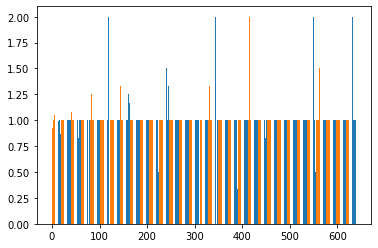

<Figure size 1440x720 with 0 Axes>

In [19]:
#visualise differences in score
import matplotlib
import matplotlib.pyplot as plt

labels = df_compare['index'].tolist()
s = df_compare['Avg_sent_singlish']
no_s = df_compare['Avg_sent_no singlish']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig = plt.figure(figsize=(20, 10))
rects1 = ax.bar(x - width/2, s, width, label='Singlish')
rects2 = ax.bar(x + width/2, no_s, width, label='No Singlish')
plt.gcf().set_size_inches(20, 10)

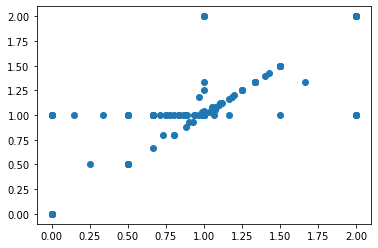

In [20]:
plt.scatter(s,no_s)

In [22]:
entity = pd.read_csv('feature-entity-table.csv')
entity['index'] = entity['index'].str.lower()
entity.drop_duplicates(inplace = True)

In [23]:
df_entity_level = pd.merge(df_compare, entity, on ='index', how='left') 
df_entity_level.dropna(inplace = True)

In [24]:
df_entity_level.to_csv('features-entity-score.csv')

In [25]:
df_entity_level

,index,Descriptors_singlish,Freq_singlish,Avg_sent_singlish,Avg_sent_no singlish,entity
1,ippt,"book ,take ,rewards ,whole ,finish ,take ,atte...",50,0.900794,0.928571,IPPT
12,rt,"loh ,got ,complete ,cleared ,attending ,booked...",19,1.181818,1.181818,RT/IPT
13,session,"first ,ipt ,8th ,previous ,book ,ippt ,book ,f...",17,1.000000,1.000000,TRAINING
21,first,"loh ,attend ,session ,sessions ,clear ,ipt ,sh...",13,0.969697,1.000000,ORDINAL
27,pes,"f ,status ,e1 ,officially ,e1 ,officially ,sta...",11,1.000000,1.000000,ORG
28,pes,"f ,status ,e1 ,officially ,e1 ,officially ,sta...",11,1.000000,1.000000,PERSON
35,ns,"booklet ,portal ,portal ,portal ,hotline ,port...",9,1.000000,1.000000,ORG
36,ns,"booklet ,portal ,portal ,portal ,hotline ,port...",9,1.000000,1.000000,GPE
39,portal,"ns ,ns ,check ,ns ,ns ,seem ,ns ,ns",8,1.000000,1.000000,PORTAL
43,months,"e1 ,took ,took ,e1 ,took ,took ,e1 ,took ,took...",8,1.076923,1.076923,DATE


In [26]:
groupby_entity = df_entity_level.groupby('entity')[['Avg_sent_singlish']].mean()

In [27]:
groupby_entity

,Avg_sent_singlish
entity,
BMT,1.000000
CAMP,1.000000
CARDINAL,1.166667
DATE,0.912821
FCC,1.000000
GPE,1.000000
ICT,1.000000
IPPT,0.900794
MEDICAL,0.833333
